In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amp-dataset/tumor necrosis factor_related.xlsx
/kaggle/input/amp-dataset/alzheimer_related.xlsx
/kaggle/input/amp-dataset/beta_amyloid_peptide_fragments_related.xlsx
/kaggle/input/amp-dataset/alpha_synuclein_related.xlsx
/kaggle/input/amp-dataset/train_peptides_add_features.csv
/kaggle/input/amp-dataset/beta_amyloid_antibodies_related.xlsx
/kaggle/input/amp-dataset/uniprot_pd_related.xlsx
/kaggle/input/amp-dataset/test_peptides_add_features.csv
/kaggle/input/amp-dataset/tau_related.xlsx
/kaggle/input/amp-dataset/urocortin_related.xlsx
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/public_timeseries_testing_util.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv
/kaggle/input/amp-

In [2]:
# !pip install biopython

In [3]:
# basic
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
from datetime import datetime
from tqdm.notebook import tqdm
from typing import List, Dict, Any, Tuple
from types import SimpleNamespace
import optuna
from optuna.samplers import TPESampler

import sys
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# ml
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split, GroupKFold, StratifiedGroupKFold, GroupShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, MultiTaskLasso, PoissonRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from scipy.spatial.distance import cdist
from sklearn.multioutput import MultiOutputRegressor

# statistic
import statistics as stat 
import scipy
from scipy.optimize import curve_fit

import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
import xgboost as xgb
import catboost as cat
from catboost import CatBoostClassifier, Pool

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# bio modules
# import Bio
# from Bio import SeqUtils
# from Bio.SeqUtils.ProtParam import ProteinAnalysis


In [4]:
cfg = SimpleNamespace()
cfg.notebook_version = "kaggle_baseline_V4"
cfg.model_name = "lgbm"
cfg.seed = 42
cfg.n_splits = 5
cfg.train_target_col = ['updrs_1','updrs_2','updrs_3','updrs_4', "upd23b_clinical_state_on_medication"]
cfg.test_target_col = ['updrs_1','updrs_2','updrs_3','updrs_4']
cfg.adjust_target_col = ['updrs_sum_1_mean','updrs_3','updrs_4']
cfg.date = datetime.now().strftime("%Y%m%d")
cfg.base_path = "/kaggle/input/amp-parkinsons-disease-progression-prediction/"

cfg.molecular_features = [
    'Molecular Weight', 'Residue Weight', 'pKa1', 'pKb2', 'pl4', 'H', 'VSC', 'P1', 'P2', 'SASA', 'NCISC', 
    'carbon', 'hydrogen', 'oxygen', 'pt_molecular_weight', 'pt_aromaticity', 'pt_instability_index', 'pt_gravy', 
    'pt_isoelectric_point', 'pt_secondary_helix', 'pt_secondary_turn', 'pt_secondary_sheet', 'pt_molar_extinction_coef_red', 
    'pt_molar_extinction_coef_cys']

cfg.peptides_molecular_full_features = [
    'pt_molecular_weight','pt_aromaticity','pt_instability_index','pt_gravy','pt_isoelectric_point','pt_secondary_helix','pt_secondary_turn','pt_secondary_sheet','pt_molar_extinction_coef_red',
    'pt_molar_extinction_coef_cys','A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','AAG0','AAG1','AAG2','AAG3','AAG4','Molecular Weight','Residue Weight','pKa1','pKb2',
    'pl4','VSC','P1','P2','SASA','NCISC','carbon','hydrogen','oxygen']
    
cfg.drop_proteins = ['Q99435', 'Q99674', 'Q99683', 'Q99829', 'Q99832'] 
cfg.drop_peptides = ['C(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK', 
                     'DALSSVQESQVAQQAR','DC(UniMod_4)GSVDGVIKEVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK','DRLDEVKEQVAEVR',
                     'DSGVPDRFSGSGSGTDFTLK','DYVSQFEGSALGK','EKLQDEDLGFL','EPQVYTLPPSRDELTK','FSALEVDETYVPK','GGTLGTPQTGSENDALYEYLR',
                     'HGNVAEGETKPDPDVTER','LAAC(UniMod_4)GPPPVAPPAAVAAVAGGAR','LEPGQQEEYYR','LYQQHGAGLFDVTR','QALNTDYLDSDYQR',
                     'QALPQVR','QQLVETHMAR','RYIETDPANRDR','SLEDQVEMLR','TINPAVDHC(UniMod_4)C(UniMod_4)K','TPVSDRVTK','TSPVDEKALQDQLVLVAAK',
                     'VAHQLQALR','VPEEDLKR','VSEADIQR']
    
# cfg.protein_candidates = ["P01594","P19827","P02748","P01009","Q06481","P05060","P04180","P17174","P14618"]
cfg.protein_candidates = ["P01009", "O15240", "P02649","Q9UHG2","P02787","P23142","P07602","P41222","P10909","Q12805","P01023"]
cfg.peptide_candidates = ["ASNLESGVPSR", "GMADQDGLKPTIDKPSEDSPPLEMLGPR", 'QC(UniMod_4)VPTEPC(UniMod_4)EDAEDDC(UniMod_4)GNDFQC(UniMod_4)STGR', 'VVEESELAR',
 "LSPIYNLVPVK", "SVLGQLGITK", "VFSNGADLSGVTEEAPLKLSK", "VFSNGADLSGVTEEAPLK","KLSSWVLLMK", "LGMFNIQHC(UniMod_4)K", "AVC(UniMod_4)SQEAMTGPC(UniMod_4)R",
 "GEAGAPGEEDIQGPTK", 'SSQGGSLPSEEK', "C(UniMod_4)IIEVLSNALSK, SSGLVSNAPGVQIR," "ITTTSPWMFPSR",
 "IGADFLAR", "VGGVQSLGGTGALR", "NTGIIC(UniMod_4)TIGPASR", "LDIDSPPITAR"]


cfg.basic_pep_stat_feats = ['mean_PA','std_PA','var_PA','skew_PA','kurt_PA', 'mad_PA', 'express_pep_num']
cfg.basic_prot_stat_feats = ['mean_NPX','quan10_NPX','quan50_NPX','quan90_NPX','std_NPX','var_NPX','skew_NPX','kurt_NPX', 'mad_NPX', 'express_prot_num']

# ['GYPGVQAPEDLEWER', 'LLRDPADASEAHESSSR']
# train
cfg.train_clinical = cfg.base_path + "train_clinical_data.csv"
cfg.train_peptides = cfg.base_path + "train_peptides.csv"
cfg.train_proteins = cfg.base_path + "train_proteins.csv"
cfg.sup_clinical = cfg.base_path + "supplemental_clinical_data.csv"
cfg.train_proteins = cfg.base_path + "train_proteins.csv"
cfg.train_molecular_features = "/kaggle/input/amp-dataset/train_peptides_add_features.csv"

# test
cfg.test = cfg.base_path + "example_test_files/test.csv"
cfg.test_peptides = cfg.base_path + "example_test_files/test_peptides.csv"
cfg.test_proteins = cfg.base_path + "example_test_files/test_proteins.csv"
cfg.sample_submission = cfg.base_path + "example_test_files/sample_submission.csv"
cfg.test_molecular_features = "/kaggle/input/amp-dataset/test_peptides_add_features.csv"


# third dataset
cfg.parkinson = "/kaggle/input/amp-dataset/uniprot_pd_related.xlsx"
cfg.alpha_synuclein = '/kaggle/input/amp-dataset/alpha_synuclein_related.xlsx'
cfg.alzheimer = '/kaggle/input/amp-dataset/alzheimer_related.xlsx'
cfg.beta_amyloid_antibody = '/kaggle/input/amp-dataset/beta_amyloid_antibodies_related.xlsx'
cfg.beta_amyloid_peptide_fragment = '/kaggle/input/amp-dataset/beta_amyloid_peptide_fragments_related.xlsx'
cfg.tau = '/kaggle/input/amp-dataset/tau_related.xlsx'
cfg.tumor_necrosis_factor = '/kaggle/input/amp-dataset/tumor necrosis factor_related.xlsx'
cfg.urocortin = '/kaggle/input/amp-dataset/urocortin_related.xlsx'


cfg.device = "cuda" if torch.cuda.is_available() else "cpu"
# os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [5]:
# set seed
def seed_everthing(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

seed_everthing(cfg.seed)

pd.set_option('display.max_columns', 500) ## 모든 열 출력
pd.set_option('display.max_rows', 500) ## 모든 행 출력

def smape(y_true, y_pred):
    y_true = y_true.copy()
    y_pred = y_pred.copy()
    smap = np.zeros(len(y_true))
    y_true +=  1
    y_pred +=  1

    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

In [6]:
# train
train_clinical = pd.read_csv(cfg.train_clinical)
train_peptides = pd.read_csv(cfg.train_peptides)
train_proteins = pd.read_csv(cfg.train_proteins)
sup_clinical = pd.read_csv(cfg.sup_clinical)
train_molecular_features = pd.read_csv(cfg.train_molecular_features)

# test
test_proteins = pd.read_csv(cfg.test_proteins)
test_peptides = pd.read_csv(cfg.test_peptides)
test = pd.read_csv(cfg.test)
sample_submission = pd.read_csv(cfg.sample_submission)
test_molecular_features = pd.read_csv(cfg.test_molecular_features)


train_proteins['NPX'] = train_proteins['NPX'].apply(np.log1p)
train_peptides['PeptideAbundance'] = train_peptides['PeptideAbundance'].apply(np.log1p)

In [7]:
train_clinical[cfg.test_target_col] = train_clinical[cfg.test_target_col].apply(np.log1p)
sup_clinical[cfg.test_target_col] = sup_clinical[cfg.test_target_col].apply(np.log1p)
clinical_all = pd.concat([train_clinical, sup_clinical],axis=0)


In [8]:
clinical_all['cumcount'] = clinical_all.groupby('patient_id').cumcount()
clinical_all = clinical_all.merge(clinical_all.groupby('patient_id').count().reset_index().rename(columns={"visit_id":"visit_count"})[['patient_id','visit_count']], on='patient_id', how='left')
clinical_all = clinical_all[clinical_all['visit_count']!=1].reset_index(drop=True)
# clinical_all = clinical_all[~clinical_all['visit_month'].isin([3,5,9])].reset_index(drop=True)

In [9]:
clinical_all = clinical_all.drop(['cumcount','visit_count'],axis=1)

In [10]:
# tt = pd.merge(clinical_all, train_proteins.pivot('visit_id','UniProt','NPX').reset_index(),on='visit_id', how='left')
# tt = pd.merge(tt, train_peptides.pivot('visit_id','Peptide','PeptideAbundance').reset_index(), on='visit_id',how='left')

In [11]:
# tt = pd.merge(train_proteins, train_peptides, on=['visit_id','visit_month','patient_id','UniProt'],how='inner')
# tt['multi_PA_NPX'] = tt['PeptideAbundance'] * tt['NPX']

In [12]:
# tt = tt.groupby(["visit_id",'UniProt'],group_keys=False).sum().reset_index()
# tt = tt.pivot('visit_id','UniProt','multi_PA_NPX').reset_index()

In [13]:

# clinical_all['updrs_1_cluster'] = clinical_all['updrs_1'].apply(lambda x: 0 if x <10 else ( 1 if (x >=10) and (x<22) else 3))
# clinical_all['updrs_2_cluster'] = clinical_all['updrs_2'].apply(lambda x: 0 if x <12 else ( 1 if (x >=12) and (x<30) else 3))
# clinical_all['updrs_3_cluster'] = clinical_all['updrs_3'].apply(lambda x: 0 if x <32 else ( 1 if (x >=32) and (x<59) else 3))
# clinical_all['updrs_4_cluster'] = clinical_all['updrs_4'].fillna(0).apply(lambda x: 0 if x <4 else ( 1 if (x >=4) and (x<13) else 3))

In [14]:
# def extract_feature(df):
#     amino_acids_df = pd.DataFrame()
#     feature_df = pd.DataFrame()
    
#     molecular_weight_list = []
#     aromat_list = []
#     instability_index_list = []
#     flexibility_list = []
#     gravy_list = []
#     isoelectric_point_list = []
#     secon_struc_helix_list = []
#     secon_struc_turn_list = []
#     secon_struc_sheet_list = []
#     molar_extinction_coefficient_list = []
 
#     for seq in tqdm(df['Peptide'].values):
#         seq = seq.replace("(UniMod_4)","").replace('(UniMod_35)','')
#         X = ProteinAnalysis(seq)
#         #secondary_structure_fraction()  # [helix, turn, sheet]

#         molecular_weight_list.append(X.molecular_weight())
#         aromat_list.append(X.aromaticity())
#         instability_index_list.append(X.instability_index())
#         flexibility_list.append(np.mean(X.flexibility()))
#         gravy_list.append(X.gravy())
#         isoelectric_point_list.append(X.isoelectric_point())
#         secondary_factor = X.secondary_structure_fraction()
#         if np.isnan(any(secondary_factor)):
#             secon_struc_helix_list.append(np.nan)
#             secon_struc_turn_list.append(np.nan)
#             secon_struc_sheet_list.append(np.nan)
#         else:
#             secon_struc_helix_list.append(secondary_factor[0])
#             secon_struc_turn_list.append(secondary_factor[1])
#             secon_struc_sheet_list.append(secondary_factor[2])
        
#         reduced, oxidized = X.molar_extinction_coefficient()
#         if np.isnan(oxidized):
#             molar_extinction_coefficient_list.append(np.nan)           
#         else:
#             molar_extinction_coefficient_list.append(oxidized)
        
#         amino_dic = X.get_amino_acids_percent()
        
#         if type(amino_dic)== dict:
#             amino_acids_df = pd.concat([amino_acids_df, pd.DataFrame(amino_dic,index=[0])],axis=0)
#         else:
# #             display(amino_dic)
#             amino_acids_df = pd.concat([amino_acids_df, pd.DataFrame([[np.nan]*20])],axis=0)
            
#     amino_acids_df.reset_index(drop=True,inplace=True)
# #     display(amino_acids_df)
#     feature_df['molecular_weight'] = molecular_weight_list
#     feature_df['aromat'] = aromat_list
#     feature_df['instability_index'] = instability_index_list
#     feature_df['flexibility'] = flexibility_list
#     feature_df['gravy'] = gravy_list
#     feature_df['isoelectric_point'] = isoelectric_point_list
#     feature_df['secon_struc_helix'] = secon_struc_helix_list
#     feature_df['secon_struc_turn'] = secon_struc_turn_list
#     feature_df['secon_struc_sheet'] = secon_struc_sheet_list
#     feature_df['molar_extinction_coefficient'] = molar_extinction_coefficient_list
# #     display(feature_df)
#     feature_df = pd.concat([feature_df, amino_acids_df],axis=1)
#     return pd.concat([df,feature_df], axis=1)

# df = extract_feature(train_peptides)

In [15]:
# train_clinical = train_clinical[~train_clinical.visit_month.isin([5])]
# train_clinical[cfg.test_target_col] = train_clinical[cfg.test_target_col].apply(np.log1p)
# sup_clinical[cfg.test_target_col] = sup_clinical[cfg.test_target_col].apply(np.log1p)

# clinical_all = pd.concat([train_clinical,sup_clinical],axis=0)
# clinical_all = clinical_all[~clinical_all.visit_month.isin([3,5,9])]

# clinical_all[cfg.test_target_col] = clinical_all[cfg.test_target_col].apply(np.log1p)



In [16]:
# 중앙값
target_columns_clinical_data = ['updrs_1']
target_columns_clinical_and_supplemental_data = ['updrs_2', 'updrs_3', 'updrs_4']

target_visit_month_medians_clinical_data = train_clinical.groupby('visit_month')[target_columns_clinical_data].median()
target_visit_month_medians_clinical_and_supplemental_data = pd.concat((
    train_clinical,
    sup_clinical
), axis=0).groupby('visit_month')[target_columns_clinical_and_supplemental_data].median()

target_visit_month_medians = pd.concat((
    target_visit_month_medians_clinical_data,
    target_visit_month_medians_clinical_and_supplemental_data
), axis=1, ignore_index=False)

target_visit_month_medians = target_visit_month_medians.drop(5)
# target_visit_month_medians = target_visit_month_medians.drop(3)
# target_visit_month_medians = target_visit_month_medians.drop(9)

target_visit_month_medians = target_visit_month_medians.expanding(min_periods=1).max()
target_visit_month_medians = target_visit_month_medians.reset_index()
target_visit_month_medians

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,0,1.700599,1.609438,2.944439,0.000000
1,3,1.700599,1.791759,2.995732,0.000000
2,6,1.945910,1.945910,3.091042,0.000000
3,9,1.945910,1.945910,3.091042,0.000000
4,12,1.945910,1.945910,3.091042,0.000000
5,18,1.945910,1.945910,3.091042,0.000000
6,24,1.945910,1.945910,3.091042,0.000000
7,30,2.079442,1.945910,3.135494,0.000000
8,36,2.079442,1.945910,3.135494,0.000000
9,42,2.079442,2.079442,3.178054,0.000000


In [17]:
# 평균값
target_columns_clinical_data = ['updrs_1']
target_columns_clinical_and_supplemental_data = ['updrs_2', 'updrs_3', 'updrs_4']

target_visit_month_means_clinical_data = train_clinical.groupby('visit_month')[target_columns_clinical_data].mean()
target_visit_month_means_clinical_and_supplemental_data = pd.concat((
    train_clinical,
    sup_clinical
), axis=0).groupby('visit_month')[target_columns_clinical_and_supplemental_data].mean()

target_visit_month_means = pd.concat((
    target_visit_month_means_clinical_data,
    target_visit_month_means_clinical_and_supplemental_data
), axis=1, ignore_index=False)

target_visit_month_means = target_visit_month_means.drop(5)
# target_visit_month_means = target_visit_month_means.drop(3)
# target_visit_month_means = target_visit_month_means.drop(9)

target_visit_month_means = target_visit_month_means.expanding(min_periods=1).max()
target_visit_month_means = target_visit_month_means.reset_index()
target_visit_month_means

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,0,1.612839,1.591630,2.584513,0.413103
1,3,1.612839,1.796690,2.930849,0.413103
2,6,1.816562,1.796690,2.930849,0.451011
3,9,1.816562,1.886503,2.930849,0.451011
4,12,1.816562,1.886503,2.930849,0.451011
5,18,1.875152,1.886503,2.930849,0.451011
6,24,1.875152,1.886503,2.930849,0.477034
7,30,2.029492,1.886503,2.950964,0.477034
8,36,2.029492,1.886503,2.950964,0.477034
9,42,2.029492,1.899241,2.950964,0.640729


In [18]:
# clinical_all['updrs_sum_1_2'] = (clinical_all['updrs_1'] + clinical_all['updrs_2']) * 0.8
# clinical_all['updrs_sum_1_mean'] = clinical_all['updrs_sum_1_2']/1.55
# clinical_all['updrs_1'] = clinical_all['updrs_sum_1_mean']
# clinical_all.drop(['updrs_sum_1_mean','updrs_sum_1_2'],axis=1,inplace=True)
# clinical_all['updrs_sum_2_3'] = clinical_all['updrs_1'] + clinical_all['updrs_2']

In [19]:
# clinical_all['updrs_sum_1_2'] = (clinical_all['updrs_1'] + clinical_all['updrs_2']) * 0.8
# clinical_all['updrs_sum_2_3'] = (clinical_all['updrs_1'] + clinical_all['updrs_2'] + clinical_all['updrs_3']) * 0.45
# clinical_all['updrs_sum_3_3'] = (clinical_all['updrs_1'] + clinical_all['updrs_2'] + clinical_all['updrs_3']) * 0.9
# clinical_all['updrs_sum_1_mean'] = clinical_all['updrs_sum_1_2']/1.55
# clinical_all['updrs_sum_2_mean'] = clinical_all['updrs_sum_2_3']/1.60
# clinical_all['updrs_sum_3_mean'] = clinical_all['updrs_sum_2_3']/1.04
# clinical_all['updrs_1'] = clinical_all['updrs_sum_1_mean']
# clinical_all['updrs_2'] = clinical_all['updrs_sum_2_mean']
# clinical_all['updrs_3'] = clinical_all['updrs_sum_3_mean']

# clinical_all.drop(['updrs_sum_2_3','updrs_sum_2_mean'],axis=1,inplace=True)
# clinical_all.drop(['updrs_sum_1_2','updrs_sum_2_3','updrs_sum_3_3',\
#                    'updrs_sum_1_mean','updrs_sum_2_mean','updrs_sum_3_mean'],axis=1,inplace=True)

In [20]:
# clinical_all.groupby(['visit_month'],group_keys=False).mean()[cfg.test_target_col + ['updrs_sum_1_mean','updrs_sum_2_mean','updrs_sum_3_mean']].plot()

In [21]:
target_dict = {'updrs_1_plus_0': ['Q06481', 'P05060'],
 'updrs_1_plus_6': ['Q06481', 'P04180'],
 'updrs_1_plus_12': ['Q06481', 'P05060'],
 'updrs_1_plus_24': ['Q06481', 'P04180'],
 'updrs_2_plus_0': ['Q06481', 'P04180'],
 'updrs_2_plus_6': ['Q06481', 'P05060'],
 'updrs_2_plus_12': ['P05060', 'Q06481'],
 'updrs_2_plus_24': ['O15240', 'P02787'],
 'updrs_3_plus_0': ['O15240', 'P13521'],
 'updrs_3_plus_6': ['O00533', 'P13521'],
 'updrs_3_plus_12': ['P13521', 'O00533'],
 'updrs_3_plus_24': ['O15240', 'P13521'],
 'updrs_4_plus_0': ['P02774', 'P04217'],
 'updrs_4_plus_6': ['P04217', 'P02774'],
 'updrs_4_plus_12': ['P04217', 'P02774'],
 'updrs_4_plus_24': ['P05060', 'P04217']}

select_protein = list(set([ protein for protein_list in target_dict.values() for protein in protein_list]))

In [22]:
def preprocessing_train_data(clinical, peptides, proteins, peptide_candidates, protein_candidates):

    def create_peptide_candidate_df(peptides_df, peptide_candidates):
        peptide_candidate_df = peptides_df.query("Peptide in @peptide_candidates")
        visit_ids = peptide_candidate_df['visit_id'].unique()

        peptide_dic_list = []

        for visit_id in visit_ids:
            peptide_df = peptide_candidate_df.query(f"visit_id == '{visit_id}'")
            peptides = peptide_df.Peptide.values
            PAs = peptide_df.PeptideAbundance.values
            peptide_dic = dict(zip(peptide_candidates, [np.nan]*len(peptide_candidates)))
            for peptide, PA in zip(peptides, PAs):
                peptide_dic[peptide] = PA
            peptide_dic['visit_id'] = visit_id
            peptide_dic_list.append(peptide_dic)
        
        return pd.DataFrame(peptide_dic_list)


    def create_protein_candidate_df(proteins_df, protein_candidates):
        protein_candidate_df = proteins_df.query("UniProt in @protein_candidates")
        visit_ids = protein_candidate_df['visit_id'].unique()

        protein_dic_list = []

        # display(protein_candidate_df.head())

        for visit_id in visit_ids:
            protein_df = protein_candidate_df.query(f"visit_id == '{visit_id}'")
            proteins = protein_df.UniProt.values
            NPXs = protein_df.NPX.values
            protein_dic = dict(zip(protein_candidates, [np.nan]*len(protein_candidates)))
            for protein, NPX in zip(proteins, NPXs):
                protein_dic[protein] = NPX
            protein_dic['visit_id'] = visit_id
            protein_dic_list.append(protein_dic)
        
        return pd.DataFrame(protein_dic_list)
    
    def median_protein_fill(df, proteins, protein_candidates):
        # median_df = pd.merge(df, peptides[peptides['Peptide'].isin(peptide_candidates)].pivot('visit_id','Peptide','PA_log2').reset_index(),on='visit_id',how='left')
        # median_df = pd.merge(median_df, proteins[proteins['UniProt'].isin(protein_candidates)].pivot('visit_id','UniProt','NPX_log2').reset_index(),on='visit_id',how='left')
        median_df = df.groupby("visit_month")[protein_candidates].median()
        median_df.interpolate(inplace=True)
        median_df.reset_index(inplace=True)
        
        
        for visit_month in tqdm(median_df['visit_month'].values):
            for feat in protein_candidates:
                df.loc[(df['visit_month']==visit_month)  & (df[feat].isnull()), feat] = \
                    median_df[median_df["visit_month"]==visit_month][feat].values[0]
        
        return df
    
    def create_basic_peptide_protein_stat_features(peptides,proteins):
    
        unique_peptide = peptides.Peptide.unique()
        pivot_pep_df = peptides.pivot(['visit_id', 'visit_month','patient_id'],'Peptide','PeptideAbundance').reset_index()
        pivot_pep_df["non_express_pep_num"] = pivot_pep_df[unique_peptide].isnull().sum(axis=1)
        pivot_pep_df['express_pep_num'] = len(unique_peptide) - pivot_pep_df['non_express_pep_num']
#         pivot_pep_df = pivot_pep_df.groupby('visit_month',group_keys = False).apply(lambda x: x.fillna(x.median()))
        pivot_pep_df = pivot_pep_df.fillna(0)
        
        peptide_mean = pivot_pep_df.groupby('patient_id')[unique_peptide].mean().reset_index()
        
#         pivot_pep_df[unique_peptide] = pivot_pep_df[unique_peptide].apply(lambda x : x / x.sum())
        pivot_pep_df['mean_PA'] = pivot_pep_df[unique_peptide].mean(axis=1)
#         pivot_pep_df['diff_PA'] = pivot_pep_df[unique_peptide].max(axis=1) - pivot_pep_df[unique_peptide].min(axis=1)
        pivot_pep_df['std_PA'] = pivot_pep_df[unique_peptide].std(axis=1)
        pivot_pep_df['var_PA'] = pivot_pep_df[unique_peptide].var(axis=1)
        pivot_pep_df['skew_PA'] = pivot_pep_df[unique_peptide].skew(axis=1)
        pivot_pep_df['kurt_PA'] = pivot_pep_df[unique_peptide].kurt(axis=1)
        pivot_pep_df['mad_PA'] = pivot_pep_df[unique_peptide].mad(axis=1)

    
    
    
    
        # csf의 단백질 수치가 많아지면 염증, 몸이 안좋다는 점
        unique_protein = proteins.UniProt.unique()
        pivot_prot_df = proteins.pivot(['visit_id','visit_month', 'patient_id'],'UniProt','NPX').reset_index()
        pivot_prot_df["non_express_prot_num"] = pivot_prot_df[unique_protein].isnull().sum(axis=1)
        pivot_prot_df['express_prot_num'] = len(unique_protein) - pivot_prot_df['non_express_prot_num']
 
#         pivot_prot_df = pivot_prot_df.groupby('visit_month',group_keys = False).apply(lambda x: x.fillna(x.median()))
        pivot_prot_df = pivot_prot_df.fillna(0)
        
        protein_mean = pivot_prot_df.groupby('patient_id')[unique_protein].mean().reset_index()
        
#         pivot_prot_df[unique_protein] = pivot_prot_df[unique_protein].apply(lambda x : x / x.sum()) 
        pivot_prot_df['mean_NPX'] = pivot_prot_df[unique_protein].mean(axis=1)
#         pivot_prot_df['diff_NPX'] = pivot_prot_df[unique_protein].max(axis=1) - pivot_prot_df[unique_protein].min(axis=1)
        pivot_prot_df['quan10_NPX'] = pivot_prot_df[unique_protein].quantile(0.10, axis=1)
        pivot_prot_df['quan50_NPX'] = pivot_prot_df[unique_protein].quantile(0.50, axis=1)
        pivot_prot_df['quan90_NPX'] = pivot_prot_df[unique_protein].quantile(0.90, axis=1)
        
        pivot_prot_df['std_NPX'] = pivot_prot_df[unique_protein].std(axis=1)
        pivot_prot_df['var_NPX'] = pivot_prot_df[unique_protein].var(axis=1)
        pivot_prot_df['skew_NPX'] = pivot_prot_df[unique_protein].skew(axis=1)
        pivot_prot_df['kurt_NPX'] = pivot_prot_df[unique_protein].kurt(axis=1)
        pivot_prot_df['mad_NPX'] = pivot_prot_df[unique_protein].mad(axis=1)
   


        return pivot_pep_df[['visit_id','mean_PA','std_PA','var_PA','skew_PA','kurt_PA', 'mad_PA', 'express_pep_num']], \
                pivot_prot_df[['visit_id','mean_NPX','quan10_NPX','quan50_NPX','quan90_NPX','std_NPX','var_NPX','skew_NPX','kurt_NPX', 'mad_NPX', 'express_prot_num']]
   
    
    def create_row_peptide_protein_stat_features(peptides, proteins):
        
        # peptide sd
        unique_peptide = peptides.Peptide.unique()
        pivot_pep_df = peptides.pivot(['visit_id', 'patient_id'],'Peptide','PeptideAbundance').reset_index()
        pivot_pep_df = pivot_pep_df.fillna(1)
        
        pivot_pep_df = pd.concat([pivot_pep_df,pivot_pep_df[unique_peptide].apply(lambda x: np.sqrt((x - peptide_mean.values.T)**2), axis=1).add_prefix("sd_")],axis=1)
        
        sd_pep_features = list(pivot_pep_df.columns[pivot_pep_df.columns.str.contains("sd")])
        
        
        # protein sd
        unique_protein = proteins.UniProt.unique()
        pivot_prot_df = proteins.pivot(['visit_id', 'patient_id'],'UniProt','NPX').reset_index()
        pivot_prot_df = pivot_prot_df.fillna(1)
        
        pivot_prot_df = pd.concat([pivot_prot_df,pivot_prot_df[unique_protein].apply(lambda x: np.sqrt((x - protein_mean.values.T)**2), axis=1).add_prefix("sd_")],axis=1)
        
        sd_prot_features = list(pivot_prot_df.columns[pivot_prot_df.columns.str.contains("sd")])
        return pivot_pep_df[["visit_id"] + sd_pep_features], pivot_prot_df[["visit_id"] + sd_prot_features]
        
        
    df = clinical.copy()
    
#     peptide_candidate_df = create_peptide_candidate_df(peptides, peptide_candidates)
    protein_candidate_df = create_protein_candidate_df(proteins, protein_candidates)
    
#     peptide_features_col = list(peptide_candidate_df.columns)
    protein_features_col = list(protein_candidate_df.columns)

#     peptide_features_col.remove("visit_id")
    protein_features_col.remove("visit_id")
    
    pivot_basic_pep_df, pivot_basic_prot_df = create_basic_peptide_protein_stat_features(peptides,proteins)
#     df = pd.merge(df, protein_candidate_df, on='visit_id',how='left')
#     df = pd.merge(df, pivot_basic_prot_df, on='visit_id', how='left')

   
#     df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    df["upd23b_clinical_state_on_medication"] = df["upd23b_clinical_state_on_medication"].apply(lambda x : 2 if x == "On" else (1 if x=='Off' else 0) )
   
    
#     if "upd23b_clinical_state_on_medication" in df.columns:
#         df.drop("upd23b_clinical_state_on_medication",axis=1, inplace=True)
    
    return df

In [23]:
# peptide_candidates = list(find_peptide_candidates(train_peptides, num_candidate=50))
# protein_candidates = list(find_protein_candidates(train_proteins, num_candidate=50))
# unique_protein = list(train_proteins.UniProt.unique())
# unique_peptide = list(train_peptides.Peptide.unique())
train_df = preprocessing_train_data(clinical_all, train_peptides, train_proteins, [], select_protein)
# time_train_df = preprocessing_train_data(clinical_all, train_peptides, train_proteins, [], select_protein)


print('train_df:')
display(train_df.head(10).style.set_properties(
    **{"background-color": "#212636","color":"white","border": "1.5px solid white"}))
display(train_df.shape)


train_df:


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,2.397895,1.945910,2.772589,nan,0
1,55_3,55,3,2.397895,2.079442,3.258097,nan,0
2,55_6,55,6,2.197225,2.397895,3.555348,nan,0
3,55_9,55,9,2.197225,2.302585,3.433987,0.000000,2
4,55_12,55,12,2.397895,2.397895,3.737670,0.000000,2
5,55_18,55,18,2.079442,2.639057,3.663562,0.000000,2
6,55_24,55,24,2.833213,2.302585,3.912023,0.000000,2
7,55_30,55,30,2.708050,2.639057,3.912023,0.000000,2
8,55_36,55,36,2.890372,2.944439,3.951244,0.000000,2
9,55_42,55,42,2.564949,3.044522,3.737670,0.000000,2


(4692, 8)

In [24]:
# features_col = cfg.basic_prot_stat_feats + ['visit_month','plus_month']
features_col = ['visit_month','plus_month']
scaler = RobustScaler()
# train_df[features_col] = scaler.fit_transform(train_df[features_col])



In [25]:
def create_X_y_train_dataset(df, classes, plus_month):
    
    df_ = df.dropna(subset=[f'updrs_{classes}'])
#     df_ = df_[df_['visit_month']!=108]
    if classes == 3:
        df_ = df_[df_[f'updrs_{classes}']!=0].reset_index(drop=True)
    X_visit_ids = []
    y_visit_ids = []
    patient_ids = df['patient_id'].values

    for i, patient_id in enumerate(patient_ids):
        patient_df = df_[df_['patient_id']==patient_id]
        plus_months = patient_df['visit_month'] + plus_month
        plus_months = patient_df.query('visit_month in @plus_months')['visit_month']

        original_months = plus_months - plus_month
        patient_id = str(patient_id)
#         display(month_offset)
        X_visit_id = [patient_id + "_" + str(original_month) for original_month in original_months]
        y_visit_id = [patient_id + "_" + str(plus_month) for plus_month in plus_months]
        X_visit_ids.extend(X_visit_id)
        y_visit_ids.extend(y_visit_id)
    
    
    X = df_.query('visit_id in @X_visit_ids')
    X = X.drop(['updrs_1','updrs_2','updrs_3','updrs_4'],axis=1)
    X.reset_index(drop=True, inplace=True)
#     X = X.fillna(0)
    
    y = df_.query('visit_id in @y_visit_ids')
    y = y[['visit_id', f'updrs_{classes}']]
    y.reset_index(drop=True, inplace=True)

    return X, y

def create_X_y_dict(df):
    X_dic = {}
    y_dic = {}    
    
    for clz in tqdm([1,2,3,4]):
        for idx,plus_month in enumerate(tqdm([0, 6, 12, 24])):
            X, y = create_X_y_train_dataset(df, clz, plus_month)
            
            key = f'updrs_{clz}_plus_{plus_month}'
            X['plus_month'] = plus_month
#             X['month_offset'] = X['visit_month'] + X['plus_month']
            feature = target_dict[f'updrs_{clz}_plus_{plus_month}']
            X_dic[key] = X[["visit_id","patient_id",'visit_month','plus_month']]
            y_dic[key] = y

            
             
    return X_dic, y_dic


In [26]:
X_dict, y_dict= create_X_y_dict(train_df)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [27]:
scaler_dict =  {'updrs_1_plus_0': None,
 'updrs_1_plus_6': None,
 'updrs_1_plus_12': None,
 'updrs_1_plus_24': None,
 'updrs_2_plus_0': None,
 'updrs_2_plus_6': None,
 'updrs_2_plus_12': None,
 'updrs_2_plus_24': None,
 'updrs_3_plus_0': None,
 'updrs_3_plus_6': None,
 'updrs_3_plus_12': None,
 'updrs_3_plus_24': None,
 'updrs_4_plus_0': None,
 'updrs_4_plus_6': None,
 'updrs_4_plus_12': None,
 'updrs_4_plus_24': None}

In [28]:
scaler_df = pd.DataFrame()

for k,v in X_dict.items():
    scaler_df = pd.concat([scaler_df,v],axis=0)
scaler.fit(scaler_df[features_col])

for k, v in X_dict.items():
    X_dict[k][features_col] = scaler.transform(X_dict[k][features_col])

# scoler
# for k,v in X_dict.items():
#     scaler_ = RobustScaler()
#     feature = target_dict[k]
#     scaler_.fit(scaler_df[feature])
#     scaler_dict[k] = scaler_
    
# for k,v in tqdm(X_dict.items()):
#     feature = target_dict[k]
#     X_dict[k][features_col] = scaler.transform(X_dict[k][features_col])
#     X_dict[k][feature] = scaler_dict[k].transform(X_dict[k][feature])

In [29]:
# for k,v in tqdm(X_dict.items()):
#     display(v)
#     break

In [30]:
from sklearn.utils.validation import _check_fit_params
from sklearn.base import is_classifier
from sklearn.utils.fixes import delayed
from joblib import Parallel
from sklearn.multioutput import _fit_estimator

class MyMultiOutputRegressor(MultiOutputRegressor):
    
    def fit(self, X, y, sample_weight=None, **fit_params):
        """ Fit the model to data.
        Fit a separate model for each output variable.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Data.
        y : {array-like, sparse matrix} of shape (n_samples, n_outputs)
            Multi-output targets. An indicator matrix turns on multilabel
            estimation.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.
            Only supported if the underlying regressor supports sample
            weights.
        **fit_params : dict of string -> object
            Parameters passed to the ``estimator.fit`` method of each step.
            .. versionadded:: 0.23
        Returns
        -------
        self : object
        """

        if not hasattr(self.estimator, "fit"):
            raise ValueError("The base estimator should implement"
                             " a fit method")

        X, y = self._validate_data(X, y,
                                   force_all_finite=False,
                                   multi_output=True, accept_sparse=True)

        if is_classifier(self):
            check_classification_targets(y)

        if y.ndim == 1:
            raise ValueError("y must have at least two dimensions for "
                             "multi-output regression but has only one.")

        if (sample_weight is not None and
                not has_fit_parameter(self.estimator, 'sample_weight')):
            raise ValueError("Underlying estimator does not support"
                             " sample weights.")

        fit_params_validated = _check_fit_params(X, fit_params)
        [(X_test, Y_test)] = fit_params_validated.pop('eval_set')
        self.estimators_ = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_estimator)(
                self.estimator, X, y[:, i], sample_weight,
                **fit_params_validated, eval_set=[(X_test, Y_test[:, i])])
            for i in range(y.shape[1]))
        return self

In [31]:
def exp_score(y_true,y_pred):
    return smape(np.expm1(y_true), np.expm1(y_pred))

def normal_score(y_true, y_pred):
    return smape(y_true, y_pred)


class Callback:
    def __init__(self):
        self.models = {}

    def register_model(self, trial_number, model):
        self.models[str(trial_number)] = model

    def unregister_model(self,trial_number):
        self.models.pop(str(trial_number), None)

    def unregister_other_model(self, trial_number):
        model = self.models.pop(str(trial_number), None)
        self.models.clear()
        self.models[str(trial_number)] = model

    def get_model(self, trial_number):
        return self.models[str(trial_number)]

    def __call__(self, study, trial):
        if study.best_trial.number == trial.number:
            self.unregister_other_model(study.best_trial.number)
            self.save(study)
        else:
            self.unregister_model(trial.number)

    def save(self, study):
        model = self.get_model(study.best_trial.number)

    

        
class LGBMObject():
    def __init__(self, X_trn, X_val, y_trn, y_val, callback):
        self.callback = callback
        
        self.X_trn = X_trn
        self.y_trn = y_trn
        self.X_val = X_val
        self.y_val = y_val

        
    def __call__(self, trial):
        params = {
        'n_estimators'     : trial.suggest_int('n_estimators', 10, 700),
        'verbosity'        : -100,
#         'verbose'        : -1,
        'objective'        : trial.suggest_categorical('objective',['l1','l2']),
        'random_state'     : 42,
        'extra_trees'      : True,
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 0.8),
        'colsample_bynode' : trial.suggest_float('colsample_bynode', 0.1, 0.8),
        'max_depth'        : trial.suggest_int('max_depth', 3, 128),
        'learning_rate'    : trial.suggest_float('learning_rate', 5e-3, 1e-1, log=True),
        'lambda_l1'        : trial.suggest_float('lambda_l1', 1e-2, 25.0),
        'lambda_l2'        : trial.suggest_float('lambda_l2', 1e-2, 25.0),
        'num_leaves'       : trial.suggest_int('num_leaves', 2, 128),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 3, 128),
        }
        
        
        
        fit_params = { 
#             'early_stopping_rounds' : 50,
            'eval_set': [(self.X_val, np.array(self.y_val))],
            'eval_metric':'l2',
            'callbacks' : [early_stopping(10), log_evaluation(0)]
        }
        
        
        lgbm_model = lgb.LGBMRegressor(**params)
#         model = MyMultiOutputRegressor(lgbm_model)
        
        lgbm_model.fit(self.X_trn, self.y_trn,  **fit_params)
        self.callback.register_model(trial.number, lgbm_model)
        y_pred = lgbm_model.predict(self.X_val)
        
#         display(y_pred)
#         y_pred = np.array([i[0] for i in y_pred])
#         y_pred2 = np.array([i[1] for i in y_pred])
        score = exp_score(self.y_val, y_pred)
#         score2 = normal_score(self.y_val.iloc[:,1], y_pred2)
#         score = ((score1*0.9) + (score2*0.1))
        
        return score
    
    
class LRMObject():
    def __init__(self, X_trn, X_val, y_trn, y_val, callback):

        self.callback = callback
        
        self.X_trn = X_trn
        self.X_val = X_val
        self.y_trn = y_trn
        self.y_val = y_val

    def __call__(self, trial):
        params = {'copy_X': trial.suggest_categorical("copy_X",[True,False]),
         'fit_intercept': trial.suggest_categorical("fit_intercept",[True,False]),
         'n_jobs': trial.suggest_categorical("n_jobs",[0,1,2]),
         'positive': trial.suggest_categorical("positive",[True,False])}
        
        
        lr_model = LinearRegression(**params)
#         lr_model = MultiOutputRegressor(lr_model)
        lr_model.fit(self.X_trn, self.y_trn)
        y_pred = lr_model.predict(self.X_val)
        self.callback.register_model(trial.number, lr_model)
        
#         y_pred1 = np.array([i[0] for i in y_pred])
#         y_pred2 = np.array([i[1] for i in y_pred])
        score = exp_score(self.y_val, y_pred1)
#         score2 = normal_score(self.y_val.iloc[:,1], y_pred2)
#         score = ((score1*0.9) + (score2*0.1))
        return score    


class LSVRObject():
    def __init__(self, X_trn, X_val, y_trn, y_val, callback):

        self.callback = callback
        
        self.X_trn = X_trn
        self.X_val = X_val
        self.y_trn = y_trn
        self.y_val = y_val

    def __call__(self, trial):
        params = {
#             'C' : trial.suggest_float('C', )
            "tol" : trial.suggest_float("tol", 5e-5, 1e-3),
            'max_iter' : trial.suggest_int('max_iter', 100, 3000),
            'dual' : True
            }
        
        
        lsvr_model = LinearSVR(**params)
#         lsvr_model = (lsvr_model)
        lsvr_model.fit(self.X_trn, self.y_trn)
        y_pred = lsvr_model.predict(self.X_val)
        self.callback.register_model(trial.number, lsvr_model)
        
#         y_pred1 = np.array([i[0] for i in y_pred])
#         y_pred2 = np.array([i[1] for i in y_pred])
        score = exp_score(self.y_val, y_pred)
#         score2 = normal_score(self.y_val.iloc[:,1], y_pred2)
#         score = ((score1*0.9) + (score2*0.1))
     
        return score

In [32]:
def add_fold_column(X, y, n_folds):
    X_ = X.copy()
    y_ = y.copy()

    X_['fold'] = -1
    y_['fold'] = -1

#     num_bins = int(np.floor(1+np.log2(len(y))))
#     y_bin = pd.cut(y_.iloc[:,1], # updrs_X score
#                    bins=num_bins,
#                    labels=False)

#     skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=cfg.seed)
    gkf = GroupKFold(n_splits = n_folds)
#     gss = GroupShuffleSplit(n_splits = n_folds, random_state=seed)
#     sgkf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=cfg.seed)
    groups = X_['patient_id'].values
        
    X_ = X_.drop('patient_id',axis=1)
    for fold, (trn_idx, val_idx) in enumerate(gkf.split(X_, y_, groups=groups)):
        X_.loc[val_idx,'fold'] = fold
        y_.loc[val_idx,'fold'] = fold

    return X_, y_

best_params = {}
best_values = {}
best_models = {}

for clz in tqdm([1,2,3,4]):
    print(f"Train updrs{clz} start \n\n")
    for plus_month in tqdm([0, 6, 12, 24]):
        key = f"updrs_{clz}_plus_{plus_month}"
        X = X_dict[key].copy()
        y = y_dict[key].copy()
        
        
#         feature_col = list(X.drop(["visit_id","patient_id",'visit_month','plus_month'],axis=1).columns)
#         X[select_peptides] = scaler.fit_transform(X[select_peptides])
#         display(feature_col)
        X, y = add_fold_column(X, y, cfg.n_splits)
        n_splits = cfg.n_splits
        score = 0 
        folds = [i for i in range(n_splits)]
        for fold in tqdm(range(n_splits)):
            print(f"\n{'*' * 15} Fold {fold} {'*' * 15}")
            
            trn_idx = X['fold']!=fold
            val_idx = X['fold']==fold
            
            # lgbm dataset
            X_trn = X.loc[trn_idx].drop(["visit_id",'fold'], axis=1).reset_index(drop=True)
            X_val = X.loc[val_idx].drop(["visit_id",'fold'], axis=1).reset_index(drop=True)
            y_trn = y.loc[trn_idx][f'updrs_{clz}'].reset_index(drop=True)
            y_val = y.loc[val_idx][f'updrs_{clz}'].reset_index(drop=True)
            
            
            # linear model dataset
            linear_X_trn = X.loc[trn_idx][["visit_month", "plus_month"]].reset_index(drop=True)
            linear_X_val = X.loc[val_idx][["visit_month", "plus_month"]].reset_index(drop=True)
            linear_y_trn = y.loc[trn_idx][f'updrs_{clz}'].reset_index(drop=True)
            linear_y_val = y.loc[val_idx][f'updrs_{clz}'].reset_index(drop=True)
            
            
            

#             print(f"\n{'*' * 15} Fold {fold} LGBM model {'*' * 15}\n")
#             lgbm_callback = Callback()
#             lgbm_objective = LGBMObject(X_trn, X_val, y_trn, y_val, lgbm_callback)
#             lgbm_study = optuna.create_study(direction='minimize', study_name=f'lgbm_regression_updrs{clz}_plus_month{plus_month}')
#             lgbm_study.optimize(lgbm_objective,  n_trials=30, show_progress_bar=True)
            
            
#             print(f"\n{'*' * 15} Fold {fold} LinearRegression model {'*' * 15}\n")
            
#             lrm_callback = Callback()
#             lrm_objective = LRMObject(linear_X_trn, linear_X_val, linear_y_trn, linear_y_val, lrm_callback)
#             lrm_study = optuna.create_study(direction='minimize', study_name=f'linear_regression_updrs{clz}_plus_month{plus_month}')
#             lrm_study.optimize(lrm_objective, n_trials=10, show_progress_bar=True)
            
            
            print(f"\n{'*' * 15} Fold {fold} LinearSVR model {'*' * 15}\n")
            
            lsvr_callback = Callback()
            lsvr_objective = LSVRObject(linear_X_trn, linear_X_val, linear_y_trn, linear_y_val, lsvr_callback)
            lsvr_study = optuna.create_study(direction='minimize', study_name=f'linearSVR_updrs{clz}_plus_month{plus_month}')
            lsvr_study.optimize(lsvr_objective,  n_trials=30, show_progress_bar=True)

            
    
        
#             lgbm_key = f'lgbm_updrs{clz}_plus_month{plus_month}_fold{fold}'
#             best_params[lgbm_key] = lgbm_study.best_params
#             best_values[lgbm_key] = lgbm_study.best_value
#             lgbm_best_model = lgbm_callback.get_model(lgbm_study.best_trial.number)
#             best_models[lgbm_key] = lgbm_best_model
#             pickle.dump(lgbm_best_model, open(f'{lgbm_key}.pkl', 'wb'))
        
            
#             lrm_key = f'lrm_updrs{clz}_plus_month{plus_month}_fold{fold}'
#             best_params[lrm_key] = lrm_study.best_params
#             best_values[lrm_key] = lrm_study.best_value
#             lrm_best_model = lrm_callback.get_model(lrm_study.best_trial.number)
#             best_models[lrm_key] = lrm_best_model
#             pickle.dump(lrm_best_model, open(f'{lrm_key}.pkl', 'wb'))
            
            lsvr_key = f'lsvr_updrs{clz}_plus_month{plus_month}_fold{fold}'
            best_params[lsvr_key] = lsvr_study.best_params
            best_values[lsvr_key] = lsvr_study.best_value
            lsvr_best_model = lsvr_callback.get_model(lsvr_study.best_trial.number)
            best_models[lsvr_key] = lsvr_best_model
            pickle.dump(lsvr_best_model, open(f'{lsvr_key}.pkl', 'wb'))
            

  0%|          | 0/4 [00:00<?, ?it/s]

Train updrs1 start 




  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:01,724] A new study created in memory with name: linearSVR_updrs1_plus_month0



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:01,753] Trial 0 finished with value: 51.604473035369956 and parameters: {'tol': 0.0002298588182969084, 'max_iter': 673}. Best is trial 0 with value: 51.604473035369956.
[I 2023-04-30 12:09:01,766] Trial 1 finished with value: 51.606364050721865 and parameters: {'tol': 0.0002339287599389039, 'max_iter': 2411}. Best is trial 0 with value: 51.604473035369956.
[I 2023-04-30 12:09:01,781] Trial 2 finished with value: 51.459398898234056 and parameters: {'tol': 0.000792470142933735, 'max_iter': 1848}. Best is trial 2 with value: 51.459398898234056.
[I 2023-04-30 12:09:01,796] Trial 3 finished with value: 51.609557510425866 and parameters: {'tol': 0.0001645804180247691, 'max_iter': 363}. Best is trial 2 with value: 51.459398898234056.
[I 2023-04-30 12:09:01,808] Trial 4 finished with value: 51.68787883529702 and parameters: {'tol': 0.0006778587900357785, 'max_iter': 2227}. Best is trial 2 with value: 51.459398898234056.
[I 2023-04-30 12:09:01,823] Trial 5 finished with valu

[I 2023-04-30 12:09:02,326] A new study created in memory with name: linearSVR_updrs1_plus_month0


[I 2023-04-30 12:09:02,185] Trial 23 finished with value: 51.45592301417039 and parameters: {'tol': 0.0008083539560339609, 'max_iter': 2606}. Best is trial 13 with value: 51.32326100632145.
[I 2023-04-30 12:09:02,206] Trial 24 finished with value: 51.766389796036414 and parameters: {'tol': 0.0009280773756673126, 'max_iter': 2963}. Best is trial 13 with value: 51.32326100632145.
[I 2023-04-30 12:09:02,227] Trial 25 finished with value: 51.65699860418055 and parameters: {'tol': 0.000997658477901235, 'max_iter': 714}. Best is trial 13 with value: 51.32326100632145.
[I 2023-04-30 12:09:02,250] Trial 26 finished with value: 51.65852590184905 and parameters: {'tol': 0.0007528151296344089, 'max_iter': 2034}. Best is trial 13 with value: 51.32326100632145.
[I 2023-04-30 12:09:02,269] Trial 27 finished with value: 51.5081753192809 and parameters: {'tol': 0.0008607710276220137, 'max_iter': 1324}. Best is trial 13 with value: 51.32326100632145.
[I 2023-04-30 12:09:02,292] Trial 28 finished with v

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:02,351] Trial 0 finished with value: 56.33828913375638 and parameters: {'tol': 0.000839246884889744, 'max_iter': 536}. Best is trial 0 with value: 56.33828913375638.
[I 2023-04-30 12:09:02,363] Trial 1 finished with value: 56.33091829023631 and parameters: {'tol': 0.0006388712645930967, 'max_iter': 2356}. Best is trial 1 with value: 56.33091829023631.
[I 2023-04-30 12:09:02,382] Trial 2 finished with value: 56.339706317739115 and parameters: {'tol': 0.0007746793059083136, 'max_iter': 214}. Best is trial 1 with value: 56.33091829023631.
[I 2023-04-30 12:09:02,400] Trial 3 finished with value: 56.3289994272408 and parameters: {'tol': 0.0006687453594831021, 'max_iter': 2639}. Best is trial 3 with value: 56.3289994272408.
[I 2023-04-30 12:09:02,416] Trial 4 finished with value: 56.323516067948255 and parameters: {'tol': 0.0006031738404560709, 'max_iter': 916}. Best is trial 4 with value: 56.323516067948255.
[I 2023-04-30 12:09:02,434] Trial 5 finished with value: 56.338

[I 2023-04-30 12:09:02,943] A new study created in memory with name: linearSVR_updrs1_plus_month0


[I 2023-04-30 12:09:02,822] Trial 24 finished with value: 56.38961213147444 and parameters: {'tol': 0.0008607230245283055, 'max_iter': 218}. Best is trial 7 with value: 56.32094906662294.
[I 2023-04-30 12:09:02,842] Trial 25 finished with value: 56.338266156067704 and parameters: {'tol': 0.0007380510410913894, 'max_iter': 1125}. Best is trial 7 with value: 56.32094906662294.
[I 2023-04-30 12:09:02,864] Trial 26 finished with value: 56.34192861492341 and parameters: {'tol': 0.0006895383588785822, 'max_iter': 1534}. Best is trial 7 with value: 56.32094906662294.
[I 2023-04-30 12:09:02,886] Trial 27 finished with value: 56.32205407362473 and parameters: {'tol': 0.0005511549787258953, 'max_iter': 744}. Best is trial 7 with value: 56.32094906662294.
[I 2023-04-30 12:09:02,908] Trial 28 finished with value: 56.35784681936169 and parameters: {'tol': 0.0005579995616172576, 'max_iter': 555}. Best is trial 7 with value: 56.32094906662294.
[I 2023-04-30 12:09:02,931] Trial 29 finished with value:

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:02,972] Trial 0 finished with value: 58.213100123284946 and parameters: {'tol': 8.413541739722352e-05, 'max_iter': 804}. Best is trial 0 with value: 58.213100123284946.
[I 2023-04-30 12:09:02,988] Trial 1 finished with value: 58.22419618784844 and parameters: {'tol': 0.00033013709931381877, 'max_iter': 814}. Best is trial 0 with value: 58.213100123284946.
[I 2023-04-30 12:09:03,003] Trial 2 finished with value: 58.21951609158342 and parameters: {'tol': 0.0007099521828172699, 'max_iter': 1810}. Best is trial 0 with value: 58.213100123284946.
[I 2023-04-30 12:09:03,018] Trial 3 finished with value: 58.21157339463421 and parameters: {'tol': 0.0004922262657368551, 'max_iter': 2101}. Best is trial 3 with value: 58.21157339463421.
[I 2023-04-30 12:09:03,034] Trial 4 finished with value: 58.18754076456114 and parameters: {'tol': 0.000998164377898369, 'max_iter': 839}. Best is trial 4 with value: 58.18754076456114.
[I 2023-04-30 12:09:03,050] Trial 5 finished with value: 58

[I 2023-04-30 12:09:03,569] A new study created in memory with name: linearSVR_updrs1_plus_month0


[I 2023-04-30 12:09:03,466] Trial 25 finished with value: 58.232609256067036 and parameters: {'tol': 0.0006650117270235389, 'max_iter': 1654}. Best is trial 8 with value: 58.175115849203586.
[I 2023-04-30 12:09:03,487] Trial 26 finished with value: 58.23806605061511 and parameters: {'tol': 0.0008206632994160254, 'max_iter': 297}. Best is trial 8 with value: 58.175115849203586.
[I 2023-04-30 12:09:03,510] Trial 27 finished with value: 58.20031188098479 and parameters: {'tol': 0.0007668586992075311, 'max_iter': 578}. Best is trial 8 with value: 58.175115849203586.
[I 2023-04-30 12:09:03,533] Trial 28 finished with value: 58.230542854363975 and parameters: {'tol': 0.0009907515289448617, 'max_iter': 2711}. Best is trial 8 with value: 58.175115849203586.
[I 2023-04-30 12:09:03,557] Trial 29 finished with value: 58.21355765812726 and parameters: {'tol': 0.0008909863163572725, 'max_iter': 772}. Best is trial 8 with value: 58.175115849203586.

*************** Fold 3 ***************

**********

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:03,595] Trial 0 finished with value: 52.999799410367075 and parameters: {'tol': 0.0006926484915474199, 'max_iter': 376}. Best is trial 0 with value: 52.999799410367075.
[I 2023-04-30 12:09:03,607] Trial 1 finished with value: 53.04338051689902 and parameters: {'tol': 0.0004967976413093756, 'max_iter': 1657}. Best is trial 0 with value: 52.999799410367075.
[I 2023-04-30 12:09:03,619] Trial 2 finished with value: 53.0475735983165 and parameters: {'tol': 0.0007146129428210384, 'max_iter': 2307}. Best is trial 0 with value: 52.999799410367075.
[I 2023-04-30 12:09:03,632] Trial 3 finished with value: 53.032785960056906 and parameters: {'tol': 0.0005422304355366043, 'max_iter': 2198}. Best is trial 0 with value: 52.999799410367075.
[I 2023-04-30 12:09:03,647] Trial 4 finished with value: 53.031468754775666 and parameters: {'tol': 0.0003285451307220707, 'max_iter': 1919}. Best is trial 0 with value: 52.999799410367075.
[I 2023-04-30 12:09:03,661] Trial 5 finished with valu

[I 2023-04-30 12:09:04,186] A new study created in memory with name: linearSVR_updrs1_plus_month0


[I 2023-04-30 12:09:04,124] Trial 27 finished with value: 53.04444553278272 and parameters: {'tol': 0.0004662619131016254, 'max_iter': 975}. Best is trial 8 with value: 52.97463333630159.
[I 2023-04-30 12:09:04,149] Trial 28 finished with value: 53.034526202276275 and parameters: {'tol': 0.0007689816454491913, 'max_iter': 2132}. Best is trial 8 with value: 52.97463333630159.
[I 2023-04-30 12:09:04,171] Trial 29 finished with value: 53.09109464942251 and parameters: {'tol': 0.0006798883624818341, 'max_iter': 523}. Best is trial 8 with value: 52.97463333630159.

*************** Fold 4 ***************

*************** Fold 4 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:04,216] Trial 0 finished with value: 56.63317431945825 and parameters: {'tol': 0.0006823457884116153, 'max_iter': 555}. Best is trial 0 with value: 56.63317431945825.
[I 2023-04-30 12:09:04,227] Trial 1 finished with value: 56.8386551203414 and parameters: {'tol': 0.0007528435788584954, 'max_iter': 317}. Best is trial 0 with value: 56.63317431945825.
[I 2023-04-30 12:09:04,241] Trial 2 finished with value: 56.82687289291466 and parameters: {'tol': 0.00038505729072738337, 'max_iter': 1601}. Best is trial 0 with value: 56.63317431945825.
[I 2023-04-30 12:09:04,256] Trial 3 finished with value: 56.70359592199426 and parameters: {'tol': 0.000830490312626183, 'max_iter': 2257}. Best is trial 0 with value: 56.63317431945825.
[I 2023-04-30 12:09:04,270] Trial 4 finished with value: 56.75206671650648 and parameters: {'tol': 0.0006816066361577865, 'max_iter': 1835}. Best is trial 0 with value: 56.63317431945825.
[I 2023-04-30 12:09:04,284] Trial 5 finished with value: 56.841

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:04,859] A new study created in memory with name: linearSVR_updrs1_plus_month6



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:04,878] Trial 0 finished with value: 54.22217838234491 and parameters: {'tol': 0.0008655908972688693, 'max_iter': 1247}. Best is trial 0 with value: 54.22217838234491.
[I 2023-04-30 12:09:04,887] Trial 1 finished with value: 54.28851704493852 and parameters: {'tol': 0.00044288499455968986, 'max_iter': 2603}. Best is trial 0 with value: 54.22217838234491.
[I 2023-04-30 12:09:04,898] Trial 2 finished with value: 54.004678987858014 and parameters: {'tol': 0.0005382017366479034, 'max_iter': 613}. Best is trial 2 with value: 54.004678987858014.
[I 2023-04-30 12:09:04,908] Trial 3 finished with value: 54.32215826099414 and parameters: {'tol': 0.0005437472035003484, 'max_iter': 1574}. Best is trial 2 with value: 54.004678987858014.
[I 2023-04-30 12:09:04,918] Trial 4 finished with value: 54.20117533472396 and parameters: {'tol': 0.0006027720500600159, 'max_iter': 1177}. Best is trial 2 with value: 54.004678987858014.
[I 2023-04-30 12:09:04,927] Trial 5 finished with value:

[I 2023-04-30 12:09:05,353] A new study created in memory with name: linearSVR_updrs1_plus_month6


[I 2023-04-30 12:09:05,322] Trial 28 finished with value: 54.068176827443935 and parameters: {'tol': 0.0009530691785353234, 'max_iter': 1008}. Best is trial 18 with value: 53.74569351617573.
[I 2023-04-30 12:09:05,340] Trial 29 finished with value: 54.252608946766735 and parameters: {'tol': 0.0009057673972282956, 'max_iter': 1443}. Best is trial 18 with value: 53.74569351617573.

*************** Fold 1 ***************

*************** Fold 1 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:05,377] Trial 0 finished with value: 56.526993670119566 and parameters: {'tol': 0.0008027555171482419, 'max_iter': 364}. Best is trial 0 with value: 56.526993670119566.
[I 2023-04-30 12:09:05,386] Trial 1 finished with value: 56.50932213221599 and parameters: {'tol': 0.0006927374997347512, 'max_iter': 456}. Best is trial 1 with value: 56.50932213221599.
[I 2023-04-30 12:09:05,397] Trial 2 finished with value: 56.50350917277994 and parameters: {'tol': 0.0009268654521349099, 'max_iter': 3000}. Best is trial 2 with value: 56.50350917277994.
[I 2023-04-30 12:09:05,407] Trial 3 finished with value: 56.572392143993234 and parameters: {'tol': 0.0006810172859652787, 'max_iter': 1661}. Best is trial 2 with value: 56.50350917277994.
[I 2023-04-30 12:09:05,416] Trial 4 finished with value: 56.515175609577724 and parameters: {'tol': 0.000903643428114926, 'max_iter': 1938}. Best is trial 2 with value: 56.50350917277994.
[I 2023-04-30 12:09:05,425] Trial 5 finished with value: 56

[I 2023-04-30 12:09:05,841] A new study created in memory with name: linearSVR_updrs1_plus_month6



*************** Fold 2 ***************

*************** Fold 2 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:05,863] Trial 0 finished with value: 56.076319918327556 and parameters: {'tol': 0.00021387387049468103, 'max_iter': 1263}. Best is trial 0 with value: 56.076319918327556.
[I 2023-04-30 12:09:05,872] Trial 1 finished with value: 56.12930128837181 and parameters: {'tol': 0.0003459094612662701, 'max_iter': 796}. Best is trial 0 with value: 56.076319918327556.
[I 2023-04-30 12:09:05,882] Trial 2 finished with value: 55.853111010499 and parameters: {'tol': 0.0008196137795074299, 'max_iter': 1240}. Best is trial 2 with value: 55.853111010499.
[I 2023-04-30 12:09:05,891] Trial 3 finished with value: 56.13237892576141 and parameters: {'tol': 0.0006443274381625343, 'max_iter': 1533}. Best is trial 2 with value: 55.853111010499.
[I 2023-04-30 12:09:05,901] Trial 4 finished with value: 56.23409412287524 and parameters: {'tol': 0.0005633578632702135, 'max_iter': 2445}. Best is trial 2 with value: 55.853111010499.
[I 2023-04-30 12:09:05,910] Trial 5 finished with value: 56.10268

[I 2023-04-30 12:09:06,319] A new study created in memory with name: linearSVR_updrs1_plus_month6


[I 2023-04-30 12:09:06,288] Trial 28 finished with value: 56.26280928788469 and parameters: {'tol': 0.0008602532813208607, 'max_iter': 1384}. Best is trial 12 with value: 55.795914558754724.
[I 2023-04-30 12:09:06,307] Trial 29 finished with value: 56.2028637828038 and parameters: {'tol': 0.000815513423187808, 'max_iter': 1019}. Best is trial 12 with value: 55.795914558754724.

*************** Fold 3 ***************

*************** Fold 3 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:06,343] Trial 0 finished with value: 58.41704135096427 and parameters: {'tol': 0.0007233508458653077, 'max_iter': 1853}. Best is trial 0 with value: 58.41704135096427.
[I 2023-04-30 12:09:06,351] Trial 1 finished with value: 58.45010146638451 and parameters: {'tol': 0.0007320881850704518, 'max_iter': 1268}. Best is trial 0 with value: 58.41704135096427.
[I 2023-04-30 12:09:06,360] Trial 2 finished with value: 58.42602419620769 and parameters: {'tol': 0.0007113334661619815, 'max_iter': 1892}. Best is trial 0 with value: 58.41704135096427.
[I 2023-04-30 12:09:06,371] Trial 3 finished with value: 58.4837608653079 and parameters: {'tol': 0.0008659834729891237, 'max_iter': 2745}. Best is trial 0 with value: 58.41704135096427.
[I 2023-04-30 12:09:06,381] Trial 4 finished with value: 58.3896255364336 and parameters: {'tol': 0.00022313497010529736, 'max_iter': 2521}. Best is trial 4 with value: 58.3896255364336.
[I 2023-04-30 12:09:06,391] Trial 5 finished with value: 58.56

[I 2023-04-30 12:09:06,826] A new study created in memory with name: linearSVR_updrs1_plus_month6



*************** Fold 4 ***************

*************** Fold 4 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:06,845] Trial 0 finished with value: 49.550401282711306 and parameters: {'tol': 0.0001395640896775393, 'max_iter': 2490}. Best is trial 0 with value: 49.550401282711306.
[I 2023-04-30 12:09:06,854] Trial 1 finished with value: 49.39135430049746 and parameters: {'tol': 0.000959083939260867, 'max_iter': 1243}. Best is trial 1 with value: 49.39135430049746.
[I 2023-04-30 12:09:06,864] Trial 2 finished with value: 49.37336819000987 and parameters: {'tol': 0.0008702885513058369, 'max_iter': 216}. Best is trial 2 with value: 49.37336819000987.
[I 2023-04-30 12:09:06,874] Trial 3 finished with value: 49.83109343153394 and parameters: {'tol': 0.0008428833353245338, 'max_iter': 2112}. Best is trial 2 with value: 49.37336819000987.
[I 2023-04-30 12:09:06,885] Trial 4 finished with value: 49.65355483552906 and parameters: {'tol': 0.00014391021470892032, 'max_iter': 1015}. Best is trial 2 with value: 49.37336819000987.
[I 2023-04-30 12:09:06,894] Trial 5 finished with value: 49

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:07,362] A new study created in memory with name: linearSVR_updrs1_plus_month12



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:07,382] Trial 0 finished with value: 57.63370358178879 and parameters: {'tol': 0.0005802241848403788, 'max_iter': 1536}. Best is trial 0 with value: 57.63370358178879.
[I 2023-04-30 12:09:07,394] Trial 1 finished with value: 57.55867167770808 and parameters: {'tol': 6.190561976118325e-05, 'max_iter': 2245}. Best is trial 1 with value: 57.55867167770808.
[I 2023-04-30 12:09:07,407] Trial 2 finished with value: 57.425055771957865 and parameters: {'tol': 0.00036672266821048677, 'max_iter': 525}. Best is trial 2 with value: 57.425055771957865.
[I 2023-04-30 12:09:07,417] Trial 3 finished with value: 57.57689007056229 and parameters: {'tol': 0.0009989281755438072, 'max_iter': 2871}. Best is trial 2 with value: 57.425055771957865.
[I 2023-04-30 12:09:07,428] Trial 4 finished with value: 57.47506812919036 and parameters: {'tol': 0.0005850863176116786, 'max_iter': 2109}. Best is trial 2 with value: 57.425055771957865.
[I 2023-04-30 12:09:07,440] Trial 5 finished with value:

[I 2023-04-30 12:09:07,902] A new study created in memory with name: linearSVR_updrs1_plus_month12


[I 2023-04-30 12:09:07,891] Trial 29 finished with value: 57.5278422046551 and parameters: {'tol': 0.0005986396883445701, 'max_iter': 1602}. Best is trial 24 with value: 57.33257279389249.

*************** Fold 1 ***************

*************** Fold 1 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:07,927] Trial 0 finished with value: 54.46828931118136 and parameters: {'tol': 0.0006588597844176204, 'max_iter': 546}. Best is trial 0 with value: 54.46828931118136.
[I 2023-04-30 12:09:07,937] Trial 1 finished with value: 54.149985569022455 and parameters: {'tol': 0.0005975522463148942, 'max_iter': 1612}. Best is trial 1 with value: 54.149985569022455.
[I 2023-04-30 12:09:07,949] Trial 2 finished with value: 54.43170367553779 and parameters: {'tol': 0.00030111108019471264, 'max_iter': 2593}. Best is trial 1 with value: 54.149985569022455.
[I 2023-04-30 12:09:07,961] Trial 3 finished with value: 54.38130792241633 and parameters: {'tol': 0.0009366818374491622, 'max_iter': 2419}. Best is trial 1 with value: 54.149985569022455.
[I 2023-04-30 12:09:07,972] Trial 4 finished with value: 54.62855003823848 and parameters: {'tol': 0.0009905330327935951, 'max_iter': 701}. Best is trial 1 with value: 54.149985569022455.
[I 2023-04-30 12:09:07,984] Trial 5 finished with value:

[I 2023-04-30 12:09:08,445] A new study created in memory with name: linearSVR_updrs1_plus_month12


[I 2023-04-30 12:09:08,434] Trial 29 finished with value: 54.48936880770194 and parameters: {'tol': 0.0006064961033730374, 'max_iter': 2979}. Best is trial 1 with value: 54.149985569022455.

*************** Fold 2 ***************

*************** Fold 2 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:08,471] Trial 0 finished with value: 54.103612771762414 and parameters: {'tol': 0.0006445634072739121, 'max_iter': 2081}. Best is trial 0 with value: 54.103612771762414.
[I 2023-04-30 12:09:08,480] Trial 1 finished with value: 54.2674153676727 and parameters: {'tol': 0.0006315279723316103, 'max_iter': 1880}. Best is trial 0 with value: 54.103612771762414.
[I 2023-04-30 12:09:08,496] Trial 2 finished with value: 54.23636790730796 and parameters: {'tol': 9.911526334743966e-05, 'max_iter': 607}. Best is trial 0 with value: 54.103612771762414.
[I 2023-04-30 12:09:08,509] Trial 3 finished with value: 54.17836724435327 and parameters: {'tol': 0.00045869013479350843, 'max_iter': 1594}. Best is trial 0 with value: 54.103612771762414.
[I 2023-04-30 12:09:08,521] Trial 4 finished with value: 54.08755802057617 and parameters: {'tol': 0.0008303087304288438, 'max_iter': 991}. Best is trial 4 with value: 54.08755802057617.
[I 2023-04-30 12:09:08,534] Trial 5 finished with value: 

[I 2023-04-30 12:09:09,002] A new study created in memory with name: linearSVR_updrs1_plus_month12


[I 2023-04-30 12:09:08,987] Trial 29 finished with value: 54.20475488445328 and parameters: {'tol': 0.0005855238593752241, 'max_iter': 2080}. Best is trial 7 with value: 53.99512697745238.

*************** Fold 3 ***************

*************** Fold 3 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:09,024] Trial 0 finished with value: 56.72913880379554 and parameters: {'tol': 0.0008145649319058767, 'max_iter': 583}. Best is trial 0 with value: 56.72913880379554.
[I 2023-04-30 12:09:09,034] Trial 1 finished with value: 56.737397139532305 and parameters: {'tol': 0.0008520811633288476, 'max_iter': 2689}. Best is trial 0 with value: 56.72913880379554.
[I 2023-04-30 12:09:09,044] Trial 2 finished with value: 56.65436022644501 and parameters: {'tol': 0.0008349996169014797, 'max_iter': 111}. Best is trial 2 with value: 56.65436022644501.
[I 2023-04-30 12:09:09,055] Trial 3 finished with value: 56.711147045217324 and parameters: {'tol': 0.00026985934805482526, 'max_iter': 1059}. Best is trial 2 with value: 56.65436022644501.
[I 2023-04-30 12:09:09,066] Trial 4 finished with value: 56.5777561338897 and parameters: {'tol': 0.00043474881908970307, 'max_iter': 2430}. Best is trial 4 with value: 56.5777561338897.
[I 2023-04-30 12:09:09,078] Trial 5 finished with value: 56.

[I 2023-04-30 12:09:09,536] A new study created in memory with name: linearSVR_updrs1_plus_month12


[I 2023-04-30 12:09:09,519] Trial 29 finished with value: 56.58712050816752 and parameters: {'tol': 0.00016658386769223272, 'max_iter': 2627}. Best is trial 13 with value: 56.55755734521305.

*************** Fold 4 ***************

*************** Fold 4 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:09,559] Trial 0 finished with value: 55.728270482252626 and parameters: {'tol': 0.0007297322711984387, 'max_iter': 682}. Best is trial 0 with value: 55.728270482252626.
[I 2023-04-30 12:09:09,568] Trial 1 finished with value: 55.92023469911464 and parameters: {'tol': 0.000744656813228286, 'max_iter': 815}. Best is trial 0 with value: 55.728270482252626.
[I 2023-04-30 12:09:09,581] Trial 2 finished with value: 55.613896971626964 and parameters: {'tol': 0.0005700541530111452, 'max_iter': 2018}. Best is trial 2 with value: 55.613896971626964.
[I 2023-04-30 12:09:09,594] Trial 3 finished with value: 55.62983958658848 and parameters: {'tol': 0.00042009729472630605, 'max_iter': 680}. Best is trial 2 with value: 55.613896971626964.
[I 2023-04-30 12:09:09,605] Trial 4 finished with value: 55.58916894295436 and parameters: {'tol': 0.0002771173763124127, 'max_iter': 1173}. Best is trial 4 with value: 55.58916894295436.
[I 2023-04-30 12:09:09,618] Trial 5 finished with value: 

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:10,112] A new study created in memory with name: linearSVR_updrs1_plus_month24



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:10,136] Trial 0 finished with value: 58.44214726172152 and parameters: {'tol': 0.0004313491483007741, 'max_iter': 243}. Best is trial 0 with value: 58.44214726172152.
[I 2023-04-30 12:09:10,145] Trial 1 finished with value: 58.477828107480725 and parameters: {'tol': 7.234458167762178e-05, 'max_iter': 696}. Best is trial 0 with value: 58.44214726172152.


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:10,156] Trial 2 finished with value: 58.47832339985348 and parameters: {'tol': 0.0006515267297648389, 'max_iter': 119}. Best is trial 0 with value: 58.44214726172152.
[I 2023-04-30 12:09:10,168] Trial 3 finished with value: 58.540589669195484 and parameters: {'tol': 0.00011707306614233053, 'max_iter': 1485}. Best is trial 0 with value: 58.44214726172152.
[I 2023-04-30 12:09:10,180] Trial 4 finished with value: 58.46004065602008 and parameters: {'tol': 8.11098187956701e-05, 'max_iter': 2241}. Best is trial 0 with value: 58.44214726172152.


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:10,191] Trial 5 finished with value: 58.78432916181933 and parameters: {'tol': 0.0002362251411905131, 'max_iter': 123}. Best is trial 0 with value: 58.44214726172152.
[I 2023-04-30 12:09:10,201] Trial 6 finished with value: 58.5211307230053 and parameters: {'tol': 0.0007093407674295632, 'max_iter': 2842}. Best is trial 0 with value: 58.44214726172152.
[I 2023-04-30 12:09:10,211] Trial 7 finished with value: 58.703351481974764 and parameters: {'tol': 0.0006641867272280194, 'max_iter': 1175}. Best is trial 0 with value: 58.44214726172152.
[I 2023-04-30 12:09:10,222] Trial 8 finished with value: 58.44616520616024 and parameters: {'tol': 0.0005633976729309198, 'max_iter': 1007}. Best is trial 0 with value: 58.44214726172152.
[I 2023-04-30 12:09:10,230] Trial 9 finished with value: 58.484522218609136 and parameters: {'tol': 0.0004466578023299639, 'max_iter': 2607}. Best is trial 0 with value: 58.44214726172152.
[I 2023-04-30 12:09:10,246] Trial 10 finished with value: 58

[I 2023-04-30 12:09:10,636] A new study created in memory with name: linearSVR_updrs1_plus_month24



*************** Fold 1 ***************

*************** Fold 1 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:10,662] Trial 0 finished with value: 53.23287006140011 and parameters: {'tol': 0.0002369325367059774, 'max_iter': 1471}. Best is trial 0 with value: 53.23287006140011.
[I 2023-04-30 12:09:10,670] Trial 1 finished with value: 52.695663188310114 and parameters: {'tol': 0.0007918028441638531, 'max_iter': 271}. Best is trial 1 with value: 52.695663188310114.
[I 2023-04-30 12:09:10,679] Trial 2 finished with value: 53.22787181501908 and parameters: {'tol': 0.0005678273881211351, 'max_iter': 1431}. Best is trial 1 with value: 52.695663188310114.


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:10,689] Trial 3 finished with value: 53.289406769256 and parameters: {'tol': 0.0003469688833551119, 'max_iter': 1083}. Best is trial 1 with value: 52.695663188310114.
[I 2023-04-30 12:09:10,701] Trial 4 finished with value: 53.19319269711762 and parameters: {'tol': 0.000605661100247506, 'max_iter': 1814}. Best is trial 1 with value: 52.695663188310114.
[I 2023-04-30 12:09:10,711] Trial 5 finished with value: 53.234025804549475 and parameters: {'tol': 0.00047247762631838573, 'max_iter': 110}. Best is trial 1 with value: 52.695663188310114.
[I 2023-04-30 12:09:10,723] Trial 6 finished with value: 53.62649984798983 and parameters: {'tol': 0.0006261527800860483, 'max_iter': 2370}. Best is trial 1 with value: 52.695663188310114.
[I 2023-04-30 12:09:10,733] Trial 7 finished with value: 52.884065072354645 and parameters: {'tol': 0.0009356503778542239, 'max_iter': 2815}. Best is trial 1 with value: 52.695663188310114.
[I 2023-04-30 12:09:10,745] Trial 8 finished with value:

[I 2023-04-30 12:09:11,150] A new study created in memory with name: linearSVR_updrs1_plus_month24


[I 2023-04-30 12:09:11,121] Trial 28 finished with value: 53.23110735283546 and parameters: {'tol': 0.0008007382453516997, 'max_iter': 920}. Best is trial 14 with value: 52.30433546600046.
[I 2023-04-30 12:09:11,139] Trial 29 finished with value: 52.87810926600284 and parameters: {'tol': 0.0007165217646330768, 'max_iter': 1355}. Best is trial 14 with value: 52.30433546600046.

*************** Fold 2 ***************

*************** Fold 2 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:11,171] Trial 0 finished with value: 53.31983609097014 and parameters: {'tol': 0.0005599198786071845, 'max_iter': 1562}. Best is trial 0 with value: 53.31983609097014.
[I 2023-04-30 12:09:11,180] Trial 1 finished with value: 53.644508688015655 and parameters: {'tol': 0.00036867075316190587, 'max_iter': 191}. Best is trial 0 with value: 53.31983609097014.
[I 2023-04-30 12:09:11,191] Trial 2 finished with value: 53.28248857075819 and parameters: {'tol': 0.00029826096987356466, 'max_iter': 1813}. Best is trial 2 with value: 53.28248857075819.
[I 2023-04-30 12:09:11,203] Trial 3 finished with value: 53.38841664850275 and parameters: {'tol': 0.0006343166912701595, 'max_iter': 620}. Best is trial 2 with value: 53.28248857075819.
[I 2023-04-30 12:09:11,214] Trial 4 finished with value: 53.55727402655739 and parameters: {'tol': 0.00020737951303638943, 'max_iter': 1657}. Best is trial 2 with value: 53.28248857075819.
[I 2023-04-30 12:09:11,224] Trial 5 finished with value: 5

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:11,603] Trial 27 finished with value: 54.13450101673645 and parameters: {'tol': 0.0007583831959938159, 'max_iter': 101}. Best is trial 19 with value: 53.181778958587046.
[I 2023-04-30 12:09:11,624] Trial 28 finished with value: 53.50747006865026 and parameters: {'tol': 0.0009432536085605029, 'max_iter': 436}. Best is trial 19 with value: 53.181778958587046.


[I 2023-04-30 12:09:11,659] A new study created in memory with name: linearSVR_updrs1_plus_month24


[I 2023-04-30 12:09:11,648] Trial 29 finished with value: 53.41053813301907 and parameters: {'tol': 0.0006105009133184197, 'max_iter': 780}. Best is trial 19 with value: 53.181778958587046.

*************** Fold 3 ***************

*************** Fold 3 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:11,683] Trial 0 finished with value: 56.341173343103655 and parameters: {'tol': 0.0008194293081210706, 'max_iter': 2009}. Best is trial 0 with value: 56.341173343103655.
[I 2023-04-30 12:09:11,692] Trial 1 finished with value: 56.405661983191 and parameters: {'tol': 0.0007866191929182931, 'max_iter': 2384}. Best is trial 0 with value: 56.341173343103655.
[I 2023-04-30 12:09:11,703] Trial 2 finished with value: 56.44233495163331 and parameters: {'tol': 0.0002834146959430035, 'max_iter': 1770}. Best is trial 0 with value: 56.341173343103655.
[I 2023-04-30 12:09:11,712] Trial 3 finished with value: 56.45452538731263 and parameters: {'tol': 0.00012739135607914328, 'max_iter': 2727}. Best is trial 0 with value: 56.341173343103655.
[I 2023-04-30 12:09:11,721] Trial 4 finished with value: 56.40441792443919 and parameters: {'tol': 0.0007512112613210922, 'max_iter': 1857}. Best is trial 0 with value: 56.341173343103655.
[I 2023-04-30 12:09:11,731] Trial 5 finished with value

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:11,750] Trial 7 finished with value: 56.47710293740379 and parameters: {'tol': 0.0001384614465456447, 'max_iter': 2354}. Best is trial 0 with value: 56.341173343103655.
[I 2023-04-30 12:09:11,760] Trial 8 finished with value: 56.50812234895047 and parameters: {'tol': 0.0009461000691859697, 'max_iter': 2359}. Best is trial 0 with value: 56.341173343103655.
[I 2023-04-30 12:09:11,769] Trial 9 finished with value: 56.535058265104034 and parameters: {'tol': 0.0002461350381257008, 'max_iter': 1270}. Best is trial 0 with value: 56.341173343103655.
[I 2023-04-30 12:09:11,787] Trial 10 finished with value: 56.39721115234424 and parameters: {'tol': 0.0005414867387908814, 'max_iter': 378}. Best is trial 0 with value: 56.341173343103655.
[I 2023-04-30 12:09:11,802] Trial 11 finished with value: 56.51746352681488 and parameters: {'tol': 0.0005661175911351634, 'max_iter': 104}. Best is trial 0 with value: 56.341173343103655.
[I 2023-04-30 12:09:11,820] Trial 12 finished with val

[I 2023-04-30 12:09:12,166] A new study created in memory with name: linearSVR_updrs1_plus_month24



*************** Fold 4 ***************

*************** Fold 4 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:12,190] Trial 0 finished with value: 55.97968808833828 and parameters: {'tol': 0.0008070011458042892, 'max_iter': 2088}. Best is trial 0 with value: 55.97968808833828.
[I 2023-04-30 12:09:12,200] Trial 1 finished with value: 55.95261320341671 and parameters: {'tol': 0.0006790698832263644, 'max_iter': 2044}. Best is trial 1 with value: 55.95261320341671.
[I 2023-04-30 12:09:12,212] Trial 2 finished with value: 56.020780108780734 and parameters: {'tol': 0.00048040501988574474, 'max_iter': 464}. Best is trial 1 with value: 55.95261320341671.
[I 2023-04-30 12:09:12,224] Trial 3 finished with value: 55.922359799728206 and parameters: {'tol': 0.0003010966270120246, 'max_iter': 350}. Best is trial 3 with value: 55.922359799728206.
[I 2023-04-30 12:09:12,236] Trial 4 finished with value: 55.92890034690116 and parameters: {'tol': 0.000531100107434052, 'max_iter': 2021}. Best is trial 3 with value: 55.922359799728206.
[I 2023-04-30 12:09:12,247] Trial 5 finished with value: 5

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:12,728] A new study created in memory with name: linearSVR_updrs2_plus_month0



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:12,752] Trial 0 finished with value: 64.10299651926064 and parameters: {'tol': 0.0006039711196268562, 'max_iter': 743}. Best is trial 0 with value: 64.10299651926064.
[I 2023-04-30 12:09:12,766] Trial 1 finished with value: 64.10212947386619 and parameters: {'tol': 0.0002592677799006528, 'max_iter': 2822}. Best is trial 1 with value: 64.10212947386619.
[I 2023-04-30 12:09:12,779] Trial 2 finished with value: 64.03653648940025 and parameters: {'tol': 0.0006216342550505819, 'max_iter': 2560}. Best is trial 2 with value: 64.03653648940025.
[I 2023-04-30 12:09:12,793] Trial 3 finished with value: 64.08926010458495 and parameters: {'tol': 0.00012531242939336782, 'max_iter': 1840}. Best is trial 2 with value: 64.03653648940025.
[I 2023-04-30 12:09:12,806] Trial 4 finished with value: 64.07096738372395 and parameters: {'tol': 0.0001567248814832664, 'max_iter': 2705}. Best is trial 2 with value: 64.03653648940025.
[I 2023-04-30 12:09:12,820] Trial 5 finished with value: 64.

[I 2023-04-30 12:09:13,327] A new study created in memory with name: linearSVR_updrs2_plus_month0



*************** Fold 1 ***************

*************** Fold 1 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:13,352] Trial 0 finished with value: 62.66515824776694 and parameters: {'tol': 0.0007591935491826521, 'max_iter': 1740}. Best is trial 0 with value: 62.66515824776694.
[I 2023-04-30 12:09:13,364] Trial 1 finished with value: 62.59412892860854 and parameters: {'tol': 0.00016528596670113485, 'max_iter': 2923}. Best is trial 1 with value: 62.59412892860854.
[I 2023-04-30 12:09:13,383] Trial 2 finished with value: 62.65429676242047 and parameters: {'tol': 0.0007569400073405245, 'max_iter': 2173}. Best is trial 1 with value: 62.59412892860854.
[I 2023-04-30 12:09:13,397] Trial 3 finished with value: 62.64706992246 and parameters: {'tol': 0.0009382072034985174, 'max_iter': 2008}. Best is trial 1 with value: 62.59412892860854.
[I 2023-04-30 12:09:13,412] Trial 4 finished with value: 62.706347721810474 and parameters: {'tol': 0.00017088727597209014, 'max_iter': 794}. Best is trial 1 with value: 62.59412892860854.
[I 2023-04-30 12:09:13,428] Trial 5 finished with value: 62.7

[I 2023-04-30 12:09:13,955] A new study created in memory with name: linearSVR_updrs2_plus_month0


[I 2023-04-30 12:09:13,877] Trial 26 finished with value: 62.616987189078856 and parameters: {'tol': 0.000291984274580068, 'max_iter': 2139}. Best is trial 12 with value: 62.57249822383758.
[I 2023-04-30 12:09:13,896] Trial 27 finished with value: 62.67870571538094 and parameters: {'tol': 0.00040193731888227995, 'max_iter': 2697}. Best is trial 12 with value: 62.57249822383758.
[I 2023-04-30 12:09:13,920] Trial 28 finished with value: 62.69001835854957 and parameters: {'tol': 0.0003089455951436843, 'max_iter': 2430}. Best is trial 12 with value: 62.57249822383758.
[I 2023-04-30 12:09:13,943] Trial 29 finished with value: 62.64322261049633 and parameters: {'tol': 0.00011881987341835114, 'max_iter': 1608}. Best is trial 12 with value: 62.57249822383758.

*************** Fold 2 ***************

*************** Fold 2 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:13,978] Trial 0 finished with value: 67.47202617741402 and parameters: {'tol': 0.0008668816802241816, 'max_iter': 1023}. Best is trial 0 with value: 67.47202617741402.
[I 2023-04-30 12:09:13,991] Trial 1 finished with value: 67.33898283720579 and parameters: {'tol': 0.00029952872599858137, 'max_iter': 452}. Best is trial 1 with value: 67.33898283720579.
[I 2023-04-30 12:09:14,005] Trial 2 finished with value: 67.4336639539687 and parameters: {'tol': 0.0005562159460968791, 'max_iter': 2110}. Best is trial 1 with value: 67.33898283720579.
[I 2023-04-30 12:09:14,018] Trial 3 finished with value: 67.37180858718186 and parameters: {'tol': 0.0008871203508378889, 'max_iter': 2946}. Best is trial 1 with value: 67.33898283720579.
[I 2023-04-30 12:09:14,030] Trial 4 finished with value: 67.07657180543394 and parameters: {'tol': 0.0007080390216334397, 'max_iter': 2081}. Best is trial 4 with value: 67.07657180543394.
[I 2023-04-30 12:09:14,044] Trial 5 finished with value: 67.2

[I 2023-04-30 12:09:14,557] A new study created in memory with name: linearSVR_updrs2_plus_month0


[I 2023-04-30 12:09:14,519] Trial 28 finished with value: 67.67363281204958 and parameters: {'tol': 0.0009322268162214045, 'max_iter': 1622}. Best is trial 25 with value: 66.98131509572329.
[I 2023-04-30 12:09:14,542] Trial 29 finished with value: 67.12168671207854 and parameters: {'tol': 0.0008475628701115059, 'max_iter': 130}. Best is trial 25 with value: 66.98131509572329.

*************** Fold 3 ***************

*************** Fold 3 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:14,584] Trial 0 finished with value: 64.18128229227571 and parameters: {'tol': 0.0007171649113060675, 'max_iter': 833}. Best is trial 0 with value: 64.18128229227571.
[I 2023-04-30 12:09:14,596] Trial 1 finished with value: 64.2027286700561 and parameters: {'tol': 0.0001222277750595231, 'max_iter': 2141}. Best is trial 0 with value: 64.18128229227571.
[I 2023-04-30 12:09:14,609] Trial 2 finished with value: 64.21057474997446 and parameters: {'tol': 0.0002817695726513577, 'max_iter': 2122}. Best is trial 0 with value: 64.18128229227571.
[I 2023-04-30 12:09:14,624] Trial 3 finished with value: 63.7937269854021 and parameters: {'tol': 0.0008457392336183105, 'max_iter': 2691}. Best is trial 3 with value: 63.7937269854021.
[I 2023-04-30 12:09:14,639] Trial 4 finished with value: 64.22025589229466 and parameters: {'tol': 0.00020991219249125233, 'max_iter': 1737}. Best is trial 3 with value: 63.7937269854021.
[I 2023-04-30 12:09:14,653] Trial 5 finished with value: 64.2380

[I 2023-04-30 12:09:15,144] A new study created in memory with name: linearSVR_updrs2_plus_month0



*************** Fold 4 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:15,167] Trial 0 finished with value: 64.1917881528946 and parameters: {'tol': 0.000821328284817524, 'max_iter': 2375}. Best is trial 0 with value: 64.1917881528946.
[I 2023-04-30 12:09:15,178] Trial 1 finished with value: 63.89792830525979 and parameters: {'tol': 0.0008658246666456437, 'max_iter': 1844}. Best is trial 1 with value: 63.89792830525979.
[I 2023-04-30 12:09:15,193] Trial 2 finished with value: 64.05515945993885 and parameters: {'tol': 0.0005139226371871413, 'max_iter': 1019}. Best is trial 1 with value: 63.89792830525979.


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:15,207] Trial 3 finished with value: 64.28009346939685 and parameters: {'tol': 0.0008880135772800477, 'max_iter': 1930}. Best is trial 1 with value: 63.89792830525979.
[I 2023-04-30 12:09:15,221] Trial 4 finished with value: 64.05414120168574 and parameters: {'tol': 0.0001554860075246325, 'max_iter': 523}. Best is trial 1 with value: 63.89792830525979.
[I 2023-04-30 12:09:15,234] Trial 5 finished with value: 64.07513611580654 and parameters: {'tol': 0.00014389576935570743, 'max_iter': 158}. Best is trial 1 with value: 63.89792830525979.
[I 2023-04-30 12:09:15,248] Trial 6 finished with value: 64.03985141596735 and parameters: {'tol': 0.00037992152881656776, 'max_iter': 1589}. Best is trial 1 with value: 63.89792830525979.
[I 2023-04-30 12:09:15,262] Trial 7 finished with value: 63.98906649103547 and parameters: {'tol': 0.0005838768874991392, 'max_iter': 1071}. Best is trial 1 with value: 63.89792830525979.
[I 2023-04-30 12:09:15,274] Trial 8 finished with value: 64.

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:15,766] A new study created in memory with name: linearSVR_updrs2_plus_month6



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:15,786] Trial 0 finished with value: 58.47766400172149 and parameters: {'tol': 0.00045112722584762755, 'max_iter': 2703}. Best is trial 0 with value: 58.47766400172149.
[I 2023-04-30 12:09:15,795] Trial 1 finished with value: 58.478001683273305 and parameters: {'tol': 0.00031855602534185806, 'max_iter': 2134}. Best is trial 0 with value: 58.47766400172149.
[I 2023-04-30 12:09:15,804] Trial 2 finished with value: 58.43659711925531 and parameters: {'tol': 0.0002022917736794845, 'max_iter': 1033}. Best is trial 2 with value: 58.43659711925531.
[I 2023-04-30 12:09:15,815] Trial 3 finished with value: 58.4666958223638 and parameters: {'tol': 0.0007189715448898265, 'max_iter': 1100}. Best is trial 2 with value: 58.43659711925531.
[I 2023-04-30 12:09:15,826] Trial 4 finished with value: 58.46237982924355 and parameters: {'tol': 0.0001482679531470836, 'max_iter': 166}. Best is trial 2 with value: 58.43659711925531.
[I 2023-04-30 12:09:15,837] Trial 5 finished with value: 58

[I 2023-04-30 12:09:16,284] A new study created in memory with name: linearSVR_updrs2_plus_month6


[I 2023-04-30 12:09:16,270] Trial 29 finished with value: 58.69474449586465 and parameters: {'tol': 0.0006350499934415078, 'max_iter': 1481}. Best is trial 7 with value: 58.34717256735702.

*************** Fold 1 ***************

*************** Fold 1 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:16,307] Trial 0 finished with value: 64.7647124867963 and parameters: {'tol': 0.0001246460108057867, 'max_iter': 2112}. Best is trial 0 with value: 64.7647124867963.
[I 2023-04-30 12:09:16,316] Trial 1 finished with value: 64.76167396994742 and parameters: {'tol': 0.0004842374777305948, 'max_iter': 1714}. Best is trial 1 with value: 64.76167396994742.
[I 2023-04-30 12:09:16,329] Trial 2 finished with value: 64.70318603480023 and parameters: {'tol': 0.0007157021971449724, 'max_iter': 2540}. Best is trial 2 with value: 64.70318603480023.
[I 2023-04-30 12:09:16,340] Trial 3 finished with value: 64.70163612521773 and parameters: {'tol': 0.0006534157178715904, 'max_iter': 736}. Best is trial 3 with value: 64.70163612521773.
[I 2023-04-30 12:09:16,350] Trial 4 finished with value: 64.69807371096655 and parameters: {'tol': 0.0008239421720412537, 'max_iter': 2147}. Best is trial 4 with value: 64.69807371096655.
[I 2023-04-30 12:09:16,362] Trial 5 finished with value: 64.693

[I 2023-04-30 12:09:16,803] A new study created in memory with name: linearSVR_updrs2_plus_month6


[I 2023-04-30 12:09:16,770] Trial 28 finished with value: 64.57133143049796 and parameters: {'tol': 0.0009353490888332626, 'max_iter': 571}. Best is trial 10 with value: 64.52509882021393.
[I 2023-04-30 12:09:16,790] Trial 29 finished with value: 64.50102859461964 and parameters: {'tol': 0.0009412912087578955, 'max_iter': 1946}. Best is trial 29 with value: 64.50102859461964.

*************** Fold 2 ***************

*************** Fold 2 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:16,822] Trial 0 finished with value: 58.39664303425337 and parameters: {'tol': 0.0007268857384829978, 'max_iter': 1668}. Best is trial 0 with value: 58.39664303425337.
[I 2023-04-30 12:09:16,831] Trial 1 finished with value: 58.56472953229866 and parameters: {'tol': 0.00039811901656986175, 'max_iter': 109}. Best is trial 0 with value: 58.39664303425337.
[I 2023-04-30 12:09:16,840] Trial 2 finished with value: 58.602430171176934 and parameters: {'tol': 0.0007429195291785442, 'max_iter': 400}. Best is trial 0 with value: 58.39664303425337.
[I 2023-04-30 12:09:16,850] Trial 3 finished with value: 58.58293180798043 and parameters: {'tol': 0.0007955679755651946, 'max_iter': 706}. Best is trial 0 with value: 58.39664303425337.
[I 2023-04-30 12:09:16,860] Trial 4 finished with value: 58.41258105392391 and parameters: {'tol': 0.000514849981442003, 'max_iter': 2372}. Best is trial 0 with value: 58.39664303425337.
[I 2023-04-30 12:09:16,870] Trial 5 finished with value: 58.42

[I 2023-04-30 12:09:17,310] A new study created in memory with name: linearSVR_updrs2_plus_month6



*************** Fold 3 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:17,334] Trial 0 finished with value: 61.41274122902406 and parameters: {'tol': 0.0009251470981619028, 'max_iter': 1578}. Best is trial 0 with value: 61.41274122902406.
[I 2023-04-30 12:09:17,342] Trial 1 finished with value: 61.31837381113547 and parameters: {'tol': 0.00016813836269455475, 'max_iter': 446}. Best is trial 1 with value: 61.31837381113547.
[I 2023-04-30 12:09:17,352] Trial 2 finished with value: 61.19123395709581 and parameters: {'tol': 0.0003658418056473718, 'max_iter': 151}. Best is trial 2 with value: 61.19123395709581.
[I 2023-04-30 12:09:17,363] Trial 3 finished with value: 61.205530529754405 and parameters: {'tol': 0.0008515549514501147, 'max_iter': 2477}. Best is trial 2 with value: 61.19123395709581.
[I 2023-04-30 12:09:17,374] Trial 4 finished with value: 61.3428058700073 and parameters: {'tol': 9.137514083266306e-05, 'max_iter': 1231}. Best is trial 2 with value: 61.19123395709581.
[I 2023-04-30 12:09:17,384] Trial 5 finished with value: 61.2

[I 2023-04-30 12:09:17,804] A new study created in memory with name: linearSVR_updrs2_plus_month6


[I 2023-04-30 12:09:17,791] Trial 29 finished with value: 61.21421215557168 and parameters: {'tol': 0.00021155323030060358, 'max_iter': 1686}. Best is trial 10 with value: 61.1431328052421.

*************** Fold 4 ***************

*************** Fold 4 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:17,823] Trial 0 finished with value: 53.099770140614865 and parameters: {'tol': 0.0003453514739981091, 'max_iter': 1108}. Best is trial 0 with value: 53.099770140614865.
[I 2023-04-30 12:09:17,831] Trial 1 finished with value: 52.68734449615131 and parameters: {'tol': 0.0009165077842139365, 'max_iter': 2589}. Best is trial 1 with value: 52.68734449615131.
[I 2023-04-30 12:09:17,842] Trial 2 finished with value: 52.682589240366504 and parameters: {'tol': 0.0006427896743310212, 'max_iter': 271}. Best is trial 2 with value: 52.682589240366504.
[I 2023-04-30 12:09:17,853] Trial 3 finished with value: 52.72609809434218 and parameters: {'tol': 0.00029888518665046476, 'max_iter': 2485}. Best is trial 2 with value: 52.682589240366504.
[I 2023-04-30 12:09:17,861] Trial 4 finished with value: 52.686884878102624 and parameters: {'tol': 6.267705834497873e-05, 'max_iter': 245}. Best is trial 2 with value: 52.682589240366504.
[I 2023-04-30 12:09:17,870] Trial 5 finished with valu

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:18,330] A new study created in memory with name: linearSVR_updrs2_plus_month12



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:18,351] Trial 0 finished with value: 65.22177599488252 and parameters: {'tol': 0.0005226442676498542, 'max_iter': 1316}. Best is trial 0 with value: 65.22177599488252.
[I 2023-04-30 12:09:18,360] Trial 1 finished with value: 64.98091775337154 and parameters: {'tol': 0.00035029778702710333, 'max_iter': 1962}. Best is trial 1 with value: 64.98091775337154.
[I 2023-04-30 12:09:18,371] Trial 2 finished with value: 64.94554156824532 and parameters: {'tol': 0.0002998824641679147, 'max_iter': 259}. Best is trial 2 with value: 64.94554156824532.
[I 2023-04-30 12:09:18,382] Trial 3 finished with value: 64.98665857828924 and parameters: {'tol': 0.0002876389308410516, 'max_iter': 2011}. Best is trial 2 with value: 64.94554156824532.
[I 2023-04-30 12:09:18,392] Trial 4 finished with value: 64.75353942096099 and parameters: {'tol': 0.0006014490896072889, 'max_iter': 257}. Best is trial 4 with value: 64.75353942096099.
[I 2023-04-30 12:09:18,401] Trial 5 finished with value: 64.6

[I 2023-04-30 12:09:18,837] A new study created in memory with name: linearSVR_updrs2_plus_month12



*************** Fold 1 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:18,859] Trial 0 finished with value: 70.31355698502519 and parameters: {'tol': 0.00043452276524630747, 'max_iter': 824}. Best is trial 0 with value: 70.31355698502519.
[I 2023-04-30 12:09:18,867] Trial 1 finished with value: 70.48499307699603 and parameters: {'tol': 0.00014876852249489498, 'max_iter': 1246}. Best is trial 0 with value: 70.31355698502519.
[I 2023-04-30 12:09:18,877] Trial 2 finished with value: 70.422903030158 and parameters: {'tol': 0.0004918550859737312, 'max_iter': 1069}. Best is trial 0 with value: 70.31355698502519.
[I 2023-04-30 12:09:18,887] Trial 3 finished with value: 70.31691357226455 and parameters: {'tol': 0.0008135331180459803, 'max_iter': 1421}. Best is trial 0 with value: 70.31355698502519.
[I 2023-04-30 12:09:18,898] Trial 4 finished with value: 70.49163104911584 and parameters: {'tol': 0.0007974662405319364, 'max_iter': 565}. Best is trial 0 with value: 70.31355698502519.
[I 2023-04-30 12:09:18,910] Trial 5 finished with value: 70.48

[I 2023-04-30 12:09:19,336] A new study created in memory with name: linearSVR_updrs2_plus_month12


[I 2023-04-30 12:09:19,323] Trial 29 finished with value: 70.54091129031949 and parameters: {'tol': 0.0007848780467046203, 'max_iter': 2585}. Best is trial 13 with value: 70.12251515053063.

*************** Fold 2 ***************

*************** Fold 2 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:19,358] Trial 0 finished with value: 71.14894091822985 and parameters: {'tol': 0.0008660647780819796, 'max_iter': 2314}. Best is trial 0 with value: 71.14894091822985.
[I 2023-04-30 12:09:19,367] Trial 1 finished with value: 71.09196550790267 and parameters: {'tol': 0.000724897919103566, 'max_iter': 1550}. Best is trial 1 with value: 71.09196550790267.
[I 2023-04-30 12:09:19,378] Trial 2 finished with value: 71.07702345443275 and parameters: {'tol': 0.00012746516980390566, 'max_iter': 1644}. Best is trial 2 with value: 71.07702345443275.
[I 2023-04-30 12:09:19,388] Trial 3 finished with value: 70.95122048738043 and parameters: {'tol': 0.0006667924347201077, 'max_iter': 2330}. Best is trial 3 with value: 70.95122048738043.
[I 2023-04-30 12:09:19,399] Trial 4 finished with value: 71.48657366645428 and parameters: {'tol': 0.00070868353373834, 'max_iter': 182}. Best is trial 3 with value: 70.95122048738043.
[I 2023-04-30 12:09:19,410] Trial 5 finished with value: 71.208

[I 2023-04-30 12:09:19,844] A new study created in memory with name: linearSVR_updrs2_plus_month12


[I 2023-04-30 12:09:19,795] Trial 27 finished with value: 71.11785717562942 and parameters: {'tol': 0.0006015818155707506, 'max_iter': 1775}. Best is trial 26 with value: 70.94690075606225.
[I 2023-04-30 12:09:19,812] Trial 28 finished with value: 70.99944215500255 and parameters: {'tol': 0.0005291664763996887, 'max_iter': 2827}. Best is trial 26 with value: 70.94690075606225.
[I 2023-04-30 12:09:19,831] Trial 29 finished with value: 71.16695896699119 and parameters: {'tol': 0.0005487022628114898, 'max_iter': 2435}. Best is trial 26 with value: 70.94690075606225.

*************** Fold 3 ***************

*************** Fold 3 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:19,865] Trial 0 finished with value: 73.09040179218779 and parameters: {'tol': 0.00024473648949679955, 'max_iter': 1512}. Best is trial 0 with value: 73.09040179218779.
[I 2023-04-30 12:09:19,875] Trial 1 finished with value: 72.85657640190695 and parameters: {'tol': 8.072509411189294e-05, 'max_iter': 2245}. Best is trial 1 with value: 72.85657640190695.
[I 2023-04-30 12:09:19,886] Trial 2 finished with value: 73.59202739703731 and parameters: {'tol': 0.0007221963036874311, 'max_iter': 1968}. Best is trial 1 with value: 72.85657640190695.
[I 2023-04-30 12:09:19,896] Trial 3 finished with value: 73.9937878014563 and parameters: {'tol': 0.000885096735818452, 'max_iter': 1371}. Best is trial 1 with value: 72.85657640190695.
[I 2023-04-30 12:09:19,908] Trial 4 finished with value: 72.96287965716121 and parameters: {'tol': 0.00035570996877065707, 'max_iter': 124}. Best is trial 1 with value: 72.85657640190695.
[I 2023-04-30 12:09:19,918] Trial 5 finished with value: 73.6

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:20,189] Trial 21 finished with value: 73.14363602713007 and parameters: {'tol': 0.00024608767836767397, 'max_iter': 105}. Best is trial 1 with value: 72.85657640190695.
[I 2023-04-30 12:09:20,211] Trial 22 finished with value: 73.26242557217292 and parameters: {'tol': 5.1699052103745845e-05, 'max_iter': 462}. Best is trial 1 with value: 72.85657640190695.
[I 2023-04-30 12:09:20,231] Trial 23 finished with value: 73.40771072249775 and parameters: {'tol': 0.0002681175986261349, 'max_iter': 308}. Best is trial 1 with value: 72.85657640190695.
[I 2023-04-30 12:09:20,250] Trial 24 finished with value: 73.01012585250744 and parameters: {'tol': 0.00016509060637758194, 'max_iter': 1089}. Best is trial 1 with value: 72.85657640190695.
[I 2023-04-30 12:09:20,271] Trial 25 finished with value: 74.08464934112439 and parameters: {'tol': 0.00043555484048496423, 'max_iter': 709}. Best is trial 1 with value: 72.85657640190695.
[I 2023-04-30 12:09:20,290] Trial 26 finished with valu

[I 2023-04-30 12:09:20,367] A new study created in memory with name: linearSVR_updrs2_plus_month12



*************** Fold 4 ***************

*************** Fold 4 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:20,392] Trial 0 finished with value: 56.57386637578232 and parameters: {'tol': 0.0009051906979822673, 'max_iter': 1199}. Best is trial 0 with value: 56.57386637578232.
[I 2023-04-30 12:09:20,401] Trial 1 finished with value: 56.608196094785924 and parameters: {'tol': 0.00043938896829079523, 'max_iter': 1716}. Best is trial 0 with value: 56.57386637578232.
[I 2023-04-30 12:09:20,411] Trial 2 finished with value: 56.949299295422165 and parameters: {'tol': 0.0009222981763390408, 'max_iter': 1322}. Best is trial 0 with value: 56.57386637578232.
[I 2023-04-30 12:09:20,423] Trial 3 finished with value: 56.52380765328776 and parameters: {'tol': 0.00031475278685249257, 'max_iter': 1459}. Best is trial 3 with value: 56.52380765328776.
[I 2023-04-30 12:09:20,434] Trial 4 finished with value: 56.51519793540829 and parameters: {'tol': 0.0007432929772951164, 'max_iter': 1696}. Best is trial 4 with value: 56.51519793540829.
[I 2023-04-30 12:09:20,444] Trial 5 finished with value:

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:20,507] Trial 10 finished with value: 56.58654667120789 and parameters: {'tol': 0.00014245106201068932, 'max_iter': 118}. Best is trial 9 with value: 56.505346929970365.
[I 2023-04-30 12:09:20,527] Trial 11 finished with value: 56.603084043181326 and parameters: {'tol': 0.0007026058717967882, 'max_iter': 832}. Best is trial 9 with value: 56.505346929970365.
[I 2023-04-30 12:09:20,547] Trial 12 finished with value: 56.762668725304785 and parameters: {'tol': 0.0007342781002311562, 'max_iter': 1979}. Best is trial 9 with value: 56.505346929970365.
[I 2023-04-30 12:09:20,566] Trial 13 finished with value: 56.59829167584447 and parameters: {'tol': 0.0006755556075108442, 'max_iter': 2715}. Best is trial 9 with value: 56.505346929970365.
[I 2023-04-30 12:09:20,585] Trial 14 finished with value: 56.5183522726866 and parameters: {'tol': 0.0008052281383592432, 'max_iter': 902}. Best is trial 9 with value: 56.505346929970365.
[I 2023-04-30 12:09:20,605] Trial 15 finished with 

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:20,921] A new study created in memory with name: linearSVR_updrs2_plus_month24



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:20,945] Trial 0 finished with value: 66.18449662480445 and parameters: {'tol': 0.00034856203777087195, 'max_iter': 897}. Best is trial 0 with value: 66.18449662480445.
[I 2023-04-30 12:09:20,954] Trial 1 finished with value: 66.41164171996009 and parameters: {'tol': 0.0006246271169858318, 'max_iter': 2700}. Best is trial 0 with value: 66.18449662480445.
[I 2023-04-30 12:09:20,965] Trial 2 finished with value: 66.04671152875412 and parameters: {'tol': 0.00026379555138005207, 'max_iter': 2131}. Best is trial 2 with value: 66.04671152875412.
[I 2023-04-30 12:09:20,978] Trial 3 finished with value: 66.08685122841918 and parameters: {'tol': 0.00023503594545931175, 'max_iter': 920}. Best is trial 2 with value: 66.04671152875412.
[I 2023-04-30 12:09:20,988] Trial 4 finished with value: 66.0777048053442 and parameters: {'tol': 0.00021859032981397036, 'max_iter': 694}. Best is trial 2 with value: 66.04671152875412.
[I 2023-04-30 12:09:20,999] Trial 5 finished with value: 66.

[I 2023-04-30 12:09:21,429] A new study created in memory with name: linearSVR_updrs2_plus_month24


[I 2023-04-30 12:09:21,416] Trial 29 finished with value: 66.14810521917866 and parameters: {'tol': 0.0005079015821066058, 'max_iter': 1036}. Best is trial 18 with value: 65.95201930610723.

*************** Fold 1 ***************

*************** Fold 1 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:21,448] Trial 0 finished with value: 67.5134014566217 and parameters: {'tol': 0.00017001385372346955, 'max_iter': 1508}. Best is trial 0 with value: 67.5134014566217.
[I 2023-04-30 12:09:21,458] Trial 1 finished with value: 67.49442584414244 and parameters: {'tol': 0.0008403499303828875, 'max_iter': 656}. Best is trial 1 with value: 67.49442584414244.
[I 2023-04-30 12:09:21,469] Trial 2 finished with value: 67.81750152942443 and parameters: {'tol': 0.0002835837424502349, 'max_iter': 455}. Best is trial 1 with value: 67.49442584414244.
[I 2023-04-30 12:09:21,479] Trial 3 finished with value: 67.83022323986543 and parameters: {'tol': 0.00012530135384757158, 'max_iter': 1192}. Best is trial 1 with value: 67.49442584414244.
[I 2023-04-30 12:09:21,490] Trial 4 finished with value: 67.77173371901102 and parameters: {'tol': 0.00027238196731337776, 'max_iter': 1948}. Best is trial 1 with value: 67.49442584414244.
[I 2023-04-30 12:09:21,499] Trial 5 finished with value: 67.5

[I 2023-04-30 12:09:21,930] A new study created in memory with name: linearSVR_updrs2_plus_month24


[I 2023-04-30 12:09:21,882] Trial 27 finished with value: 67.928073562946 and parameters: {'tol': 0.0008253020384025632, 'max_iter': 398}. Best is trial 7 with value: 67.36519665678688.
[I 2023-04-30 12:09:21,899] Trial 28 finished with value: 67.54563818144825 and parameters: {'tol': 0.0009962636953325032, 'max_iter': 1457}. Best is trial 7 with value: 67.36519665678688.
[I 2023-04-30 12:09:21,917] Trial 29 finished with value: 67.7742490981617 and parameters: {'tol': 0.0007365016519867167, 'max_iter': 658}. Best is trial 7 with value: 67.36519665678688.

*************** Fold 2 ***************

*************** Fold 2 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:21,953] Trial 0 finished with value: 76.04464703152222 and parameters: {'tol': 0.0005431782215754296, 'max_iter': 178}. Best is trial 0 with value: 76.04464703152222.
[I 2023-04-30 12:09:21,963] Trial 1 finished with value: 76.19681445649216 and parameters: {'tol': 0.0007777338279596142, 'max_iter': 1483}. Best is trial 0 with value: 76.04464703152222.
[I 2023-04-30 12:09:21,973] Trial 2 finished with value: 75.96912385478079 and parameters: {'tol': 0.000860396778243681, 'max_iter': 969}. Best is trial 2 with value: 75.96912385478079.
[I 2023-04-30 12:09:21,984] Trial 3 finished with value: 76.06459165664195 and parameters: {'tol': 0.0005059556714074158, 'max_iter': 1537}. Best is trial 2 with value: 75.96912385478079.
[I 2023-04-30 12:09:21,995] Trial 4 finished with value: 76.10078643967873 and parameters: {'tol': 0.0004711336110903321, 'max_iter': 2078}. Best is trial 2 with value: 75.96912385478079.
[I 2023-04-30 12:09:22,007] Trial 5 finished with value: 76.006

[I 2023-04-30 12:09:22,437] A new study created in memory with name: linearSVR_updrs2_plus_month24


[I 2023-04-30 12:09:22,425] Trial 29 finished with value: 76.08232271467418 and parameters: {'tol': 0.0006913786574850528, 'max_iter': 241}. Best is trial 18 with value: 75.91715898471497.

*************** Fold 3 ***************

*************** Fold 3 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:22,459] Trial 0 finished with value: 70.02917865560622 and parameters: {'tol': 0.0009452528912764388, 'max_iter': 2142}. Best is trial 0 with value: 70.02917865560622.
[I 2023-04-30 12:09:22,469] Trial 1 finished with value: 69.93017248763906 and parameters: {'tol': 0.00039495192470863534, 'max_iter': 2994}. Best is trial 1 with value: 69.93017248763906.
[I 2023-04-30 12:09:22,479] Trial 2 finished with value: 69.93438236713553 and parameters: {'tol': 0.000962659935811814, 'max_iter': 2676}. Best is trial 1 with value: 69.93017248763906.
[I 2023-04-30 12:09:22,488] Trial 3 finished with value: 69.49530398792632 and parameters: {'tol': 0.0007034123441527605, 'max_iter': 1571}. Best is trial 3 with value: 69.49530398792632.
[I 2023-04-30 12:09:22,499] Trial 4 finished with value: 70.02185903570854 and parameters: {'tol': 0.0007176529764241971, 'max_iter': 356}. Best is trial 3 with value: 69.49530398792632.


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:22,509] Trial 5 finished with value: 69.52586426221181 and parameters: {'tol': 0.00016413192051208808, 'max_iter': 2769}. Best is trial 3 with value: 69.49530398792632.
[I 2023-04-30 12:09:22,520] Trial 6 finished with value: 69.9940331769281 and parameters: {'tol': 0.000828456951674487, 'max_iter': 2214}. Best is trial 3 with value: 69.49530398792632.
[I 2023-04-30 12:09:22,530] Trial 7 finished with value: 69.97683804001663 and parameters: {'tol': 0.0007700028285389766, 'max_iter': 955}. Best is trial 3 with value: 69.49530398792632.
[I 2023-04-30 12:09:22,541] Trial 8 finished with value: 69.95474571358817 and parameters: {'tol': 0.000786029727973893, 'max_iter': 2609}. Best is trial 3 with value: 69.49530398792632.
[I 2023-04-30 12:09:22,552] Trial 9 finished with value: 69.48565727297824 and parameters: {'tol': 0.0002747794539238614, 'max_iter': 462}. Best is trial 9 with value: 69.48565727297824.
[I 2023-04-30 12:09:22,568] Trial 10 finished with value: 69.507

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:22,730] Trial 18 finished with value: 69.56224031934165 and parameters: {'tol': 0.00022851754208257096, 'max_iter': 1254}. Best is trial 9 with value: 69.48565727297824.
[I 2023-04-30 12:09:22,747] Trial 19 finished with value: 69.72036470043965 and parameters: {'tol': 0.0006482960125408225, 'max_iter': 919}. Best is trial 9 with value: 69.48565727297824.
[I 2023-04-30 12:09:22,765] Trial 20 finished with value: 70.18262559648434 and parameters: {'tol': 0.0006510457149456662, 'max_iter': 468}. Best is trial 9 with value: 69.48565727297824.
[I 2023-04-30 12:09:22,785] Trial 21 finished with value: 70.22511737665779 and parameters: {'tol': 0.00011098467683623133, 'max_iter': 104}. Best is trial 9 with value: 69.48565727297824.
[I 2023-04-30 12:09:22,805] Trial 22 finished with value: 69.7491189216359 and parameters: {'tol': 0.00016708742742565017, 'max_iter': 205}. Best is trial 9 with value: 69.48565727297824.
[I 2023-04-30 12:09:22,825] Trial 23 finished with value:

[I 2023-04-30 12:09:22,953] A new study created in memory with name: linearSVR_updrs2_plus_month24


[I 2023-04-30 12:09:22,941] Trial 29 finished with value: 69.45859496077622 and parameters: {'tol': 0.0008857609926070361, 'max_iter': 2199}. Best is trial 29 with value: 69.45859496077622.

*************** Fold 4 ***************

*************** Fold 4 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:22,979] Trial 0 finished with value: 66.53496290616503 and parameters: {'tol': 0.0006243751349872885, 'max_iter': 2394}. Best is trial 0 with value: 66.53496290616503.
[I 2023-04-30 12:09:22,990] Trial 1 finished with value: 66.54996822767552 and parameters: {'tol': 0.000602580634040263, 'max_iter': 1495}. Best is trial 0 with value: 66.53496290616503.
[I 2023-04-30 12:09:23,000] Trial 2 finished with value: 66.78213842518501 and parameters: {'tol': 0.00014690988345813924, 'max_iter': 1895}. Best is trial 0 with value: 66.53496290616503.
[I 2023-04-30 12:09:23,010] Trial 3 finished with value: 66.62751635569163 and parameters: {'tol': 0.0001005715393846006, 'max_iter': 1552}. Best is trial 0 with value: 66.53496290616503.
[I 2023-04-30 12:09:23,019] Trial 4 finished with value: 66.82145120236764 and parameters: {'tol': 9.169847619910066e-05, 'max_iter': 608}. Best is trial 0 with value: 66.53496290616503.
[I 2023-04-30 12:09:23,028] Trial 5 finished with value: 66.7

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:23,478] A new study created in memory with name: linearSVR_updrs3_plus_month0



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:23,503] Trial 0 finished with value: 48.843320090452224 and parameters: {'tol': 0.000851935910597031, 'max_iter': 2654}. Best is trial 0 with value: 48.843320090452224.
[I 2023-04-30 12:09:23,516] Trial 1 finished with value: 48.87284174323154 and parameters: {'tol': 0.0008203718485062359, 'max_iter': 2241}. Best is trial 0 with value: 48.843320090452224.
[I 2023-04-30 12:09:23,530] Trial 2 finished with value: 48.93159838047527 and parameters: {'tol': 0.0008848786772108825, 'max_iter': 2565}. Best is trial 0 with value: 48.843320090452224.
[I 2023-04-30 12:09:23,544] Trial 3 finished with value: 48.869769881478376 and parameters: {'tol': 0.0004265914201751636, 'max_iter': 260}. Best is trial 0 with value: 48.843320090452224.
[I 2023-04-30 12:09:23,558] Trial 4 finished with value: 48.93932673941382 and parameters: {'tol': 0.0003814677020636598, 'max_iter': 1649}. Best is trial 0 with value: 48.843320090452224.
[I 2023-04-30 12:09:23,574] Trial 5 finished with value

[I 2023-04-30 12:09:24,107] A new study created in memory with name: linearSVR_updrs3_plus_month0


[I 2023-04-30 12:09:24,092] Trial 29 finished with value: 48.92664131469368 and parameters: {'tol': 0.0008604535064149, 'max_iter': 996}. Best is trial 11 with value: 48.743305997473776.

*************** Fold 1 ***************

*************** Fold 1 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:24,135] Trial 0 finished with value: 44.1600885703686 and parameters: {'tol': 0.0008299937568151818, 'max_iter': 995}. Best is trial 0 with value: 44.1600885703686.
[I 2023-04-30 12:09:24,146] Trial 1 finished with value: 44.40950323302683 and parameters: {'tol': 0.0009471159894099447, 'max_iter': 500}. Best is trial 0 with value: 44.1600885703686.
[I 2023-04-30 12:09:24,162] Trial 2 finished with value: 44.20592399839891 and parameters: {'tol': 0.0003738950276432544, 'max_iter': 424}. Best is trial 0 with value: 44.1600885703686.
[I 2023-04-30 12:09:24,177] Trial 3 finished with value: 44.26888829592285 and parameters: {'tol': 0.0004295569662860451, 'max_iter': 169}. Best is trial 0 with value: 44.1600885703686.
[I 2023-04-30 12:09:24,192] Trial 4 finished with value: 44.4040176202634 and parameters: {'tol': 0.00045346033308453894, 'max_iter': 985}. Best is trial 0 with value: 44.1600885703686.
[I 2023-04-30 12:09:24,208] Trial 5 finished with value: 44.16510113015

[I 2023-04-30 12:09:24,749] A new study created in memory with name: linearSVR_updrs3_plus_month0


[I 2023-04-30 12:09:24,739] Trial 29 finished with value: 44.49476852196917 and parameters: {'tol': 0.0009788072787797549, 'max_iter': 2023}. Best is trial 19 with value: 44.153044831566206.

*************** Fold 2 ***************

*************** Fold 2 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:24,772] Trial 0 finished with value: 48.56072803483416 and parameters: {'tol': 0.00023777917603087236, 'max_iter': 645}. Best is trial 0 with value: 48.56072803483416.
[I 2023-04-30 12:09:24,785] Trial 1 finished with value: 48.45647408128112 and parameters: {'tol': 0.00018640959654861455, 'max_iter': 1187}. Best is trial 1 with value: 48.45647408128112.
[I 2023-04-30 12:09:24,799] Trial 2 finished with value: 48.58362098756087 and parameters: {'tol': 0.0009062651882728788, 'max_iter': 2019}. Best is trial 1 with value: 48.45647408128112.
[I 2023-04-30 12:09:24,813] Trial 3 finished with value: 48.470727632419006 and parameters: {'tol': 0.0006437935707057651, 'max_iter': 964}. Best is trial 1 with value: 48.45647408128112.
[I 2023-04-30 12:09:24,828] Trial 4 finished with value: 48.528042029333676 and parameters: {'tol': 0.00045607467198350676, 'max_iter': 1301}. Best is trial 1 with value: 48.45647408128112.
[I 2023-04-30 12:09:24,841] Trial 5 finished with value: 

[I 2023-04-30 12:09:25,357] A new study created in memory with name: linearSVR_updrs3_plus_month0


[I 2023-04-30 12:09:25,344] Trial 29 finished with value: 48.54839107479646 and parameters: {'tol': 0.0007885650738041211, 'max_iter': 658}. Best is trial 7 with value: 48.2448007056592.

*************** Fold 3 ***************

*************** Fold 3 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:25,388] Trial 0 finished with value: 44.83352217477484 and parameters: {'tol': 0.0005113820179107154, 'max_iter': 920}. Best is trial 0 with value: 44.83352217477484.
[I 2023-04-30 12:09:25,403] Trial 1 finished with value: 44.79550965223285 and parameters: {'tol': 9.434479651715161e-05, 'max_iter': 461}. Best is trial 1 with value: 44.79550965223285.
[I 2023-04-30 12:09:25,418] Trial 2 finished with value: 44.828191163585416 and parameters: {'tol': 0.00016131963877482965, 'max_iter': 994}. Best is trial 1 with value: 44.79550965223285.
[I 2023-04-30 12:09:25,434] Trial 3 finished with value: 44.83553843055707 and parameters: {'tol': 0.0007942496755126636, 'max_iter': 2166}. Best is trial 1 with value: 44.79550965223285.
[I 2023-04-30 12:09:25,448] Trial 4 finished with value: 44.8300904316513 and parameters: {'tol': 0.0009025492825438014, 'max_iter': 2701}. Best is trial 1 with value: 44.79550965223285.
[I 2023-04-30 12:09:25,463] Trial 5 finished with value: 44.84

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:25,489] Trial 7 finished with value: 44.966271632702046 and parameters: {'tol': 0.0007475232983487306, 'max_iter': 2315}. Best is trial 1 with value: 44.79550965223285.
[I 2023-04-30 12:09:25,503] Trial 8 finished with value: 44.861282680052156 and parameters: {'tol': 0.0007364398240091134, 'max_iter': 805}. Best is trial 1 with value: 44.79550965223285.
[I 2023-04-30 12:09:25,516] Trial 9 finished with value: 44.797456533112694 and parameters: {'tol': 0.00018587903221648386, 'max_iter': 1372}. Best is trial 1 with value: 44.79550965223285.
[I 2023-04-30 12:09:25,539] Trial 10 finished with value: 44.83684811268246 and parameters: {'tol': 5.1466058870671045e-05, 'max_iter': 121}. Best is trial 1 with value: 44.79550965223285.


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:25,564] Trial 11 finished with value: 44.822731576248195 and parameters: {'tol': 0.0002354043510997814, 'max_iter': 1636}. Best is trial 1 with value: 44.79550965223285.
[I 2023-04-30 12:09:25,588] Trial 12 finished with value: 44.81407430167607 and parameters: {'tol': 5.386283373092198e-05, 'max_iter': 257}. Best is trial 1 with value: 44.79550965223285.
[I 2023-04-30 12:09:25,611] Trial 13 finished with value: 44.865434924202546 and parameters: {'tol': 0.00027417253446215253, 'max_iter': 1622}. Best is trial 1 with value: 44.79550965223285.
[I 2023-04-30 12:09:25,633] Trial 14 finished with value: 44.80388184998489 and parameters: {'tol': 0.00040440589152277145, 'max_iter': 529}. Best is trial 1 with value: 44.79550965223285.
[I 2023-04-30 12:09:25,656] Trial 15 finished with value: 44.81318745361655 and parameters: {'tol': 0.0001628983705507597, 'max_iter': 1337}. Best is trial 1 with value: 44.79550965223285.
[I 2023-04-30 12:09:25,683] Trial 16 finished with va

[I 2023-04-30 12:09:25,998] A new study created in memory with name: linearSVR_updrs3_plus_month0


[I 2023-04-30 12:09:25,986] Trial 29 finished with value: 44.811505988587236 and parameters: {'tol': 0.00010996252421455345, 'max_iter': 1123}. Best is trial 1 with value: 44.79550965223285.

*************** Fold 4 ***************

*************** Fold 4 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:26,025] Trial 0 finished with value: 45.46294992441695 and parameters: {'tol': 0.0003675057287436843, 'max_iter': 2341}. Best is trial 0 with value: 45.46294992441695.
[I 2023-04-30 12:09:26,039] Trial 1 finished with value: 45.4039103481328 and parameters: {'tol': 0.00019301291827586334, 'max_iter': 2367}. Best is trial 1 with value: 45.4039103481328.
[I 2023-04-30 12:09:26,054] Trial 2 finished with value: 45.419792397404514 and parameters: {'tol': 0.00011332086373956916, 'max_iter': 2830}. Best is trial 1 with value: 45.4039103481328.
[I 2023-04-30 12:09:26,072] Trial 3 finished with value: 45.421286723285185 and parameters: {'tol': 0.00021092047855184588, 'max_iter': 291}. Best is trial 1 with value: 45.4039103481328.
[I 2023-04-30 12:09:26,086] Trial 4 finished with value: 45.41948743444206 and parameters: {'tol': 0.0008500209438732285, 'max_iter': 2035}. Best is trial 1 with value: 45.4039103481328.
[I 2023-04-30 12:09:26,103] Trial 5 finished with value: 45.4

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:26,666] A new study created in memory with name: linearSVR_updrs3_plus_month6



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:26,686] Trial 0 finished with value: 38.44734421257154 and parameters: {'tol': 0.00041312953280267544, 'max_iter': 1551}. Best is trial 0 with value: 38.44734421257154.
[I 2023-04-30 12:09:26,695] Trial 1 finished with value: 38.38738708854469 and parameters: {'tol': 0.0008111689888710082, 'max_iter': 2719}. Best is trial 1 with value: 38.38738708854469.
[I 2023-04-30 12:09:26,704] Trial 2 finished with value: 38.38871517941227 and parameters: {'tol': 0.0003659844811781475, 'max_iter': 510}. Best is trial 1 with value: 38.38738708854469.
[I 2023-04-30 12:09:26,714] Trial 3 finished with value: 38.366671117868485 and parameters: {'tol': 0.0005558654069423109, 'max_iter': 1823}. Best is trial 3 with value: 38.366671117868485.
[I 2023-04-30 12:09:26,725] Trial 4 finished with value: 38.417772392144315 and parameters: {'tol': 0.0003041795382175873, 'max_iter': 181}. Best is trial 3 with value: 38.366671117868485.
[I 2023-04-30 12:09:26,735] Trial 5 finished with value: 

[I 2023-04-30 12:09:27,148] A new study created in memory with name: linearSVR_updrs3_plus_month6


[I 2023-04-30 12:09:27,138] Trial 29 finished with value: 38.38133048433245 and parameters: {'tol': 0.0004167911399779016, 'max_iter': 887}. Best is trial 10 with value: 38.35207072238223.

*************** Fold 1 ***************

*************** Fold 1 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:27,172] Trial 0 finished with value: 45.33140913984656 and parameters: {'tol': 0.0002451710054254626, 'max_iter': 2928}. Best is trial 0 with value: 45.33140913984656.
[I 2023-04-30 12:09:27,181] Trial 1 finished with value: 45.703825455670625 and parameters: {'tol': 0.0009415463085266252, 'max_iter': 738}. Best is trial 0 with value: 45.33140913984656.
[I 2023-04-30 12:09:27,191] Trial 2 finished with value: 45.43297039851625 and parameters: {'tol': 0.0007546571432701633, 'max_iter': 618}. Best is trial 0 with value: 45.33140913984656.
[I 2023-04-30 12:09:27,200] Trial 3 finished with value: 45.458385373930845 and parameters: {'tol': 0.00012350372186280528, 'max_iter': 234}. Best is trial 0 with value: 45.33140913984656.
[I 2023-04-30 12:09:27,209] Trial 4 finished with value: 45.66128765857839 and parameters: {'tol': 0.0009606546034682525, 'max_iter': 507}. Best is trial 0 with value: 45.33140913984656.
[I 2023-04-30 12:09:27,219] Trial 5 finished with value: 45.7

[I 2023-04-30 12:09:27,667] A new study created in memory with name: linearSVR_updrs3_plus_month6



*************** Fold 2 ***************

*************** Fold 2 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:27,687] Trial 0 finished with value: 42.06380961976798 and parameters: {'tol': 0.00025359020643288575, 'max_iter': 2264}. Best is trial 0 with value: 42.06380961976798.
[I 2023-04-30 12:09:27,696] Trial 1 finished with value: 42.12005607462317 and parameters: {'tol': 0.0003926165471037769, 'max_iter': 1813}. Best is trial 0 with value: 42.06380961976798.
[I 2023-04-30 12:09:27,705] Trial 2 finished with value: 42.11373620753762 and parameters: {'tol': 0.0005908344256717264, 'max_iter': 1200}. Best is trial 0 with value: 42.06380961976798.
[I 2023-04-30 12:09:27,715] Trial 3 finished with value: 42.03899455917418 and parameters: {'tol': 0.00034870424644776955, 'max_iter': 2519}. Best is trial 3 with value: 42.03899455917418.
[I 2023-04-30 12:09:27,724] Trial 4 finished with value: 42.09497423425151 and parameters: {'tol': 0.00029935155179778417, 'max_iter': 954}. Best is trial 3 with value: 42.03899455917418.
[I 2023-04-30 12:09:27,733] Trial 5 finished with value: 4

[I 2023-04-30 12:09:28,164] A new study created in memory with name: linearSVR_updrs3_plus_month6


[I 2023-04-30 12:09:28,152] Trial 29 finished with value: 42.03494213057484 and parameters: {'tol': 0.00061851527738893, 'max_iter': 2534}. Best is trial 16 with value: 42.012931243400054.

*************** Fold 3 ***************

*************** Fold 3 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:28,188] Trial 0 finished with value: 40.86975634229718 and parameters: {'tol': 0.00048198518439933357, 'max_iter': 1734}. Best is trial 0 with value: 40.86975634229718.
[I 2023-04-30 12:09:28,197] Trial 1 finished with value: 40.72215829898172 and parameters: {'tol': 6.426422704925057e-05, 'max_iter': 1599}. Best is trial 1 with value: 40.72215829898172.
[I 2023-04-30 12:09:28,209] Trial 2 finished with value: 40.76487283853288 and parameters: {'tol': 0.00039355680573393496, 'max_iter': 714}. Best is trial 1 with value: 40.72215829898172.
[I 2023-04-30 12:09:28,220] Trial 3 finished with value: 40.74418481701738 and parameters: {'tol': 0.0008382283825161399, 'max_iter': 722}. Best is trial 1 with value: 40.72215829898172.
[I 2023-04-30 12:09:28,230] Trial 4 finished with value: 40.70704767279276 and parameters: {'tol': 0.0005248876033941727, 'max_iter': 1131}. Best is trial 4 with value: 40.70704767279276.
[I 2023-04-30 12:09:28,241] Trial 5 finished with value: 40.

[I 2023-04-30 12:09:28,676] A new study created in memory with name: linearSVR_updrs3_plus_month6


[I 2023-04-30 12:09:28,664] Trial 29 finished with value: 40.791792789453744 and parameters: {'tol': 0.0004630401160903371, 'max_iter': 1391}. Best is trial 5 with value: 40.68704683488511.

*************** Fold 4 ***************

*************** Fold 4 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:28,700] Trial 0 finished with value: 41.67937718752151 and parameters: {'tol': 0.00020009731733385683, 'max_iter': 2786}. Best is trial 0 with value: 41.67937718752151.
[I 2023-04-30 12:09:28,711] Trial 1 finished with value: 41.68017493945637 and parameters: {'tol': 5.479180815529699e-05, 'max_iter': 929}. Best is trial 0 with value: 41.67937718752151.
[I 2023-04-30 12:09:28,723] Trial 2 finished with value: 41.67026056875999 and parameters: {'tol': 0.0002543495050223269, 'max_iter': 1113}. Best is trial 2 with value: 41.67026056875999.
[I 2023-04-30 12:09:28,736] Trial 3 finished with value: 41.700768351094084 and parameters: {'tol': 0.0004164917936161684, 'max_iter': 2089}. Best is trial 2 with value: 41.67026056875999.
[I 2023-04-30 12:09:28,747] Trial 4 finished with value: 41.686645819662445 and parameters: {'tol': 0.0004208895253280613, 'max_iter': 1376}. Best is trial 2 with value: 41.67026056875999.
[I 2023-04-30 12:09:28,757] Trial 5 finished with value: 4

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:29,228] A new study created in memory with name: linearSVR_updrs3_plus_month12



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:29,251] Trial 0 finished with value: 41.420858765753245 and parameters: {'tol': 0.0009956220584353916, 'max_iter': 2058}. Best is trial 0 with value: 41.420858765753245.
[I 2023-04-30 12:09:29,262] Trial 1 finished with value: 41.604878398509626 and parameters: {'tol': 0.0003276587921514008, 'max_iter': 2224}. Best is trial 0 with value: 41.420858765753245.
[I 2023-04-30 12:09:29,273] Trial 2 finished with value: 41.55684700737205 and parameters: {'tol': 0.0002724538670723466, 'max_iter': 1499}. Best is trial 0 with value: 41.420858765753245.
[I 2023-04-30 12:09:29,283] Trial 3 finished with value: 41.497972852303 and parameters: {'tol': 0.00022219386520598032, 'max_iter': 1300}. Best is trial 0 with value: 41.420858765753245.
[I 2023-04-30 12:09:29,294] Trial 4 finished with value: 41.68268166059899 and parameters: {'tol': 0.0004760437858219178, 'max_iter': 2856}. Best is trial 0 with value: 41.420858765753245.
[I 2023-04-30 12:09:29,306] Trial 5 finished with valu

[I 2023-04-30 12:09:29,761] A new study created in memory with name: linearSVR_updrs3_plus_month12



*************** Fold 1 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:29,782] Trial 0 finished with value: 53.3731777161435 and parameters: {'tol': 0.00029845572760509644, 'max_iter': 675}. Best is trial 0 with value: 53.3731777161435.
[I 2023-04-30 12:09:29,791] Trial 1 finished with value: 53.373583201714595 and parameters: {'tol': 0.00017728009136541096, 'max_iter': 1261}. Best is trial 0 with value: 53.3731777161435.
[I 2023-04-30 12:09:29,802] Trial 2 finished with value: 53.39813677246572 and parameters: {'tol': 0.0005632526115360325, 'max_iter': 170}. Best is trial 0 with value: 53.3731777161435.
[I 2023-04-30 12:09:29,813] Trial 3 finished with value: 53.31521659355063 and parameters: {'tol': 0.0007067378354886701, 'max_iter': 1821}. Best is trial 3 with value: 53.31521659355063.


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:29,823] Trial 4 finished with value: 53.276343206257046 and parameters: {'tol': 0.0009741577119404786, 'max_iter': 943}. Best is trial 4 with value: 53.276343206257046.
[I 2023-04-30 12:09:29,833] Trial 5 finished with value: 53.35819207726236 and parameters: {'tol': 8.249439367002087e-05, 'max_iter': 248}. Best is trial 4 with value: 53.276343206257046.
[I 2023-04-30 12:09:29,843] Trial 6 finished with value: 53.343166732314764 and parameters: {'tol': 0.0009937136470938813, 'max_iter': 2585}. Best is trial 4 with value: 53.276343206257046.
[I 2023-04-30 12:09:29,855] Trial 7 finished with value: 53.340676032551706 and parameters: {'tol': 0.000578461289055141, 'max_iter': 1897}. Best is trial 4 with value: 53.276343206257046.
[I 2023-04-30 12:09:29,866] Trial 8 finished with value: 53.36194684429636 and parameters: {'tol': 0.0005429756235591289, 'max_iter': 2234}. Best is trial 4 with value: 53.276343206257046.
[I 2023-04-30 12:09:29,880] Trial 9 finished with value

[I 2023-04-30 12:09:30,304] A new study created in memory with name: linearSVR_updrs3_plus_month12


[I 2023-04-30 12:09:30,248] Trial 27 finished with value: 53.326767002645184 and parameters: {'tol': 0.0009960323679709838, 'max_iter': 1578}. Best is trial 4 with value: 53.276343206257046.
[I 2023-04-30 12:09:30,269] Trial 28 finished with value: 53.37630622261217 and parameters: {'tol': 0.0009063395777789619, 'max_iter': 2085}. Best is trial 4 with value: 53.276343206257046.
[I 2023-04-30 12:09:30,290] Trial 29 finished with value: 53.34236342776414 and parameters: {'tol': 0.0006280770951527584, 'max_iter': 495}. Best is trial 4 with value: 53.276343206257046.

*************** Fold 2 ***************

*************** Fold 2 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:30,331] Trial 0 finished with value: 41.13711750056965 and parameters: {'tol': 0.00020680537901188756, 'max_iter': 2342}. Best is trial 0 with value: 41.13711750056965.
[I 2023-04-30 12:09:30,343] Trial 1 finished with value: 41.01031432139028 and parameters: {'tol': 0.0007525637739967297, 'max_iter': 2136}. Best is trial 1 with value: 41.01031432139028.
[I 2023-04-30 12:09:30,354] Trial 2 finished with value: 41.18178539141025 and parameters: {'tol': 0.0007151508902538182, 'max_iter': 2337}. Best is trial 1 with value: 41.01031432139028.
[I 2023-04-30 12:09:30,364] Trial 3 finished with value: 41.0227129132816 and parameters: {'tol': 0.0006172418732750898, 'max_iter': 840}. Best is trial 1 with value: 41.01031432139028.
[I 2023-04-30 12:09:30,374] Trial 4 finished with value: 41.09713027582539 and parameters: {'tol': 0.0007427513857200301, 'max_iter': 624}. Best is trial 1 with value: 41.01031432139028.
[I 2023-04-30 12:09:30,386] Trial 5 finished with value: 41.20

[I 2023-04-30 12:09:30,823] A new study created in memory with name: linearSVR_updrs3_plus_month12
/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:30,850] Trial 0 finished with value: 46.055836434271605 and parameters: {'tol': 0.0003425227433171227, 'max_iter': 1634}. Best is trial 0 with value: 46.055836434271605.
[I 2023-04-30 12:09:30,860] Trial 1 finished with value: 46.09566138795327 and parameters: {'tol': 0.0006217956485334839, 'max_iter': 2277}. Best is trial 0 with value: 46.055836434271605.
[I 2023-04-30 12:09:30,870] Trial 2 finished with value: 46.12095828306672 and parameters: {'tol': 0.0009256464187272893, 'max_iter': 589}. Best is trial 0 with value: 46.055836434271605.
[I 2023-04-30 12:09:30,881] Trial 3 finished with value: 46.096810672102876 and parameters: {'tol': 0.00019986190291953449, 'max_iter': 2131}. Best is trial 0 with value: 46.055836434271605.
[I 2023-04-30 12:09:30,892] Trial 4 finished with value: 46.156531478286006 and parameters: {'tol': 0.000623290063856053, 'max_iter': 1394}. Best is trial 0 with value: 46.055836434271605.
[I 2023-04-30 12:09:30,903] Trial 5 finished with val

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:30,968] Trial 10 finished with value: 46.12795790494888 and parameters: {'tol': 0.0007712109849834486, 'max_iter': 762}. Best is trial 0 with value: 46.055836434271605.
[I 2023-04-30 12:09:30,988] Trial 11 finished with value: 46.07704351835379 and parameters: {'tol': 9.265636192482918e-05, 'max_iter': 182}. Best is trial 0 with value: 46.055836434271605.
[I 2023-04-30 12:09:31,008] Trial 12 finished with value: 46.106372391383346 and parameters: {'tol': 8.81265603411519e-05, 'max_iter': 115}. Best is trial 0 with value: 46.055836434271605.
[I 2023-04-30 12:09:31,029] Trial 13 finished with value: 46.117876355721066 and parameters: {'tol': 0.00026238273066433255, 'max_iter': 951}. Best is trial 0 with value: 46.055836434271605.
[I 2023-04-30 12:09:31,051] Trial 14 finished with value: 46.08841964186908 and parameters: {'tol': 5.922154959326655e-05, 'max_iter': 1754}. Best is trial 0 with value: 46.055836434271605.
[I 2023-04-30 12:09:31,072] Trial 15 finished with v

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:31,114] Trial 17 finished with value: 46.10766722416106 and parameters: {'tol': 0.00018225159421640785, 'max_iter': 2644}. Best is trial 0 with value: 46.055836434271605.
[I 2023-04-30 12:09:31,137] Trial 18 finished with value: 46.10460831557391 and parameters: {'tol': 5.4919256673365674e-05, 'max_iter': 1063}. Best is trial 0 with value: 46.055836434271605.
[I 2023-04-30 12:09:31,155] Trial 19 finished with value: 46.043823503190055 and parameters: {'tol': 0.0003605205369383391, 'max_iter': 127}. Best is trial 19 with value: 46.043823503190055.
[I 2023-04-30 12:09:31,177] Trial 20 finished with value: 46.06997317393958 and parameters: {'tol': 0.0003926867631332584, 'max_iter': 1820}. Best is trial 19 with value: 46.043823503190055.
[I 2023-04-30 12:09:31,198] Trial 21 finished with value: 46.08150877324193 and parameters: {'tol': 0.00038508591140082836, 'max_iter': 1827}. Best is trial 19 with value: 46.043823503190055.
[I 2023-04-30 12:09:31,218] Trial 22 finishe

[I 2023-04-30 12:09:31,377] A new study created in memory with name: linearSVR_updrs3_plus_month12


[I 2023-04-30 12:09:31,323] Trial 27 finished with value: 46.09052241193609 and parameters: {'tol': 0.0005347098835360621, 'max_iter': 2966}. Best is trial 19 with value: 46.043823503190055.
[I 2023-04-30 12:09:31,344] Trial 28 finished with value: 46.102172695590745 and parameters: {'tol': 0.00044512281450726865, 'max_iter': 2565}. Best is trial 19 with value: 46.043823503190055.
[I 2023-04-30 12:09:31,364] Trial 29 finished with value: 46.09137080689194 and parameters: {'tol': 0.0003242484546509093, 'max_iter': 2473}. Best is trial 19 with value: 46.043823503190055.

*************** Fold 4 ***************

*************** Fold 4 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:31,400] Trial 0 finished with value: 47.87175669749011 and parameters: {'tol': 0.0004426485756785148, 'max_iter': 2311}. Best is trial 0 with value: 47.87175669749011.
[I 2023-04-30 12:09:31,410] Trial 1 finished with value: 47.881202740485236 and parameters: {'tol': 0.00011889061638314919, 'max_iter': 2252}. Best is trial 0 with value: 47.87175669749011.
[I 2023-04-30 12:09:31,420] Trial 2 finished with value: 47.85090668404507 and parameters: {'tol': 0.00010458497907686048, 'max_iter': 2496}. Best is trial 2 with value: 47.85090668404507.
[I 2023-04-30 12:09:31,430] Trial 3 finished with value: 47.907777491527796 and parameters: {'tol': 0.0008200208157906257, 'max_iter': 2914}. Best is trial 2 with value: 47.85090668404507.
[I 2023-04-30 12:09:31,439] Trial 4 finished with value: 47.82498114601356 and parameters: {'tol': 0.000977147713512292, 'max_iter': 2789}. Best is trial 4 with value: 47.82498114601356.
[I 2023-04-30 12:09:31,449] Trial 5 finished with value: 

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:31,903] A new study created in memory with name: linearSVR_updrs3_plus_month24



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:31,924] Trial 0 finished with value: 50.970988262629355 and parameters: {'tol': 0.0003310280035838301, 'max_iter': 2281}. Best is trial 0 with value: 50.970988262629355.
[I 2023-04-30 12:09:31,933] Trial 1 finished with value: 50.89317511531518 and parameters: {'tol': 0.0007656048582242381, 'max_iter': 1549}. Best is trial 1 with value: 50.89317511531518.
[I 2023-04-30 12:09:31,947] Trial 2 finished with value: 50.93617850135178 and parameters: {'tol': 0.0009713423174380639, 'max_iter': 1025}. Best is trial 1 with value: 50.89317511531518.
[I 2023-04-30 12:09:31,959] Trial 3 finished with value: 50.93303611430442 and parameters: {'tol': 7.282074712322158e-05, 'max_iter': 2205}. Best is trial 1 with value: 50.89317511531518.
[I 2023-04-30 12:09:31,973] Trial 4 finished with value: 50.9676566234858 and parameters: {'tol': 0.0007162647482086351, 'max_iter': 606}. Best is trial 1 with value: 50.89317511531518.
[I 2023-04-30 12:09:31,987] Trial 5 finished with value: 50.

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:32,123] Trial 14 finished with value: 50.899769385195 and parameters: {'tol': 0.0008804545651391509, 'max_iter': 121}. Best is trial 5 with value: 50.84857546762379.
[I 2023-04-30 12:09:32,142] Trial 15 finished with value: 50.82359791123439 and parameters: {'tol': 0.0009916983414222588, 'max_iter': 1278}. Best is trial 15 with value: 50.82359791123439.
[I 2023-04-30 12:09:32,163] Trial 16 finished with value: 50.86342362699048 and parameters: {'tol': 0.0009961626940729832, 'max_iter': 2407}. Best is trial 15 with value: 50.82359791123439.
[I 2023-04-30 12:09:32,181] Trial 17 finished with value: 50.976342372478356 and parameters: {'tol': 0.0006770768845543998, 'max_iter': 1912}. Best is trial 15 with value: 50.82359791123439.
[I 2023-04-30 12:09:32,199] Trial 18 finished with value: 50.87186544730723 and parameters: {'tol': 0.0008827902356546551, 'max_iter': 1309}. Best is trial 15 with value: 50.82359791123439.
[I 2023-04-30 12:09:32,218] Trial 19 finished with va

[I 2023-04-30 12:09:32,433] A new study created in memory with name: linearSVR_updrs3_plus_month24


[I 2023-04-30 12:09:32,401] Trial 28 finished with value: 50.94172974980664 and parameters: {'tol': 0.0008198355982276147, 'max_iter': 2999}. Best is trial 15 with value: 50.82359791123439.
[I 2023-04-30 12:09:32,423] Trial 29 finished with value: 51.09993854692323 and parameters: {'tol': 0.0009425861196223418, 'max_iter': 2152}. Best is trial 15 with value: 50.82359791123439.

*************** Fold 1 ***************

*************** Fold 1 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:32,457] Trial 0 finished with value: 47.584585207064755 and parameters: {'tol': 0.0007965872582195604, 'max_iter': 1598}. Best is trial 0 with value: 47.584585207064755.
[I 2023-04-30 12:09:32,468] Trial 1 finished with value: 47.819029345955656 and parameters: {'tol': 0.000270652531206948, 'max_iter': 2901}. Best is trial 0 with value: 47.584585207064755.
[I 2023-04-30 12:09:32,477] Trial 2 finished with value: 47.59690157942269 and parameters: {'tol': 0.0001473282582657039, 'max_iter': 422}. Best is trial 0 with value: 47.584585207064755.
[I 2023-04-30 12:09:32,486] Trial 3 finished with value: 47.55455437721927 and parameters: {'tol': 0.0005469370145524821, 'max_iter': 2866}. Best is trial 3 with value: 47.55455437721927.
[I 2023-04-30 12:09:32,496] Trial 4 finished with value: 47.55238870642095 and parameters: {'tol': 0.00029524816210003117, 'max_iter': 914}. Best is trial 4 with value: 47.55238870642095.
[I 2023-04-30 12:09:32,506] Trial 5 finished with value: 

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:32,547] Trial 9 finished with value: 47.37343171588857 and parameters: {'tol': 0.0009790344545218103, 'max_iter': 1723}. Best is trial 7 with value: 47.33093093524678.
[I 2023-04-30 12:09:32,563] Trial 10 finished with value: 47.69896968996146 and parameters: {'tol': 0.00043191006394377473, 'max_iter': 172}. Best is trial 7 with value: 47.33093093524678.
[I 2023-04-30 12:09:32,581] Trial 11 finished with value: 47.56835663101931 and parameters: {'tol': 0.0006416235776336065, 'max_iter': 2108}. Best is trial 7 with value: 47.33093093524678.
[I 2023-04-30 12:09:32,597] Trial 12 finished with value: 47.21472633569794 and parameters: {'tol': 0.0006931270178909879, 'max_iter': 866}. Best is trial 12 with value: 47.21472633569794.
[I 2023-04-30 12:09:32,618] Trial 13 finished with value: 47.58220248031098 and parameters: {'tol': 0.00044927405984609644, 'max_iter': 790}. Best is trial 12 with value: 47.21472633569794.
[I 2023-04-30 12:09:32,636] Trial 14 finished with valu

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:32,671] Trial 16 finished with value: 47.8372726387188 and parameters: {'tol': 0.0003979208643786603, 'max_iter': 1250}. Best is trial 12 with value: 47.21472633569794.
[I 2023-04-30 12:09:32,688] Trial 17 finished with value: 47.77225494827396 and parameters: {'tol': 0.0005293606901426508, 'max_iter': 662}. Best is trial 12 with value: 47.21472633569794.
[I 2023-04-30 12:09:32,707] Trial 18 finished with value: 47.52295993588918 and parameters: {'tol': 0.000716473057175744, 'max_iter': 1873}. Best is trial 12 with value: 47.21472633569794.
[I 2023-04-30 12:09:32,724] Trial 19 finished with value: 47.75711947768478 and parameters: {'tol': 0.000341449914253475, 'max_iter': 1307}. Best is trial 12 with value: 47.21472633569794.
[I 2023-04-30 12:09:32,743] Trial 20 finished with value: 47.60065664056652 and parameters: {'tol': 0.0004964896200533813, 'max_iter': 179}. Best is trial 12 with value: 47.21472633569794.
[I 2023-04-30 12:09:32,765] Trial 21 finished with valu

[I 2023-04-30 12:09:32,931] A new study created in memory with name: linearSVR_updrs3_plus_month24


[I 2023-04-30 12:09:32,881] Trial 27 finished with value: 47.56611209619276 and parameters: {'tol': 0.0005699785133876956, 'max_iter': 582}. Best is trial 12 with value: 47.21472633569794.
[I 2023-04-30 12:09:32,901] Trial 28 finished with value: 47.71790699863177 and parameters: {'tol': 0.0004799533013337443, 'max_iter': 384}. Best is trial 12 with value: 47.21472633569794.
[I 2023-04-30 12:09:32,919] Trial 29 finished with value: 47.58379252103487 and parameters: {'tol': 0.00037877205164810185, 'max_iter': 809}. Best is trial 12 with value: 47.21472633569794.

*************** Fold 2 ***************

*************** Fold 2 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:32,955] Trial 0 finished with value: 44.28799179488139 and parameters: {'tol': 0.00020358362933190939, 'max_iter': 2937}. Best is trial 0 with value: 44.28799179488139.
[I 2023-04-30 12:09:32,965] Trial 1 finished with value: 43.860517696726895 and parameters: {'tol': 0.00038866738193857434, 'max_iter': 122}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:32,978] Trial 2 finished with value: 44.2610614580432 and parameters: {'tol': 0.00014884005153430673, 'max_iter': 1550}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:32,988] Trial 3 finished with value: 44.22695367547825 and parameters: {'tol': 0.00024745047479896666, 'max_iter': 2406}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:32,998] Trial 4 finished with value: 44.28127316204238 and parameters: {'tol': 9.139313045620901e-05, 'max_iter': 2390}. Best is trial 1 with value: 43.860517696726895.


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:33,009] Trial 5 finished with value: 44.1264104387132 and parameters: {'tol': 0.0007510691673534279, 'max_iter': 292}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,022] Trial 6 finished with value: 44.22790690667793 and parameters: {'tol': 0.0001459087599782678, 'max_iter': 2914}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,032] Trial 7 finished with value: 44.17295747623538 and parameters: {'tol': 0.00013845159991735006, 'max_iter': 1625}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,042] Trial 8 finished with value: 44.22591320664384 and parameters: {'tol': 6.773526864621403e-05, 'max_iter': 255}. Best is trial 1 with value: 43.860517696726895.


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:33,051] Trial 9 finished with value: 44.22536147127849 and parameters: {'tol': 0.00038391829644988175, 'max_iter': 1190}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,068] Trial 10 finished with value: 44.27084357593754 and parameters: {'tol': 0.0005775957129424033, 'max_iter': 786}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,085] Trial 11 finished with value: 43.89014103470004 and parameters: {'tol': 0.0008156459917188063, 'max_iter': 119}. Best is trial 1 with value: 43.860517696726895.


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:33,102] Trial 12 finished with value: 44.22878795700427 and parameters: {'tol': 0.0009720832559473875, 'max_iter': 636}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,122] Trial 13 finished with value: 44.56645779953982 and parameters: {'tol': 0.0005176440467212287, 'max_iter': 118}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,140] Trial 14 finished with value: 44.23050908789974 and parameters: {'tol': 0.0007486896588860167, 'max_iter': 760}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,159] Trial 15 finished with value: 44.22588607351502 and parameters: {'tol': 0.00036426717501523217, 'max_iter': 1153}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,178] Trial 16 finished with value: 44.21019884116346 and parameters: {'tol': 0.0009380280484269504, 'max_iter': 491}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,195] Trial 17 finished with va

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:33,271] Trial 21 finished with value: 43.875484011290034 and parameters: {'tol': 0.0008198268546707878, 'max_iter': 295}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,290] Trial 22 finished with value: 43.86246756218452 and parameters: {'tol': 0.0008690006855800126, 'max_iter': 132}. Best is trial 1 with value: 43.860517696726895.


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:33,313] Trial 23 finished with value: 44.383535754907136 and parameters: {'tol': 0.0008823478068118327, 'max_iter': 392}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,329] Trial 24 finished with value: 44.210241780791634 and parameters: {'tol': 0.000997502065242832, 'max_iter': 528}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,349] Trial 25 finished with value: 43.887652222477904 and parameters: {'tol': 0.0008728933724880141, 'max_iter': 112}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,372] Trial 26 finished with value: 44.15889328921863 and parameters: {'tol': 0.0006704056690818864, 'max_iter': 1273}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,396] Trial 27 finished with value: 44.25551145675965 and parameters: {'tol': 0.0008402672633902292, 'max_iter': 668}. Best is trial 1 with value: 43.860517696726895.
[I 2023-04-30 12:09:33,418] Trial 28 finished with v

[I 2023-04-30 12:09:33,452] A new study created in memory with name: linearSVR_updrs3_plus_month24


[I 2023-04-30 12:09:33,440] Trial 29 finished with value: 44.193901560495405 and parameters: {'tol': 0.0009192064202962701, 'max_iter': 1391}. Best is trial 28 with value: 43.840122696454635.

*************** Fold 3 ***************

*************** Fold 3 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:33,475] Trial 0 finished with value: 41.952292060492226 and parameters: {'tol': 0.0008108675573766152, 'max_iter': 785}. Best is trial 0 with value: 41.952292060492226.
[I 2023-04-30 12:09:33,485] Trial 1 finished with value: 41.955697831054664 and parameters: {'tol': 6.264885245893154e-05, 'max_iter': 1712}. Best is trial 0 with value: 41.952292060492226.
[I 2023-04-30 12:09:33,496] Trial 2 finished with value: 41.95479639308945 and parameters: {'tol': 0.00015739184002263036, 'max_iter': 2287}. Best is trial 0 with value: 41.952292060492226.
[I 2023-04-30 12:09:33,506] Trial 3 finished with value: 41.98516293580882 and parameters: {'tol': 0.00028877408485403926, 'max_iter': 1902}. Best is trial 0 with value: 41.952292060492226.
[I 2023-04-30 12:09:33,517] Trial 4 finished with value: 41.93461382719236 and parameters: {'tol': 0.0006513786945859973, 'max_iter': 873}. Best is trial 4 with value: 41.93461382719236.
[I 2023-04-30 12:09:33,528] Trial 5 finished with valu

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



[I 2023-04-30 12:09:33,664] Trial 14 finished with value: 41.93563000775726 and parameters: {'tol': 0.0005209181819224488, 'max_iter': 171}. Best is trial 13 with value: 41.906345685848954.
[I 2023-04-30 12:09:33,687] Trial 15 finished with value: 41.95764966683123 and parameters: {'tol': 0.0003955891362358028, 'max_iter': 1110}. Best is trial 13 with value: 41.906345685848954.
[I 2023-04-30 12:09:33,707] Trial 16 finished with value: 42.0218497828791 and parameters: {'tol': 0.00056042050933609, 'max_iter': 543}. Best is trial 13 with value: 41.906345685848954.
[I 2023-04-30 12:09:33,724] Trial 17 finished with value: 41.96086677739677 and parameters: {'tol': 0.0007314661824207729, 'max_iter': 997}. Best is trial 13 with value: 41.906345685848954.
[I 2023-04-30 12:09:33,742] Trial 18 finished with value: 41.933542767890145 and parameters: {'tol': 0.0005230366799195727, 'max_iter': 517}. Best is trial 13 with value: 41.906345685848954.
[I 2023-04-30 12:09:33,758] Trial 19 finished with

[I 2023-04-30 12:09:33,958] A new study created in memory with name: linearSVR_updrs3_plus_month24


[I 2023-04-30 12:09:33,946] Trial 29 finished with value: 41.950587955955676 and parameters: {'tol': 0.0007628655686405839, 'max_iter': 2250}. Best is trial 24 with value: 41.903102926302786.

*************** Fold 4 ***************

*************** Fold 4 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:33,982] Trial 0 finished with value: 45.76859027323522 and parameters: {'tol': 0.0008174161430414083, 'max_iter': 2962}. Best is trial 0 with value: 45.76859027323522.
[I 2023-04-30 12:09:33,991] Trial 1 finished with value: 45.36087448695808 and parameters: {'tol': 0.00033250561817564335, 'max_iter': 856}. Best is trial 1 with value: 45.36087448695808.
[I 2023-04-30 12:09:34,001] Trial 2 finished with value: 45.348977368037325 and parameters: {'tol': 0.0006802264520976458, 'max_iter': 2772}. Best is trial 2 with value: 45.348977368037325.
[I 2023-04-30 12:09:34,011] Trial 3 finished with value: 45.75360568209801 and parameters: {'tol': 0.0006307872875270104, 'max_iter': 2439}. Best is trial 2 with value: 45.348977368037325.
[I 2023-04-30 12:09:34,020] Trial 4 finished with value: 45.433641401623134 and parameters: {'tol': 0.0004563809261963677, 'max_iter': 1897}. Best is trial 2 with value: 45.348977368037325.
[I 2023-04-30 12:09:34,029] Trial 5 finished with value

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[I 2023-04-30 12:09:34,367] Trial 25 finished with value: 45.433202326060176 and parameters: {'tol': 0.000656308220937364, 'max_iter': 521}. Best is trial 20 with value: 45.175949410475305.
[I 2023-04-30 12:09:34,385] Trial 26 finished with value: 45.50933937893601 and parameters: {'tol': 0.0005274769924431606, 'max_iter': 168}. Best is trial 20 with value: 45.175949410475305.
[I 2023-04-30 12:09:34,406] Trial 27 finished with value: 45.57403187969487 and parameters: {'tol': 0.0006925097602291731, 'max_iter': 2600}. Best is trial 20 with value: 45.175949410475305.
[I 2023-04-30 12:09:34,425] Trial 28 finished with value: 45.37647810329422 and parameters: {'tol': 0.0004883790759033586, 'max_iter': 625}. Best is trial 20 with value: 45.175949410475305.
[I 2023-04-30 12:09:34,445] Trial 29 finished with value: 45.4930635834772 and parameters: {'tol': 0.0008244495009695101, 'max_iter': 1583}. Best is trial 20 with value: 45.175949410475305.
Train updrs4 start 




  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:34,496] A new study created in memory with name: linearSVR_updrs4_plus_month0



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:34,521] Trial 0 finished with value: 41.12862879323841 and parameters: {'tol': 0.0003991809302613168, 'max_iter': 2673}. Best is trial 0 with value: 41.12862879323841.
[I 2023-04-30 12:09:34,531] Trial 1 finished with value: 41.128628793276114 and parameters: {'tol': 0.00022289832177004306, 'max_iter': 961}. Best is trial 0 with value: 41.12862879323841.
[I 2023-04-30 12:09:34,540] Trial 2 finished with value: 41.128628793257974 and parameters: {'tol': 8.057757059816271e-05, 'max_iter': 2039}. Best is trial 0 with value: 41.12862879323841.
[I 2023-04-30 12:09:34,551] Trial 3 finished with value: 41.12862879326723 and parameters: {'tol': 0.00020815639259158444, 'max_iter': 978}. Best is trial 0 with value: 41.12862879323841.
[I 2023-04-30 12:09:34,561] Trial 4 finished with value: 41.128628793267204 and parameters: {'tol': 0.0008785630897624742, 'max_iter': 2663}. Best is trial 0 with value: 41.12862879323841.
[I 2023-04-30 12:09:34,573] Trial 5 finished with value: 

[I 2023-04-30 12:09:35,010] A new study created in memory with name: linearSVR_updrs4_plus_month0


[I 2023-04-30 12:09:34,998] Trial 29 finished with value: 41.12862879324557 and parameters: {'tol': 0.0004336490633366122, 'max_iter': 1385}. Best is trial 17 with value: 41.1286287932229.

*************** Fold 1 ***************

*************** Fold 1 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:35,030] Trial 0 finished with value: 40.6123705950086 and parameters: {'tol': 0.0004241059901843437, 'max_iter': 458}. Best is trial 0 with value: 40.6123705950086.
[I 2023-04-30 12:09:35,038] Trial 1 finished with value: 40.61237059497976 and parameters: {'tol': 0.000954719546427526, 'max_iter': 587}. Best is trial 1 with value: 40.61237059497976.
[I 2023-04-30 12:09:35,048] Trial 2 finished with value: 40.612370594978614 and parameters: {'tol': 0.00018832011348731605, 'max_iter': 2448}. Best is trial 2 with value: 40.612370594978614.
[I 2023-04-30 12:09:35,058] Trial 3 finished with value: 40.61237059497558 and parameters: {'tol': 0.0006879841226611852, 'max_iter': 2213}. Best is trial 3 with value: 40.61237059497558.
[I 2023-04-30 12:09:35,069] Trial 4 finished with value: 40.61237059498301 and parameters: {'tol': 0.0005219295654935689, 'max_iter': 1904}. Best is trial 3 with value: 40.61237059497558.
[I 2023-04-30 12:09:35,080] Trial 5 finished with value: 40.61

[I 2023-04-30 12:09:35,529] A new study created in memory with name: linearSVR_updrs4_plus_month0


[I 2023-04-30 12:09:35,514] Trial 29 finished with value: 40.61237059499928 and parameters: {'tol': 0.0007791437897059211, 'max_iter': 359}. Best is trial 16 with value: 40.61237059495113.

*************** Fold 2 ***************

*************** Fold 2 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:35,552] Trial 0 finished with value: 38.31758321614198 and parameters: {'tol': 0.0008603353006602035, 'max_iter': 2396}. Best is trial 0 with value: 38.31758321614198.
[I 2023-04-30 12:09:35,560] Trial 1 finished with value: 38.3175832161671 and parameters: {'tol': 0.0007348847607862392, 'max_iter': 2717}. Best is trial 0 with value: 38.31758321614198.
[I 2023-04-30 12:09:35,570] Trial 2 finished with value: 38.31758321616639 and parameters: {'tol': 0.0008383381827680001, 'max_iter': 2005}. Best is trial 0 with value: 38.31758321614198.
[I 2023-04-30 12:09:35,580] Trial 3 finished with value: 38.317583216159335 and parameters: {'tol': 0.0004134429492142063, 'max_iter': 1462}. Best is trial 0 with value: 38.31758321614198.
[I 2023-04-30 12:09:35,590] Trial 4 finished with value: 38.31758321617801 and parameters: {'tol': 8.906705450977558e-05, 'max_iter': 2788}. Best is trial 0 with value: 38.31758321614198.
[I 2023-04-30 12:09:35,600] Trial 5 finished with value: 38.

[I 2023-04-30 12:09:36,025] A new study created in memory with name: linearSVR_updrs4_plus_month0


[I 2023-04-30 12:09:36,012] Trial 29 finished with value: 38.31758321615744 and parameters: {'tol': 0.00013298755669886826, 'max_iter': 272}. Best is trial 9 with value: 38.31758321613372.

*************** Fold 3 ***************

*************** Fold 3 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:36,045] Trial 0 finished with value: 38.05335831516997 and parameters: {'tol': 0.0005299439858740798, 'max_iter': 2502}. Best is trial 0 with value: 38.05335831516997.
[I 2023-04-30 12:09:36,054] Trial 1 finished with value: 38.05335831519844 and parameters: {'tol': 0.0008274043223126412, 'max_iter': 1660}. Best is trial 0 with value: 38.05335831516997.
[I 2023-04-30 12:09:36,063] Trial 2 finished with value: 38.053358315183985 and parameters: {'tol': 0.00015180814508904044, 'max_iter': 906}. Best is trial 0 with value: 38.05335831516997.
[I 2023-04-30 12:09:36,074] Trial 3 finished with value: 38.053358315174926 and parameters: {'tol': 0.0008978833692342421, 'max_iter': 532}. Best is trial 0 with value: 38.05335831516997.
[I 2023-04-30 12:09:36,086] Trial 4 finished with value: 38.05335831515153 and parameters: {'tol': 0.0007987027213373238, 'max_iter': 679}. Best is trial 4 with value: 38.05335831515153.
[I 2023-04-30 12:09:36,096] Trial 5 finished with value: 38.

[I 2023-04-30 12:09:36,511] A new study created in memory with name: linearSVR_updrs4_plus_month0



*************** Fold 4 ***************

*************** Fold 4 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:36,534] Trial 0 finished with value: 42.379924709784405 and parameters: {'tol': 0.0003643856009860443, 'max_iter': 2973}. Best is trial 0 with value: 42.379924709784405.
[I 2023-04-30 12:09:36,542] Trial 1 finished with value: 42.379924709803724 and parameters: {'tol': 0.00043995526734755253, 'max_iter': 884}. Best is trial 0 with value: 42.379924709784405.
[I 2023-04-30 12:09:36,550] Trial 2 finished with value: 42.37992470979389 and parameters: {'tol': 0.000893737273397024, 'max_iter': 480}. Best is trial 0 with value: 42.379924709784405.
[I 2023-04-30 12:09:36,558] Trial 3 finished with value: 42.3799247098016 and parameters: {'tol': 0.00043399820568908203, 'max_iter': 1455}. Best is trial 0 with value: 42.379924709784405.
[I 2023-04-30 12:09:36,566] Trial 4 finished with value: 42.379924709813146 and parameters: {'tol': 0.0002829163280231294, 'max_iter': 2914}. Best is trial 0 with value: 42.379924709784405.
[I 2023-04-30 12:09:36,577] Trial 5 finished with valu

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:37,026] A new study created in memory with name: linearSVR_updrs4_plus_month6



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:37,044] Trial 0 finished with value: 51.15349926622355 and parameters: {'tol': 0.0006735442966749188, 'max_iter': 857}. Best is trial 0 with value: 51.15349926622355.
[I 2023-04-30 12:09:37,053] Trial 1 finished with value: 51.15349926623769 and parameters: {'tol': 0.0006448941254113511, 'max_iter': 2318}. Best is trial 0 with value: 51.15349926622355.
[I 2023-04-30 12:09:37,062] Trial 2 finished with value: 51.15349926623662 and parameters: {'tol': 0.0009383906898616424, 'max_iter': 2124}. Best is trial 0 with value: 51.15349926622355.
[I 2023-04-30 12:09:37,073] Trial 3 finished with value: 51.15349926623629 and parameters: {'tol': 0.0007524740198981564, 'max_iter': 1474}. Best is trial 0 with value: 51.15349926622355.
[I 2023-04-30 12:09:37,085] Trial 4 finished with value: 51.153499266236715 and parameters: {'tol': 0.0001800898206734291, 'max_iter': 650}. Best is trial 0 with value: 51.15349926622355.
[I 2023-04-30 12:09:37,093] Trial 5 finished with value: 51.1

[I 2023-04-30 12:09:37,471] A new study created in memory with name: linearSVR_updrs4_plus_month6


[I 2023-04-30 12:09:37,459] Trial 29 finished with value: 51.15349926624357 and parameters: {'tol': 0.0006814340190779116, 'max_iter': 2403}. Best is trial 25 with value: 51.15349926621676.

*************** Fold 1 ***************

*************** Fold 1 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:37,493] Trial 0 finished with value: 41.03541932421009 and parameters: {'tol': 0.0008353002450909378, 'max_iter': 407}. Best is trial 0 with value: 41.03541932421009.
[I 2023-04-30 12:09:37,500] Trial 1 finished with value: 41.035419324232386 and parameters: {'tol': 0.0001360290491306889, 'max_iter': 1161}. Best is trial 0 with value: 41.03541932421009.
[I 2023-04-30 12:09:37,510] Trial 2 finished with value: 41.035419324220534 and parameters: {'tol': 0.0006252075158665331, 'max_iter': 1295}. Best is trial 0 with value: 41.03541932421009.
[I 2023-04-30 12:09:37,518] Trial 3 finished with value: 41.03541932423326 and parameters: {'tol': 0.0007996718694681408, 'max_iter': 542}. Best is trial 0 with value: 41.03541932421009.
[I 2023-04-30 12:09:37,526] Trial 4 finished with value: 41.03541932421637 and parameters: {'tol': 0.0009616074898974238, 'max_iter': 2407}. Best is trial 0 with value: 41.03541932421009.
[I 2023-04-30 12:09:37,534] Trial 5 finished with value: 41.

[I 2023-04-30 12:09:37,929] A new study created in memory with name: linearSVR_updrs4_plus_month6



*************** Fold 2 ***************

*************** Fold 2 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:37,952] Trial 0 finished with value: 42.77508152511756 and parameters: {'tol': 0.0006279139500499942, 'max_iter': 1565}. Best is trial 0 with value: 42.77508152511756.
[I 2023-04-30 12:09:37,961] Trial 1 finished with value: 42.775081525100106 and parameters: {'tol': 9.67044295368362e-05, 'max_iter': 1251}. Best is trial 1 with value: 42.775081525100106.
[I 2023-04-30 12:09:37,971] Trial 2 finished with value: 42.7750815251083 and parameters: {'tol': 0.0006347741191475847, 'max_iter': 2535}. Best is trial 1 with value: 42.775081525100106.
[I 2023-04-30 12:09:37,981] Trial 3 finished with value: 42.775081525095565 and parameters: {'tol': 0.0009298572146740937, 'max_iter': 1842}. Best is trial 3 with value: 42.775081525095565.
[I 2023-04-30 12:09:37,991] Trial 4 finished with value: 42.77508152512498 and parameters: {'tol': 0.0001209973839300856, 'max_iter': 1133}. Best is trial 3 with value: 42.775081525095565.
[I 2023-04-30 12:09:38,000] Trial 5 finished with value:

[I 2023-04-30 12:09:38,382] A new study created in memory with name: linearSVR_updrs4_plus_month6



*************** Fold 3 ***************

*************** Fold 3 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:38,405] Trial 0 finished with value: 58.106206856219586 and parameters: {'tol': 0.00034444815698240913, 'max_iter': 442}. Best is trial 0 with value: 58.106206856219586.
[I 2023-04-30 12:09:38,413] Trial 1 finished with value: 58.106206856220986 and parameters: {'tol': 0.0007639919416704175, 'max_iter': 2476}. Best is trial 0 with value: 58.106206856219586.
[I 2023-04-30 12:09:38,422] Trial 2 finished with value: 58.10620685622608 and parameters: {'tol': 0.0009738339276607348, 'max_iter': 2706}. Best is trial 0 with value: 58.106206856219586.
[I 2023-04-30 12:09:38,430] Trial 3 finished with value: 58.106206856234685 and parameters: {'tol': 0.0007624608204867537, 'max_iter': 2724}. Best is trial 0 with value: 58.106206856219586.
[I 2023-04-30 12:09:38,438] Trial 4 finished with value: 58.106206856233946 and parameters: {'tol': 0.0007965064672072502, 'max_iter': 989}. Best is trial 0 with value: 58.106206856219586.
[I 2023-04-30 12:09:38,445] Trial 5 finished with va

[I 2023-04-30 12:09:38,849] A new study created in memory with name: linearSVR_updrs4_plus_month6



*************** Fold 4 ***************

*************** Fold 4 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:38,871] Trial 0 finished with value: 30.755211380245974 and parameters: {'tol': 0.00028578256157619635, 'max_iter': 1617}. Best is trial 0 with value: 30.755211380245974.
[I 2023-04-30 12:09:38,878] Trial 1 finished with value: 30.755211380238034 and parameters: {'tol': 9.379377663472089e-05, 'max_iter': 1658}. Best is trial 1 with value: 30.755211380238034.
[I 2023-04-30 12:09:38,887] Trial 2 finished with value: 30.755211380235824 and parameters: {'tol': 0.0009711159862054745, 'max_iter': 534}. Best is trial 2 with value: 30.755211380235824.
[I 2023-04-30 12:09:38,897] Trial 3 finished with value: 30.755211380248603 and parameters: {'tol': 0.000969867274768484, 'max_iter': 1427}. Best is trial 2 with value: 30.755211380235824.
[I 2023-04-30 12:09:38,906] Trial 4 finished with value: 30.75521138025113 and parameters: {'tol': 0.000876921288161847, 'max_iter': 1403}. Best is trial 2 with value: 30.755211380235824.
[I 2023-04-30 12:09:38,914] Trial 5 finished with val

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:39,338] A new study created in memory with name: linearSVR_updrs4_plus_month12



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:39,360] Trial 0 finished with value: 58.13663511653209 and parameters: {'tol': 0.0007203403554461273, 'max_iter': 2318}. Best is trial 0 with value: 58.13663511653209.
[I 2023-04-30 12:09:39,369] Trial 1 finished with value: 58.153031206446435 and parameters: {'tol': 0.0002016527633014327, 'max_iter': 2634}. Best is trial 0 with value: 58.13663511653209.
[I 2023-04-30 12:09:39,378] Trial 2 finished with value: 58.09306812651358 and parameters: {'tol': 0.00031670556228638794, 'max_iter': 1313}. Best is trial 2 with value: 58.09306812651358.
[I 2023-04-30 12:09:39,387] Trial 3 finished with value: 57.83215014934282 and parameters: {'tol': 0.0005276771069209536, 'max_iter': 2459}. Best is trial 3 with value: 57.83215014934282.
[I 2023-04-30 12:09:39,397] Trial 4 finished with value: 58.147649615111106 and parameters: {'tol': 0.00024587724044394663, 'max_iter': 2529}. Best is trial 3 with value: 57.83215014934282.
[I 2023-04-30 12:09:39,407] Trial 5 finished with value:

[I 2023-04-30 12:09:39,815] A new study created in memory with name: linearSVR_updrs4_plus_month12


[I 2023-04-30 12:09:39,804] Trial 29 finished with value: 58.05489297863413 and parameters: {'tol': 0.0007173556998640129, 'max_iter': 2608}. Best is trial 26 with value: 57.47785762891833.

*************** Fold 1 ***************

*************** Fold 1 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:39,836] Trial 0 finished with value: 55.97385207969452 and parameters: {'tol': 0.0003568934266399147, 'max_iter': 2664}. Best is trial 0 with value: 55.97385207969452.
[I 2023-04-30 12:09:39,845] Trial 1 finished with value: 56.02272236329166 and parameters: {'tol': 0.0004913985634414617, 'max_iter': 2969}. Best is trial 0 with value: 55.97385207969452.
[I 2023-04-30 12:09:39,853] Trial 2 finished with value: 55.97566985763501 and parameters: {'tol': 0.0002560259044282499, 'max_iter': 1457}. Best is trial 0 with value: 55.97385207969452.
[I 2023-04-30 12:09:39,862] Trial 3 finished with value: 56.06200291844701 and parameters: {'tol': 0.0005485493363745989, 'max_iter': 1956}. Best is trial 0 with value: 55.97385207969452.
[I 2023-04-30 12:09:39,870] Trial 4 finished with value: 55.94740660439405 and parameters: {'tol': 0.0002297275665871458, 'max_iter': 2362}. Best is trial 4 with value: 55.94740660439405.
[I 2023-04-30 12:09:39,878] Trial 5 finished with value: 56.

[I 2023-04-30 12:09:40,311] A new study created in memory with name: linearSVR_updrs4_plus_month12



*************** Fold 2 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:40,336] Trial 0 finished with value: 62.14945372671892 and parameters: {'tol': 0.0009225835356532982, 'max_iter': 2180}. Best is trial 0 with value: 62.14945372671892.
[I 2023-04-30 12:09:40,346] Trial 1 finished with value: 62.15087903515249 and parameters: {'tol': 0.0003454259702478331, 'max_iter': 1380}. Best is trial 0 with value: 62.14945372671892.
[I 2023-04-30 12:09:40,355] Trial 2 finished with value: 62.12063207294792 and parameters: {'tol': 0.0009342695578643422, 'max_iter': 1270}. Best is trial 2 with value: 62.12063207294792.
[I 2023-04-30 12:09:40,364] Trial 3 finished with value: 61.93189926188509 and parameters: {'tol': 0.0009054663932390496, 'max_iter': 234}. Best is trial 3 with value: 61.93189926188509.
[I 2023-04-30 12:09:40,373] Trial 4 finished with value: 62.205530109294294 and parameters: {'tol': 0.0004214625976754521, 'max_iter': 576}. Best is trial 3 with value: 61.93189926188509.
[I 2023-04-30 12:09:40,384] Trial 5 finished with value: 62.1

[I 2023-04-30 12:09:40,795] A new study created in memory with name: linearSVR_updrs4_plus_month12


[I 2023-04-30 12:09:40,782] Trial 29 finished with value: 62.2326981374252 and parameters: {'tol': 0.0009322207471770625, 'max_iter': 1780}. Best is trial 28 with value: 61.54655985577408.

*************** Fold 3 ***************

*************** Fold 3 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:40,817] Trial 0 finished with value: 55.233132175605284 and parameters: {'tol': 0.00026103247496869194, 'max_iter': 1806}. Best is trial 0 with value: 55.233132175605284.
[I 2023-04-30 12:09:40,825] Trial 1 finished with value: 55.23313217561948 and parameters: {'tol': 0.0002323066842592992, 'max_iter': 733}. Best is trial 0 with value: 55.233132175605284.
[I 2023-04-30 12:09:40,835] Trial 2 finished with value: 55.233132175581865 and parameters: {'tol': 0.00024846422993501303, 'max_iter': 2661}. Best is trial 2 with value: 55.233132175581865.
[I 2023-04-30 12:09:40,844] Trial 3 finished with value: 55.233132176628 and parameters: {'tol': 0.0001374160373570893, 'max_iter': 2803}. Best is trial 2 with value: 55.233132175581865.
[I 2023-04-30 12:09:40,853] Trial 4 finished with value: 55.23313217558245 and parameters: {'tol': 0.0009758671289745125, 'max_iter': 2030}. Best is trial 2 with value: 55.233132175581865.
[I 2023-04-30 12:09:40,862] Trial 5 finished with valu

[I 2023-04-30 12:09:41,278] A new study created in memory with name: linearSVR_updrs4_plus_month12



*************** Fold 4 ***************

*************** Fold 4 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:41,303] Trial 0 finished with value: 55.440292728349284 and parameters: {'tol': 0.00026673450996065126, 'max_iter': 333}. Best is trial 0 with value: 55.440292728349284.
[I 2023-04-30 12:09:41,312] Trial 1 finished with value: 55.444274937065565 and parameters: {'tol': 0.00013458849713583556, 'max_iter': 574}. Best is trial 0 with value: 55.440292728349284.
[I 2023-04-30 12:09:41,321] Trial 2 finished with value: 54.23443945901412 and parameters: {'tol': 0.0009524110037594797, 'max_iter': 2013}. Best is trial 2 with value: 54.23443945901412.
[I 2023-04-30 12:09:41,331] Trial 3 finished with value: 55.47060485698964 and parameters: {'tol': 0.0003536417265796047, 'max_iter': 2385}. Best is trial 2 with value: 54.23443945901412.
[I 2023-04-30 12:09:41,340] Trial 4 finished with value: 55.334750144336574 and parameters: {'tol': 0.000789215816653082, 'max_iter': 858}. Best is trial 2 with value: 54.23443945901412.
[I 2023-04-30 12:09:41,349] Trial 5 finished with value: 

  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-04-30 12:09:41,808] A new study created in memory with name: linearSVR_updrs4_plus_month24



*************** Fold 0 ***************

*************** Fold 0 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:41,829] Trial 0 finished with value: 66.18484760360232 and parameters: {'tol': 0.0009484933173513027, 'max_iter': 1617}. Best is trial 0 with value: 66.18484760360232.
[I 2023-04-30 12:09:41,836] Trial 1 finished with value: 66.08195520114585 and parameters: {'tol': 0.0009433089539515597, 'max_iter': 2332}. Best is trial 1 with value: 66.08195520114585.
[I 2023-04-30 12:09:41,844] Trial 2 finished with value: 65.72288986516793 and parameters: {'tol': 0.0006534208579805724, 'max_iter': 2496}. Best is trial 2 with value: 65.72288986516793.
[I 2023-04-30 12:09:41,853] Trial 3 finished with value: 65.470683986929 and parameters: {'tol': 0.0009700885353114217, 'max_iter': 2158}. Best is trial 3 with value: 65.470683986929.
[I 2023-04-30 12:09:41,866] Trial 4 finished with value: 66.19237741083833 and parameters: {'tol': 0.00028175967242075354, 'max_iter': 1726}. Best is trial 3 with value: 65.470683986929.
[I 2023-04-30 12:09:41,875] Trial 5 finished with value: 66.13331

[I 2023-04-30 12:09:42,278] A new study created in memory with name: linearSVR_updrs4_plus_month24
/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:42,300] Trial 0 finished with value: 66.12253401741579 and parameters: {'tol': 0.0007488229190309355, 'max_iter': 2623}. Best is trial 0 with value: 66.12253401741579.
[I 2023-04-30 12:09:42,310] Trial 1 finished with value: 66.13841073587989 and parameters: {'tol': 0.00036951365219348685, 'max_iter': 2777}. Best is trial 0 with value: 66.12253401741579.
[I 2023-04-30 12:09:42,319] Trial 2 finished with value: 66.1460408179428 and parameters: {'tol': 0.00037364299104452545, 'max_iter': 2853}. Best is trial 0 with value: 66.12253401741579.
[I 2023-04-30 12:09:42,326] Trial 3 finished with value: 66.15176908358484 and parameters: {'tol': 0.0008966028974108377, 'max_iter': 695}. Best is trial 0 with value: 66.12253401741579.
[I 2023-04-30 12:09:42,334] Trial 4 finished with value: 66.13820752331324 and parameters: {'tol': 0.00046440997203800515, 'max_iter': 2786}. Best is trial 0 with value: 66.12253401741579.
[I 2023-04-30 12:09:42,342] Trial 5 finished with value: 66

[I 2023-04-30 12:09:42,748] A new study created in memory with name: linearSVR_updrs4_plus_month24


[I 2023-04-30 12:09:42,735] Trial 29 finished with value: 66.06990317532447 and parameters: {'tol': 0.0007830071310485165, 'max_iter': 2526}. Best is trial 24 with value: 65.79744898836672.

*************** Fold 2 ***************

*************** Fold 2 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:42,771] Trial 0 finished with value: 63.78441911270113 and parameters: {'tol': 8.543615678806535e-05, 'max_iter': 2441}. Best is trial 0 with value: 63.78441911270113.
[I 2023-04-30 12:09:42,779] Trial 1 finished with value: 63.78927179021782 and parameters: {'tol': 0.0008035704691365962, 'max_iter': 2238}. Best is trial 0 with value: 63.78441911270113.
[I 2023-04-30 12:09:42,789] Trial 2 finished with value: 63.774901790760005 and parameters: {'tol': 0.00037318314298316537, 'max_iter': 1593}. Best is trial 2 with value: 63.774901790760005.
[I 2023-04-30 12:09:42,800] Trial 3 finished with value: 63.758456033147645 and parameters: {'tol': 0.0007566379770450136, 'max_iter': 1414}. Best is trial 3 with value: 63.758456033147645.
[I 2023-04-30 12:09:42,808] Trial 4 finished with value: 63.75790267462141 and parameters: {'tol': 0.00045275905279440026, 'max_iter': 279}. Best is trial 4 with value: 63.75790267462141.
[I 2023-04-30 12:09:42,818] Trial 5 finished with value

[I 2023-04-30 12:09:43,228] A new study created in memory with name: linearSVR_updrs4_plus_month24


[I 2023-04-30 12:09:43,215] Trial 29 finished with value: 63.784410576775564 and parameters: {'tol': 6.962082451418967e-05, 'max_iter': 2248}. Best is trial 10 with value: 63.32682794232812.

*************** Fold 3 ***************

*************** Fold 3 LinearSVR model ***************



/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:43,251] Trial 0 finished with value: 67.50425738104087 and parameters: {'tol': 0.00028862564532209365, 'max_iter': 1457}. Best is trial 0 with value: 67.50425738104087.
[I 2023-04-30 12:09:43,260] Trial 1 finished with value: 67.8184125431495 and parameters: {'tol': 0.00040664053358637885, 'max_iter': 103}. Best is trial 0 with value: 67.50425738104087.
[I 2023-04-30 12:09:43,269] Trial 2 finished with value: 67.51622890867364 and parameters: {'tol': 0.0008003367045687157, 'max_iter': 1756}. Best is trial 0 with value: 67.50425738104087.
[I 2023-04-30 12:09:43,277] Trial 3 finished with value: 67.50404194494367 and parameters: {'tol': 0.0003078252944060561, 'max_iter': 312}. Best is trial 3 with value: 67.50404194494367.
[I 2023-04-30 12:09:43,286] Trial 4 finished with value: 67.50691748449995 and parameters: {'tol': 9.708134020711239e-05, 'max_iter': 1472}. Best is trial 3 with value: 67.50404194494367.
[I 2023-04-30 12:09:43,296] Trial 5 finished with value: 67.4

[I 2023-04-30 12:09:43,708] A new study created in memory with name: linearSVR_updrs4_plus_month24
/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-30 12:09:43,729] Trial 0 finished with value: 71.00784811548232 and parameters: {'tol': 0.0002029961891693961, 'max_iter': 987}. Best is trial 0 with value: 71.00784811548232.
[I 2023-04-30 12:09:43,737] Trial 1 finished with value: 71.03481643103983 and parameters: {'tol': 0.0003378856372947537, 'max_iter': 1224}. Best is trial 0 with value: 71.00784811548232.
[I 2023-04-30 12:09:43,748] Trial 2 finished with value: 70.50452776178531 and parameters: {'tol': 0.0003087480557643544, 'max_iter': 1348}. Best is trial 2 with value: 70.50452776178531.
[I 2023-04-30 12:09:43,758] Trial 3 finished with value: 71.06091260280127 and parameters: {'tol': 7.503033036417843e-05, 'max_iter': 432}. Best is trial 2 with value: 70.50452776178531.
[I 2023-04-30 12:09:43,766] Trial 4 finished with value: 71.41363373994763 and parameters: {'tol': 0.0007878625888674323, 'max_iter': 756}. Best is trial 2 with value: 70.50452776178531.
[I 2023-04-30 12:09:43,775] Trial 5 finished with value: 71.496

In [33]:
print(f"{'-' * 70}")
print(f'Model \t\t\t | SMAPE score')
print(f"{'-' * 70}")

n_splits = cfg.n_splits
model_list = ['lsvr']
smape_total_mean = 0
classes_mean = []
for model_name in model_list:
    smape_model_mean = 0

    for clz in tqdm([1,2,3,4]):
        class_mean = 0
        for plus_month in [0, 6, 12, 24]:
            smape_fold_mean = 0
            key = f'{model_name}_updrs{clz}_plus_month{plus_month}'
            for fold in range(n_splits):
                smape_fold = best_values[f'{key}_fold{fold}']
                smape_fold_mean += smape_fold / float(n_splits)
                    
            print(f'{model_name}_updrs{clz}_plus_month{plus_month} \t | {smape_fold_mean:.2f}')
            
            smape_model_mean += smape_fold_mean / 16.0
            class_mean += smape_fold_mean / 4
        print("-"*30)
        print(f'\t\t updrs_{clz} mean \t | \t{class_mean:.2f}')
        print("-"*30)
    smape_total_mean += smape_model_mean / len(model_list)
    
    print(f'\t\t {model_name} total mean |\t{smape_model_mean:.2f}')
            

print("-"*30)
print(f'SMAPE total mean \t\t |\t{smape_total_mean:.2f}')

----------------------------------------------------------------------
Model 			 | SMAPE score
----------------------------------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

lsvr_updrs1_plus_month0 	 | 55.07
lsvr_updrs1_plus_month6 	 | 54.73
lsvr_updrs1_plus_month12 	 | 55.47
lsvr_updrs1_plus_month24 	 | 55.21
------------------------------
		 updrs_1 mean 	 | 	55.12
------------------------------
lsvr_updrs2_plus_month0 	 | 64.23
lsvr_updrs2_plus_month6 	 | 58.91
lsvr_updrs2_plus_month12 	 | 67.02
lsvr_updrs2_plus_month24 	 | 69.00
------------------------------
		 updrs_2 mean 	 | 	64.79
------------------------------
lsvr_updrs3_plus_month0 	 | 46.27
lsvr_updrs3_plus_month6 	 | 41.59
lsvr_updrs3_plus_month12 	 | 45.84
lsvr_updrs3_plus_month24 	 | 45.79
------------------------------
		 updrs_3 mean 	 | 	44.87
------------------------------
lsvr_updrs4_plus_month0 	 | 40.10
lsvr_updrs4_plus_month6 	 | 44.77
lsvr_updrs4_plus_month12 	 | 56.87
lsvr_updrs4_plus_month24 	 | 66.38
------------------------------
		 updrs_4 mean 	 | 	52.03
------------------------------
		 lsvr total mean |	54.20
------------------------------
SMAPE total mean 		 |	54.20


----------------------------------------------------------------------
Model 			| SMAPE score (when updrs_4 scores are all set to zero)
----------------------------------------------------------------------
lsvr_updrs1_plus_month0 	 | 56.55


,trues,preds
visit_month,,
-0.6,1.759191,1.871378
-0.5,1.749405,1.882010
-0.4,1.757297,1.875256
-0.3,1.893957,1.894574
-0.2,1.736192,1.874842
0.0,1.732577,1.873605
0.2,1.785434,1.875973
0.4,1.752280,1.872665
0.6,1.789059,1.880488


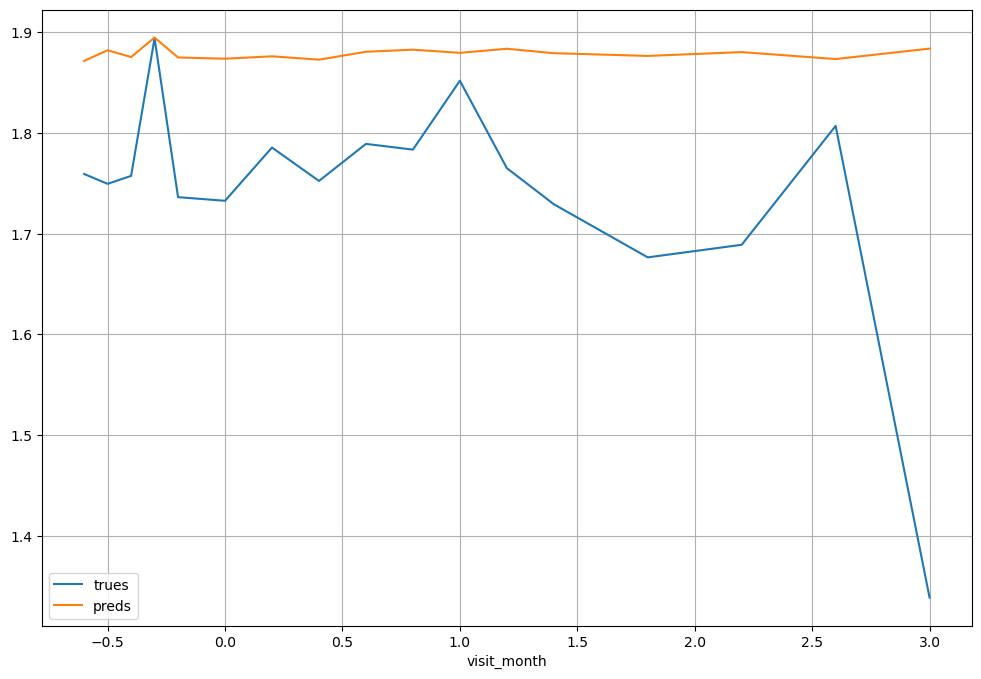

lsvr_updrs1_plus_month6 	 | 49.34


,trues,preds
visit_month,,
-0.6,1.772728,1.886611
-0.5,1.762346,1.903402
-0.4,1.774083,1.894469
-0.3,1.893957,1.894574
-0.2,1.761786,1.891676
0.0,1.781368,1.895712
0.2,1.805697,1.896055
0.4,1.752883,1.886541
0.6,1.809733,1.890080


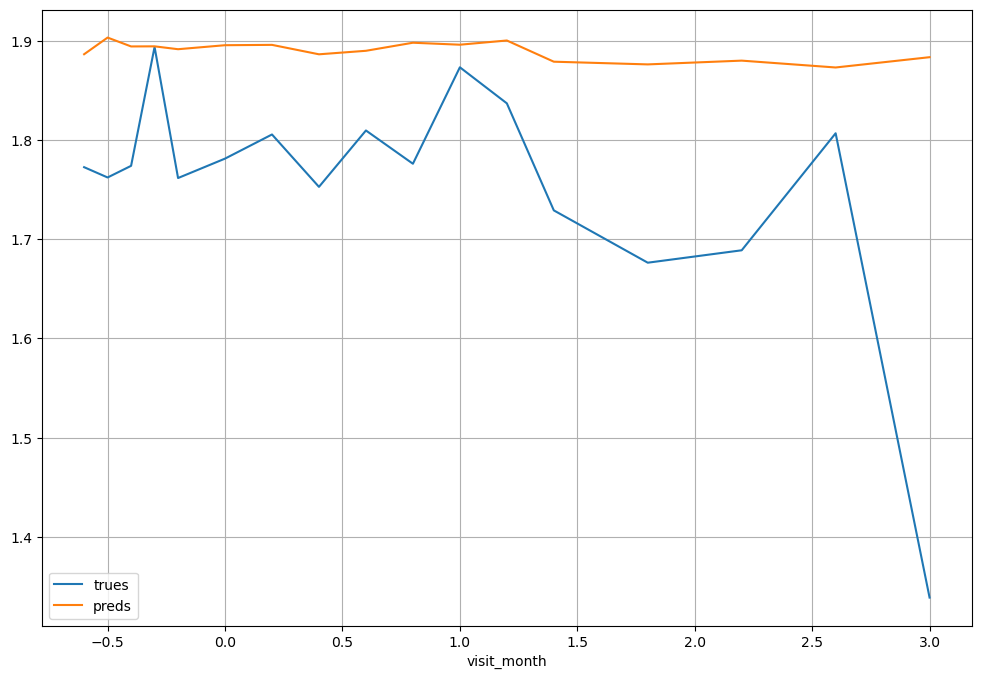

lsvr_updrs1_plus_month12 	 | 55.34


,trues,preds
visit_month,,
-0.6,1.776380,1.897076
-0.5,1.762346,1.903402
-0.4,1.774255,1.901156
-0.3,1.893957,1.894574
-0.2,1.767483,1.902692
0.0,1.795076,1.907438
0.2,1.826697,1.904644
0.4,1.777641,1.897687
0.6,1.812079,1.901008


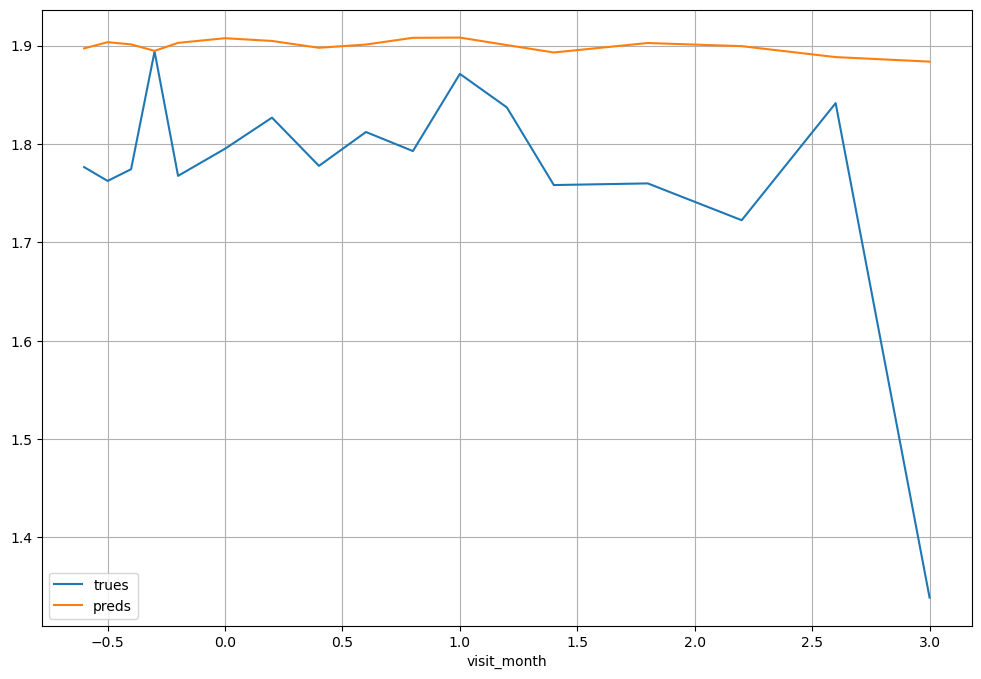

lsvr_updrs1_plus_month24 	 | 55.86


,trues,preds
visit_month,,
-0.6,1.783243,1.913028
-0.5,1.762346,1.903402
-0.4,1.791639,1.921026
-0.3,1.893957,1.894574
-0.2,1.781087,1.915077
0.0,1.792517,1.917646
0.2,1.844346,1.917560
0.4,1.791888,1.909567
0.6,1.832530,1.913494


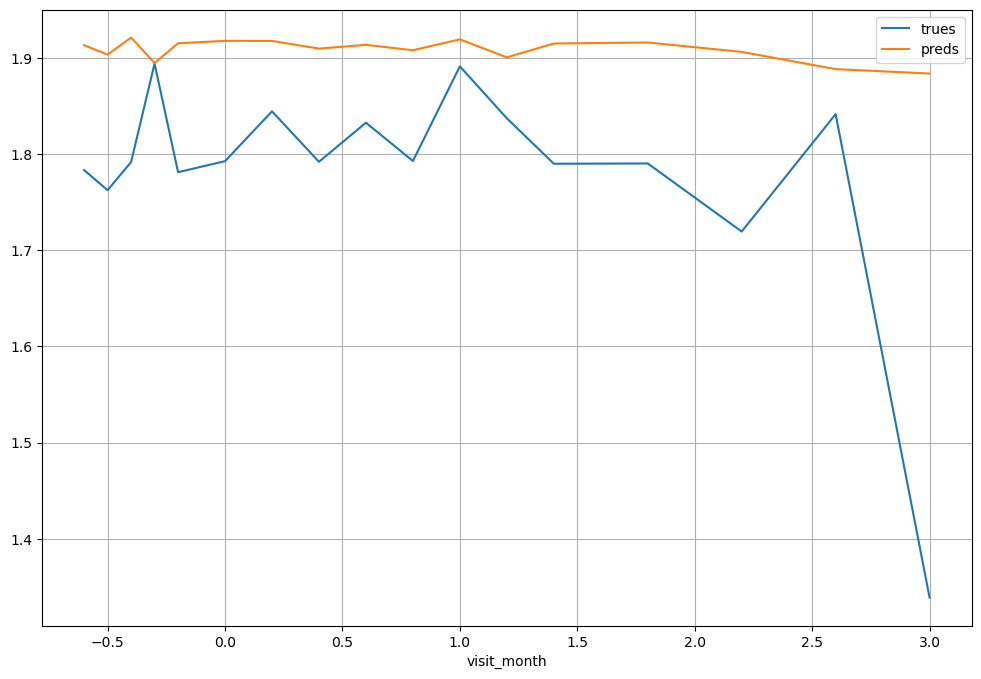

------------------------------
	 lsvr updrs score 	 | 54.27222913083739
------------------------------
lsvr_updrs2_plus_month0 	 | 63.89


,trues,preds
visit_month,,
-0.6,1.794094,1.882329
-0.5,1.588738,1.886159
-0.4,1.731691,1.876918
-0.3,1.609685,1.877289
-0.2,1.716477,1.885850
0.0,1.636764,1.884291
0.2,1.674050,1.882745
0.4,1.701771,1.883043
0.6,1.731430,1.882348


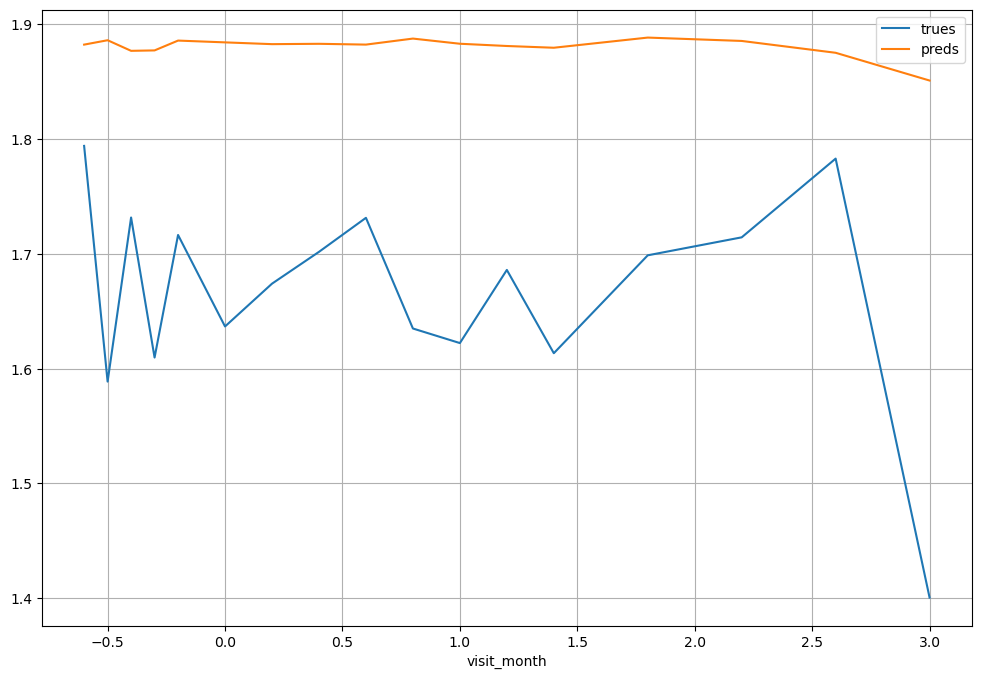

lsvr_updrs2_plus_month6 	 | 52.27


,trues,preds
visit_month,,
-0.6,1.807608,1.907202
-0.5,1.701157,1.925036
-0.4,1.784578,1.909521
-0.3,1.609685,1.877289
-0.2,1.759227,1.914550
0.0,1.738482,1.918876
0.2,1.759463,1.914700
0.4,1.720638,1.905306
0.6,1.735267,1.902013


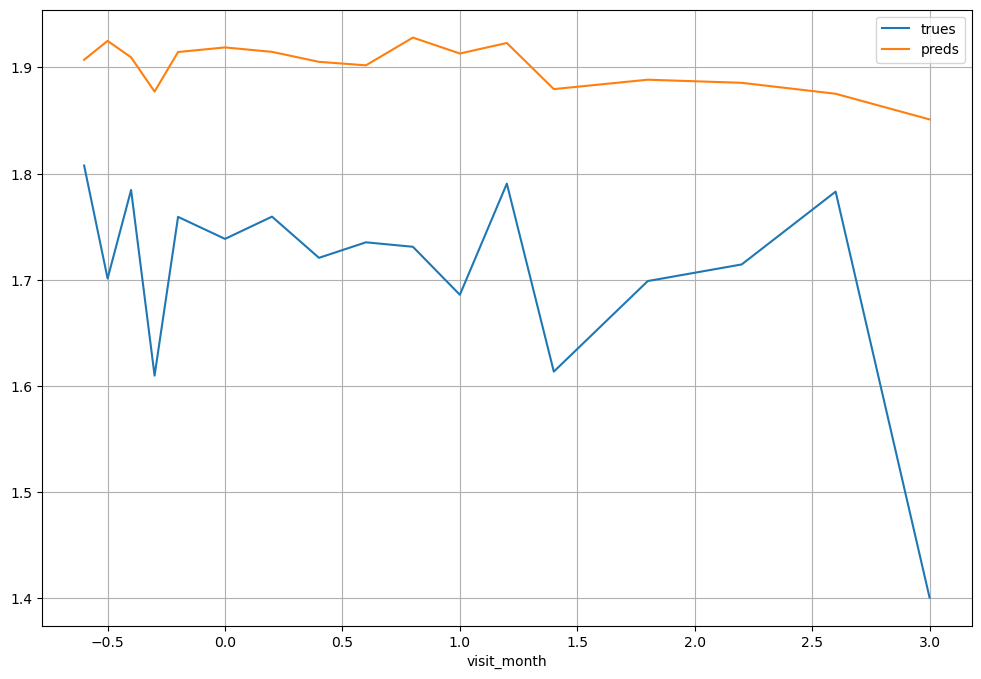

lsvr_updrs2_plus_month12 	 | 56.48


,trues,preds
visit_month,,
-0.6,1.785973,1.912861
-0.5,1.701157,1.925036
-0.4,1.759365,1.910886
-0.3,1.609685,1.877289
-0.2,1.742269,1.913302
0.0,1.711191,1.919630
0.2,1.748277,1.918681
0.4,1.719992,1.909959
0.6,1.742605,1.910828


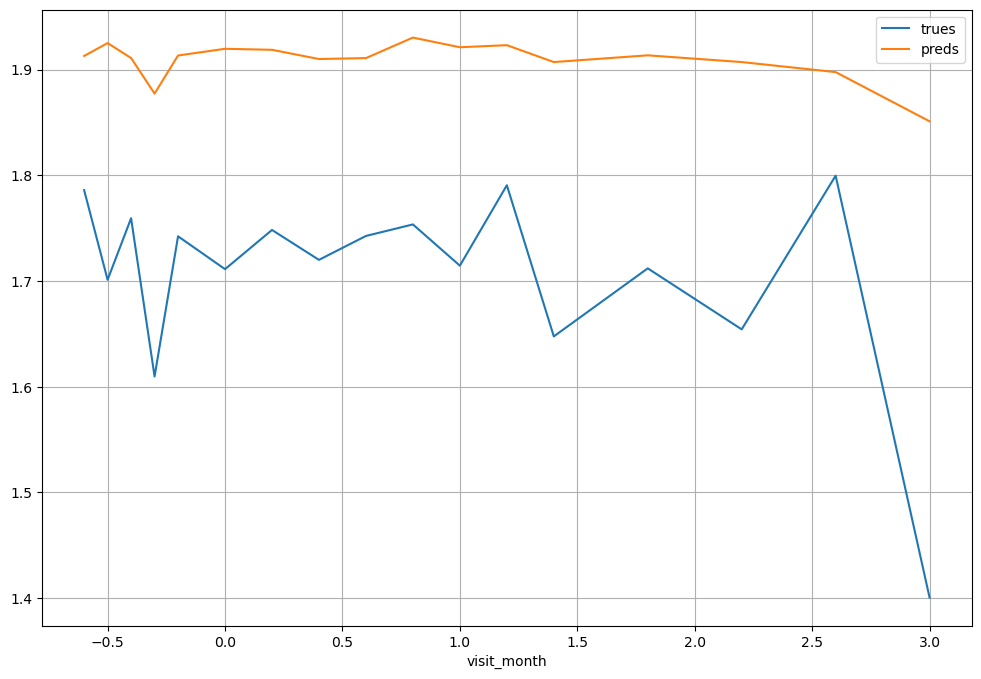

lsvr_updrs2_plus_month24 	 | 66.30


,trues,preds
visit_month,,
-0.6,1.791733,1.918697
-0.5,1.701157,1.925036
-0.4,1.755710,1.916594
-0.3,1.609685,1.877289
-0.2,1.745856,1.920225
0.0,1.706344,1.924358
0.2,1.744591,1.923949
0.4,1.699504,1.916017
0.6,1.726079,1.916994


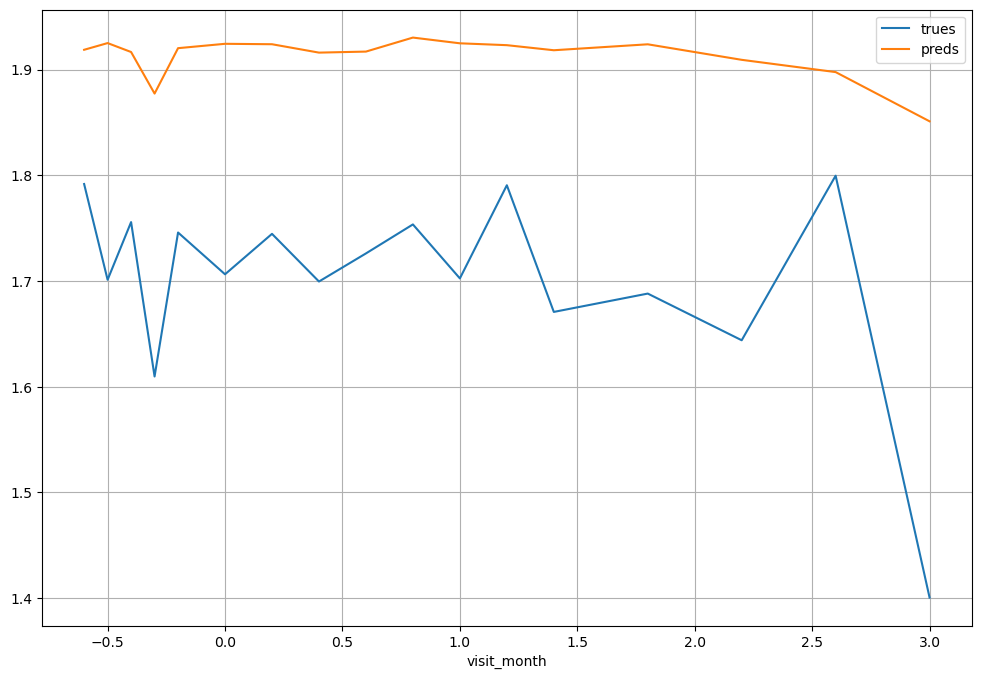

------------------------------
	 lsvr updrs score 	 | 59.73480793098497
------------------------------
lsvr_updrs3_plus_month0 	 | 45.40


,trues,preds
visit_month,,
-0.600000,3.035657,3.158110
-0.500000,3.114651,3.193574
-0.433333,3.091927,3.148976
-0.400000,2.978108,3.161912
-0.300000,3.114965,3.178926
-0.200000,2.953106,3.164120
0.000000,2.966575,3.171087
0.200000,2.990121,3.170278
0.400000,2.937721,3.167449


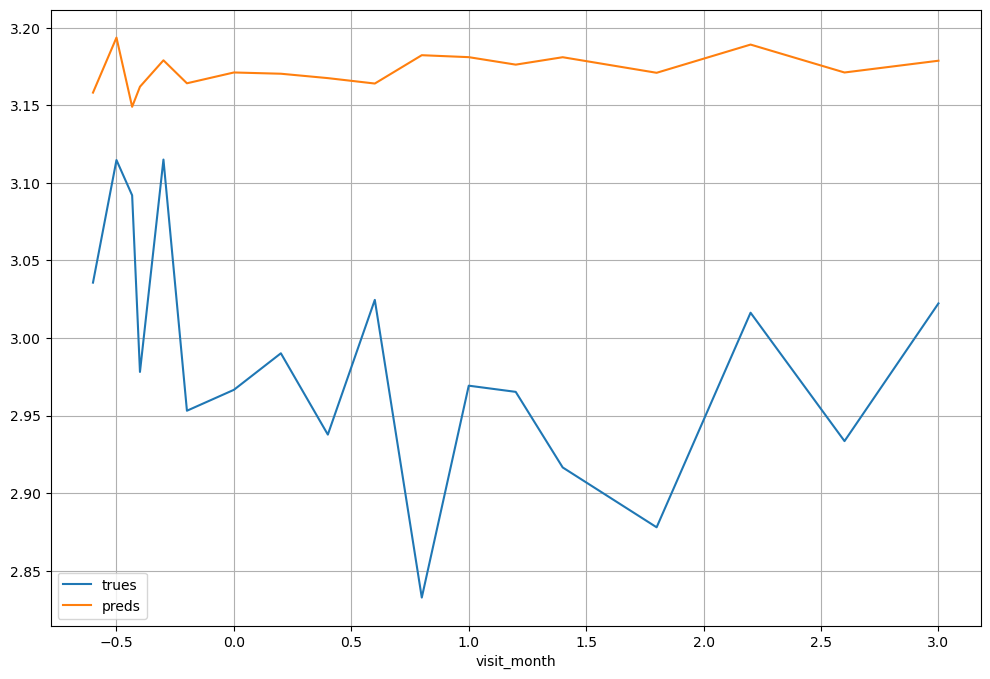

lsvr_updrs3_plus_month6 	 | 41.67


,trues,preds
visit_month,,
-0.600000,3.044437,3.167855
-0.500000,3.107625,3.194190
-0.433333,3.091927,3.148976
-0.400000,3.021622,3.172090
-0.300000,3.114965,3.178926
-0.200000,3.011028,3.173175
0.000000,3.016667,3.176147
0.200000,3.019174,3.178301
0.400000,2.984401,3.171405


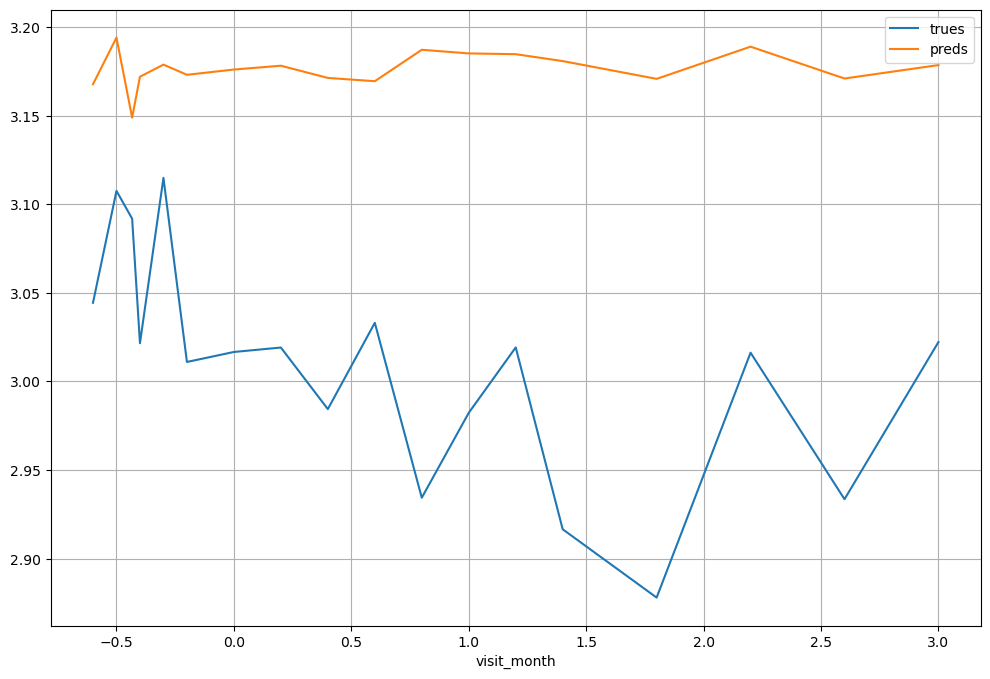

lsvr_updrs3_plus_month12 	 | 47.82


,trues,preds
visit_month,,
-0.600000,3.029348,3.176824
-0.500000,3.107625,3.194190
-0.433333,3.091927,3.148976
-0.400000,3.024285,3.180577
-0.300000,3.114965,3.178926
-0.200000,3.029387,3.181606
0.000000,3.027608,3.186579
0.200000,3.029865,3.185534
0.400000,2.993319,3.180519


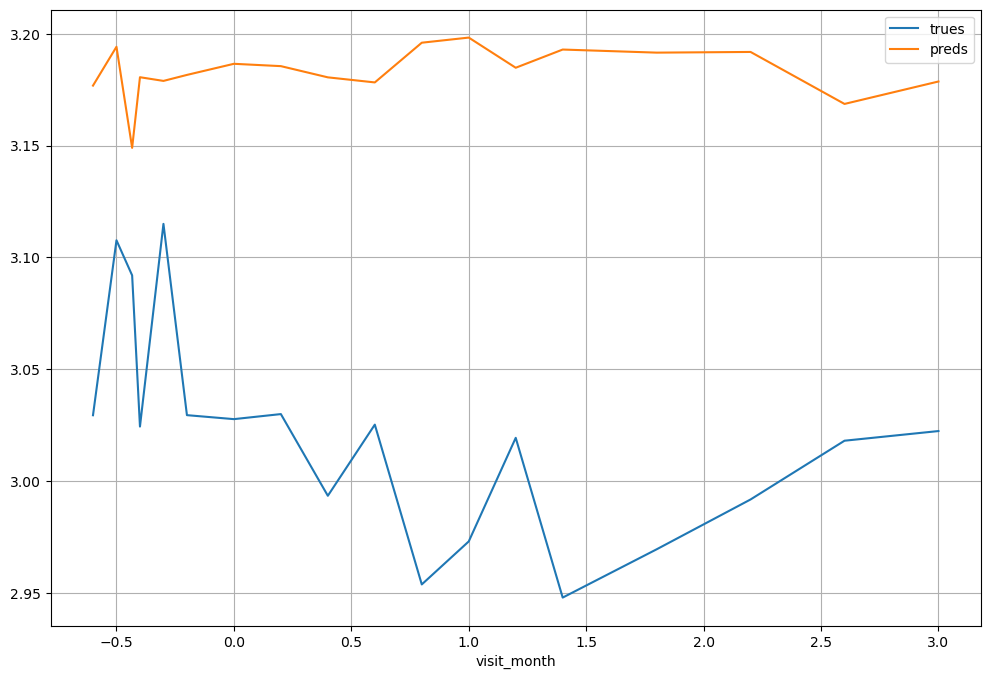

lsvr_updrs3_plus_month24 	 | 45.18


,trues,preds
visit_month,,
-0.600000,3.034286,3.187088
-0.500000,3.107625,3.194190
-0.433333,3.091927,3.148976
-0.400000,3.030389,3.194142
-0.300000,3.114965,3.178926
-0.200000,3.029332,3.190084
0.000000,3.028666,3.194538
0.200000,3.031296,3.195049
0.400000,3.013754,3.192698


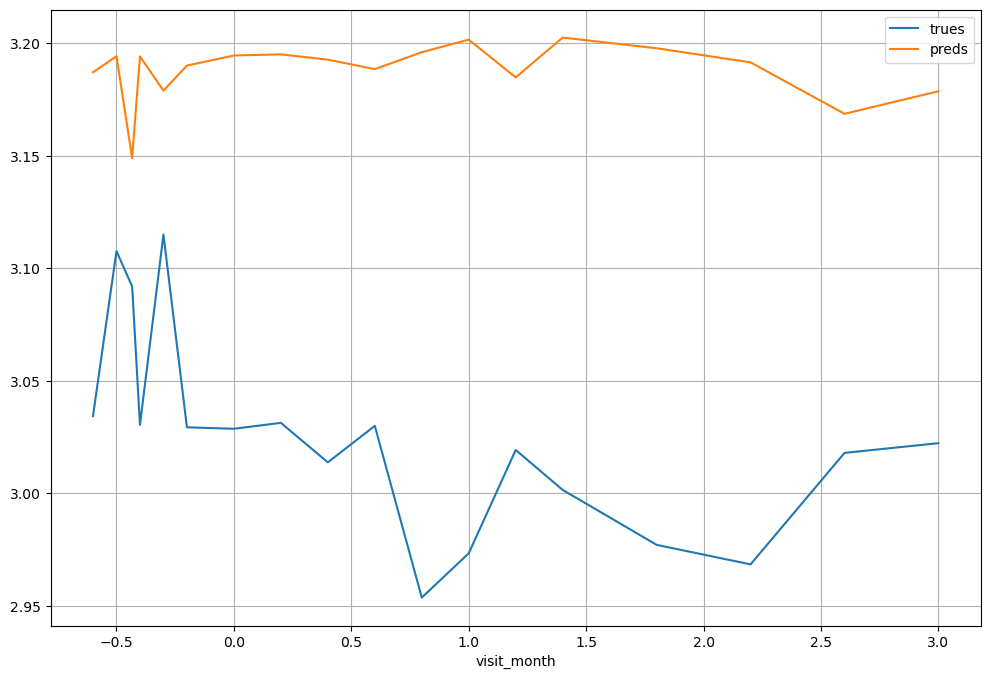

------------------------------
	 lsvr updrs score 	 | 45.01693536168129
------------------------------
lsvr_updrs4_plus_month0 	 | 42.38


,trues,preds
visit_month,,
-0.600000,0.462716,-4.219583e-14
-0.500000,0.526983,2.967943e-14
-0.433333,0.461837,-4.733816e-14
-0.400000,0.542378,-7.350932e-15
-0.300000,0.476465,5.943309e-14
-0.200000,0.503533,2.183037e-15
0.000000,0.464300,-6.949241e-16
0.200000,0.470563,-4.061972e-15
0.400000,0.465072,-1.085464e-14


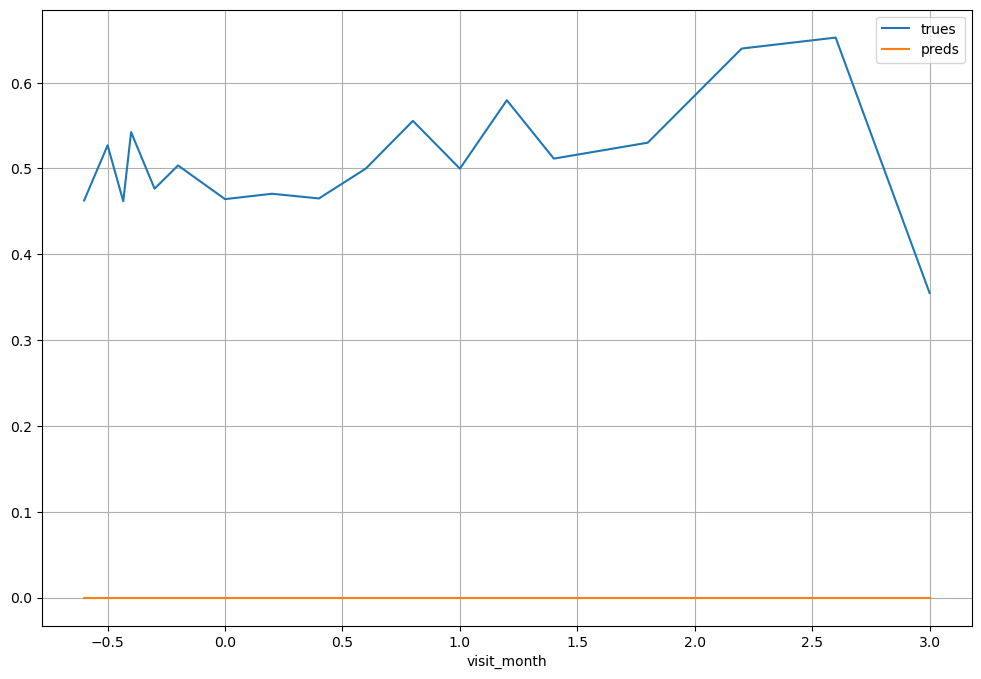

lsvr_updrs4_plus_month6 	 | 30.76


,trues,preds
visit_month,,
-0.600000,0.471763,-1.268959e-14
-0.500000,0.740153,8.275584e-14
-0.433333,0.461837,-4.733816e-14
-0.400000,0.517488,1.107695e-13
-0.300000,0.476465,5.943309e-14
-0.200000,0.521343,1.108305e-13
0.000000,0.488360,1.108181e-13
0.200000,0.496147,1.172287e-13
0.400000,0.517529,7.265105e-14


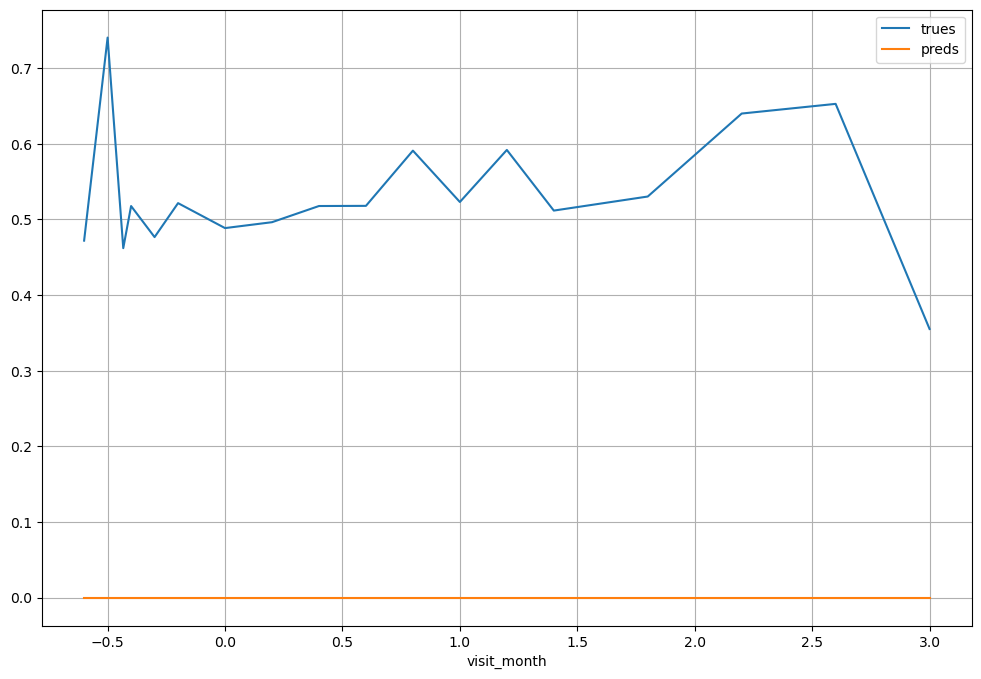

lsvr_updrs4_plus_month12 	 | 54.17


,trues,preds
visit_month,,
-0.600000,0.483991,1.144309e-02
-0.500000,0.740153,8.275584e-14
-0.433333,0.461837,-4.733816e-14
-0.400000,0.572513,4.251949e-02
-0.300000,0.476465,5.943309e-14
-0.200000,0.564518,4.541178e-02
0.000000,0.535941,4.531723e-02
0.200000,0.522811,1.638580e-02
0.400000,0.528963,1.906434e-02


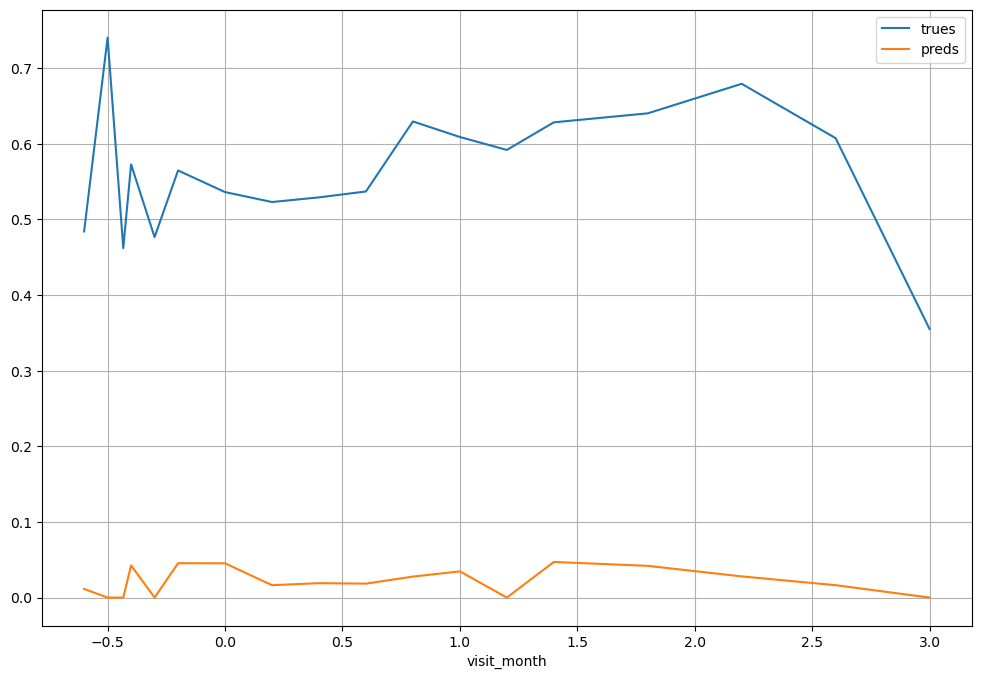

lsvr_updrs4_plus_month24 	 | 69.82


,trues,preds
visit_month,,
-0.600000,0.505652,5.247605e-02
-0.500000,0.740153,8.275584e-14
-0.433333,0.461837,-4.733816e-14
-0.400000,0.681738,1.393324e-01
-0.300000,0.476465,5.943309e-14
-0.200000,0.589325,1.031900e-01
0.000000,0.567931,1.044504e-01
0.200000,0.558513,6.933366e-02
0.400000,0.539438,7.198333e-02


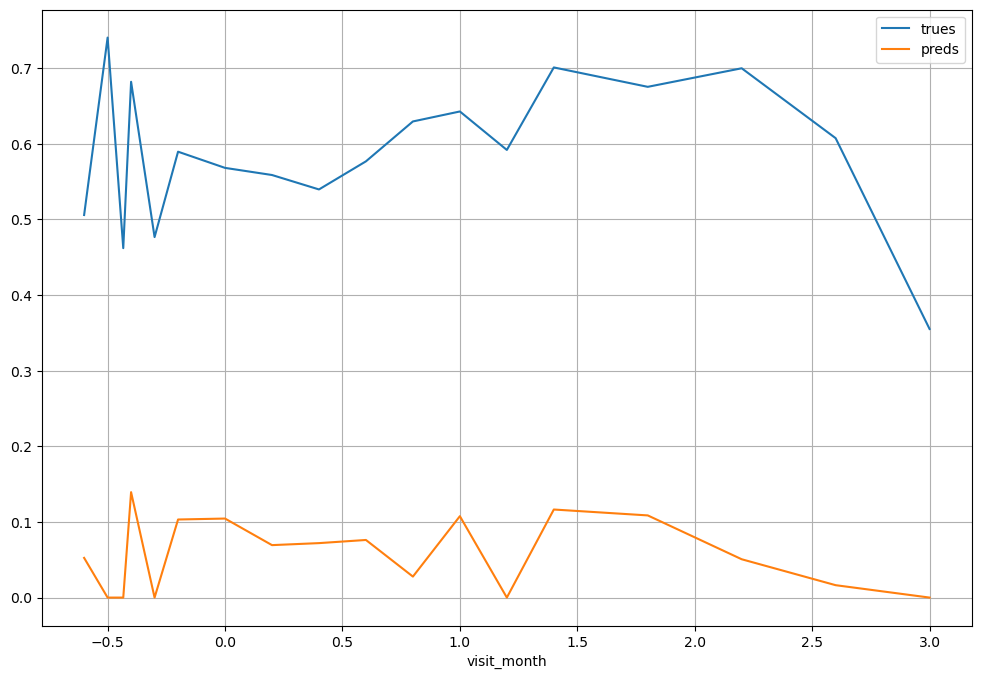

------------------------------
	 lsvr updrs score 	 | 49.28230680486651
------------------------------
--------------------------------------------------
			 lsvr total mean 		 | 52.08
--------------------------------------------------
----------------------------------------------------------------------
			 MODELS total mean 		 | 52.08
----------------------------------------------------------------------
Model 			| SMAPE score (when updrs_4 scores are all set to zero)
----------------------------------------------------------------------
lsvr_updrs1_plus_month0 | 56.550920305502785
lsvr_updrs1_plus_month6 | 49.3447848336864
lsvr_updrs1_plus_month12 | 55.33696883908542
lsvr_updrs1_plus_month24 | 55.85624254507498
lsvr_updrs2_plus_month0 | 63.89193653616648
lsvr_updrs2_plus_month6 | 52.26602423974248
lsvr_updrs2_plus_month12 | 56.47906726581541
lsvr_updrs2_plus_month24 | 66.3022036822155
lsvr_updrs3_plus_month0 | 45.40140478579049
lsvr_updrs3_plus_month6 | 41.6654061044458
lsvr_updrs3

In [34]:
# Calculrate score when updrs_4 are all set to zero.  
def calculate_smape_score_when_part4_set_to_zero():
    smape_when_part4_is_zero = {}
    model_names = ['lsvr']
    TOTAL_SCORE = 0
    print('-'*70)
    print(f'Model \t\t\t| SMAPE score (when updrs_4 scores are all set to zero)')
    print('-'*70)
    
#     scaler = MinMaxScaler()
#     scaler = StandardScaler()
#     scaler = RobustScaler()
    
    for model_name in model_names:
        model_total_mean = 0
        for updrs_part in [1, 2, 3, 4]:
            model_updrs_score = 0
            trues = []
            preds = []
            visit_months = []
            month_offsets = []
            for i, plus_month in enumerate([0, 6, 12, 24]):
                
                
                    
                key = f"updrs_{updrs_part}_plus_{plus_month}"
    
                
                X = X_dict[key].copy()
                y = y_dict[key].copy()
                visit_months.extend(X['visit_month'])
                
                # Add fold number column
                X, y = add_fold_column(X, y, n_folds=cfg.n_splits)
#                 X[features_col] = scaler.transform(X[features_col])
            
                n_splits = cfg.n_splits
                score = 0

                
                for fold in range(n_splits):
                    val_idx = X['fold']==fold
                    
                    # lgbm
                    X_val = X.loc[val_idx].drop(['visit_id', 'fold'], axis=1)
                    y_val = y.loc[val_idx][f'updrs_{updrs_part}']
                    
                    # linear
                    linear_X_val = X.loc[val_idx][["visit_month", "plus_month"]].reset_index(drop=True)
                    linear_y_val = y.loc[val_idx][f'updrs_{updrs_part}'].reset_index(drop=True)
                    
                    month_offset = X_val['visit_month'].values + plus_month
                    month_offsets.extend(month_offset)
#                     display(month_offset)
                    
#                     if updrs_part == 4:
#                         if plus_month in [0,6]:
#                         y_pred = np.zeros(len(X_valid))
#                         else:
#                             key = f'{model_name}_updrs{updrs_part}_plus_month{plus_month}'
#                             model = best_models[f'{key}_fold{fold}']
#                             y_pred = model.predict(X_valid) 
                
                    key = f'{model_name}_updrs{updrs_part}_plus_month{plus_month}'
        
                    if model_name == 'lgbm':
                        trues.extend(list(y_val))
                        model = best_models[f'{key}_fold{fold}']
                        y_pred = model.predict(X_val)
#                         y_pred = np.array([i[0] for i in y_pred])
                        score =  exp_score(y_val, y_pred)
                    else:
                        trues.extend(list(linear_y_val))
                        model = best_models[f'{key}_fold{fold}']
                        y_pred = model.predict(linear_X_val)
#                         y_pred = np.array([i[0] for i in y_pred])
                        score =  exp_score(linear_y_val, y_pred)
#                     y_pred1 = np.array([i[0] for i in y_pred])
                    
                    
#                     month_idx = month_offset>=6
                    
#                     add_feat = np.array(
#                         [
#                             target_visit_month_medians[target_visit_month_medians['visit_month']==month][f"updrs_{updrs_part}"].values
#                             if month in target_visit_month_medians.visit_month.unique() 
#                             else np.array([target_visit_month_medians.iloc[np.argmin(np.abs(month - target_visit_month_medians['visit_month']))][f"updrs_{updrs_part}"]])
#                             for month in month_offset 
#                         ]
#                     )
                    
#                     if updrs_part in [2,3]:
#                         display(add_feat)
#                     y_pred1[month_idx] = (y_pred1[month_idx] + add_feat.squeeze(1)[month_idx])/2
#                     if add_feat.ndim == 2:
#                         y_pred1[month_idx] = (y_pred1[month_idx] + add_feat.squeeze(1)[month_idx])/2
#                     elif add_feat.ndim == 1:
#                     display(add_feat)
#                     y_pred1[month_idx] = (y_pred1[month_idx] + add_feat.squeeze(1)[month_idx])/2
                    preds.extend(list(y_pred))
                    
#                     display(y_pred1)
                    
#                     y_pred2 = np.array([i[1] for i in y_pred])
#                     score =  normal_score(y_valid, y_pred)
#                     score2 =  normal_score(y_valid.iloc[:,1], y_pred2)
#                     score += ((score1 * 0.9) + (score2 * 0.1)) / float(n_splits)

                print(f'{model_name}_updrs{updrs_part}_plus_month{plus_month} \t | {score:.2f}')
                check_df = pd.DataFrame(trues, columns=['trues'])
                check_df["preds"] = preds
                check_df['visit_month'] = visit_months
                check_df['month_offset'] = month_offsets
                display(check_df.groupby('visit_month')[['trues','preds']].mean())
                check_df.groupby("visit_month")[["trues","preds"]].mean().plot(figsize=(12,8),grid=True)
                plt.show()
                model_updrs_score += score/4
                smape_when_part4_is_zero[key] = score
            print('-'*30)
            print(f'\t {model_name} updrs score \t | {model_updrs_score}')
            print('-'*30)
            model_total_mean += model_updrs_score / 4
        TOTAL_SCORE += model_total_mean / len(model_names)
        print('-'*50)
        print(f'\t\t\t {model_name} total mean \t\t | {model_total_mean:.2f}')
        print('-'*50)
    print("-"*70)
    print(f'\t\t\t MODELS total mean \t\t | {TOTAL_SCORE:.2f}')
    
    return smape_when_part4_is_zero

smape_when_part4_is_zero = \
    calculate_smape_score_when_part4_set_to_zero()

print('-'*70)
print(f'Model \t\t\t| SMAPE score (when updrs_4 scores are all set to zero)')
print('-'*70)
smape_mean = 0
for k, v in smape_when_part4_is_zero.items():
    print(f'{k} | {v}')
    smape_mean += v / float(len(smape_when_part4_is_zero))
print('-'*70)
print(f'SMAPE mean\t\t| {smape_mean:.2f}')

In [35]:
def preprocessing_test_data(clinical, peptides, proteins, sample_submission, peptide_candidates, protein_candidates):
    def create_peptide_candidate_df(peptides_df, peptide_candidates):
        peptide_candidate_df = peptides_df.query("Peptide in @peptide_candidates")
        visit_ids = peptide_candidate_df['visit_id'].unique()

        peptide_dic_list = []
    

        for visit_id in visit_ids:
            peptide_df = peptide_candidate_df.query(f"visit_id == '{visit_id}'")
            peptides = peptide_df.Peptide.values
            PAs = peptide_df.PeptideAbundance.values
            peptide_dic = dict(zip(peptide_candidates, [np.nan]*len(peptide_candidates)))
            for peptide, PA in zip(peptides, PAs):
                peptide_dic[peptide] = PA
            peptide_dic['visit_id'] = visit_id
            peptide_dic_list.append(peptide_dic)
        
        return pd.DataFrame(peptide_dic_list)
    

    def create_protein_candidate_df(proteins_df, protein_candidates):
        protein_candidate_df = proteins_df.query("UniProt in @protein_candidates")
        visit_ids = protein_candidate_df['visit_id'].unique()

        protein_dic_list = []

        for visit_id in visit_ids:
            protein_df = protein_candidate_df.query(f"visit_id == '{visit_id}'")
            proteins = protein_df.UniProt.values
            NPXs = protein_df.NPX.values
            protein_dic = dict(zip(protein_candidates, [np.nan]*len(protein_candidates)))
            for protein, NPX in zip(proteins, NPXs):
                protein_dic[protein] = NPX
            protein_dic['visit_id'] = visit_id
            protein_dic_list.append(protein_dic)
        
        return pd.DataFrame(protein_dic_list)
    
    def median_protein_fill(df, proteins, protein_candidates):
        # median_df = pd.merge(df, peptides[peptides['Peptide'].isin(peptide_candidates)].pivot('visit_id','Peptide','PA_log2').reset_index(),on='visit_id',how='left')
        # median_df = pd.merge(median_df, proteins[proteins['UniProt'].isin(protein_candidates)].pivot('visit_id','UniProt','NPX_log2').reset_index(),on='visit_id',how='left')
        median_df = df.groupby("visit_month")[protein_candidates].median()
        median_df.interpolate(inplace=True)
        median_df.reset_index(inplace=True)
        
        
        for visit_month in tqdm(median_df['visit_month'].values):
            for feat in protein_candidates:
                df.loc[(df['visit_month']==visit_month)  & (df[feat].isnull()), feat] = \
                    median_df[median_df["visit_month"]==visit_month][feat].values[0]
        
        return df
    
    def create_basic_peptide_protein_stat_features(peptides,proteins):
    
        unique_peptide = peptides.Peptide.unique()
        pivot_pep_df = peptides.pivot(['visit_id', 'patient_id'],'Peptide','PeptideAbundance').reset_index()
        pivot_pep_df["non_express_pep_num"] = pivot_pep_df[unique_peptide].isnull().sum(axis=1)
        pivot_pep_df['express_pep_num'] = len(unique_peptide) - pivot_pep_df['non_express_pep_num']
        
        pivot_pep_df = pivot_pep_df.fillna(0)
        
        peptide_mean = pivot_pep_df.groupby('patient_id')[unique_peptide].mean().reset_index()
        
        pivot_pep_df['mean_PA'] = pivot_pep_df[unique_peptide].mean(axis=1)
#         pivot_pep_df['diff_PA'] = pivot_pep_df[unique_peptide].max(axis=1) - pivot_pep_df[unique_peptide].min(axis=1)
        pivot_pep_df['quan10_PA'] = pivot_pep_df[unique_peptide].quantile(0.10, axis=1)
        pivot_pep_df['quan50_PA'] = pivot_pep_df[unique_peptide].quantile(0.50, axis=1)
        pivot_pep_df['quan90_PA'] = pivot_pep_df[unique_peptide].quantile(0.90, axis=1)
        
        
        pivot_pep_df['std_PA'] = pivot_pep_df[unique_peptide].std(axis=1)
        pivot_pep_df['var_PA'] = pivot_pep_df[unique_peptide].var(axis=1)
        pivot_pep_df['skew_PA'] = pivot_pep_df[unique_peptide].skew(axis=1)
        pivot_pep_df['kurt_PA'] = pivot_pep_df[unique_peptide].kurt(axis=1)
        pivot_pep_df['mad_PA'] = pivot_pep_df[unique_peptide].mad(axis=1)
    
    
    
    
        # csf의 단백질 수치가 많아지면 염증, 몸이 안좋다는 점
        unique_protein = proteins.UniProt.unique()
        pivot_prot_df = proteins.pivot(['visit_id', 'patient_id'],'UniProt','NPX').reset_index()
        pivot_prot_df["non_express_prot_num"] = pivot_prot_df[unique_protein].isnull().sum(axis=1)
        pivot_prot_df['express_prot_num'] = len(unique_protein) - pivot_prot_df['non_express_prot_num']
        pivot_prot_df = pivot_prot_df.fillna(0)
        
        protein_mean = pivot_prot_df.groupby('patient_id')[unique_protein].mean().reset_index()
        
        pivot_prot_df['mean_NPX'] = pivot_prot_df[unique_protein].mean(axis=1)
#         pivot_prot_df['diff_NPX'] = pivot_prot_df[unique_protein].max(axis=1) - pivot_prot_df[unique_protein].min(axis=1)
        pivot_prot_df['quan10_NPX'] = pivot_prot_df[unique_protein].quantile(0.10, axis=1)
        pivot_prot_df['quan50_NPX'] = pivot_prot_df[unique_protein].quantile(0.50, axis=1)
        pivot_prot_df['quan90_NPX'] = pivot_prot_df[unique_protein].quantile(0.90, axis=1)
        
    
        pivot_prot_df['std_NPX'] = pivot_prot_df[unique_protein].std(axis=1)
        pivot_prot_df['var_NPX'] = pivot_prot_df[unique_protein].var(axis=1)
        pivot_prot_df['skew_NPX'] = pivot_prot_df[unique_protein].skew(axis=1)
        pivot_prot_df['kurt_NPX'] = pivot_prot_df[unique_protein].kurt(axis=1)
        pivot_prot_df['mad_NPX'] = pivot_prot_df[unique_protein].mad(axis=1)   


        return pivot_pep_df[['visit_id','mean_PA',"quan10_PA","quan50_PA","quan90_PA",'std_PA','var_PA','skew_PA','kurt_PA', 'mad_PA', 'express_pep_num']], \
                pivot_prot_df[['visit_id','mean_NPX',"quan10_NPX","quan50_NPX","quan90_NPX",'std_NPX','var_NPX','skew_NPX','kurt_NPX', 'mad_NPX', 'express_prot_num']]   
    
    


    df = clinical.copy()
#     peptide_candidate_df = create_peptide_candidate_df(peptides, peptide_candidates)
    protein_candidate_df = create_protein_candidate_df(proteins, protein_candidates)
    
#     peptide_features_col = list(peptide_candidate_df.columns)
    protein_features_col = list(protein_candidate_df.columns)

#     peptide_features_col.remove("visit_id")
    protein_features_col.remove("visit_id")
    
    pivot_pep_df, pivot_prot_df = create_basic_peptide_protein_stat_features(peptides,proteins)
    
#     df = pd.merge(df, peptide_candidate_df, on='visit_id', how='left')
    df = pd.merge(df, protein_candidate_df, on='visit_id', how='left')
#     df = pd.merge(df, pivot_pep_df, on='visit_id', how='left')
    df = pd.merge(df, pivot_prot_df, on='visit_id', how='left')
#     df = pd.merge(df, proteins.pivot('visit_id','UniProt','NPX').reset_index().groupby('visit_id').count().sum(axis=1).reset_index().rename(columns={0 :"prot_nunique"}), on='visit_id',how='left')
#     df = pd.merge(df, peptides.pivot('visit_id','Peptide','PeptideAbundance').reset_index().groupby('visit_id').count().sum(axis=1).reset_index().rename(columns={0 :"pep_nunique"}), on='visit_id',how='left')
    
#     df = median_protein_fill(df, proteins, protein_candidates)
    
        
    
    if 'group_key' in df.columns:
        df.drop('group_key', axis=1, inplace=True)
        
    prediction_ids = sample_submission['prediction_id']
    for prediction_id in prediction_ids:
        visit_id = prediction_id.split("_")[0] + "_" + prediction_id.split('_')[1]
        updrs = prediction_id.split("_")[2] + "_" + prediction_id.split("_")[3]
        plus_month = int(prediction_id.split("_")[5])
        month = int(visit_id.split("_")[1]) + plus_month
    
    return df

In [36]:
test_proteins['NPX'] = test_proteins['NPX'].apply(np.log1p)
test_peptides['PeptideAbundance'] = test_peptides['PeptideAbundance'].apply(np.log1p)
test_df = preprocessing_test_data(test,
                                  test_peptides,
                                  test_proteins,
                                  sample_submission,
                                  [], # defined in training
                                  select_protein)  # defined in training

display(test_df.head(5).style.set_properties(
    **{"background-color": "#212636","color":"white","border": "1.5px solid white"}))

,visit_id,visit_month,patient_id,updrs_test,row_id,P04180,O00533,P02787,P02774,O15240,P04217,P13521,Q06481,P05060,mean_NPX,quan10_NPX,quan50_NPX,quan90_NPX,std_NPX,var_NPX,skew_NPX,kurt_NPX,mad_NPX,express_prot_num
0,3342_0,0,3342,updrs_1,3342_0_updrs_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,3342_0,0,3342,updrs_2,3342_0_updrs_2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,3342_0,0,3342,updrs_3,3342_0_updrs_3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,3342_0,0,3342,updrs_4,3342_0_updrs_4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,50423_0,0,50423,updrs_1,50423_0_updrs_1,11.322082,13.103676,17.461151,14.901825,11.730815,14.244081,10.695029,10.096815,11.953243,11.429125,9.086973,11.585428,14.424498,3.067937,9.412235,-1.611759,5.411958,2.069280,227.000000


In [37]:
import amp_pd_peptide
amp_pd_peptide.make_env.func_dict['__called__'] = False
env = amp_pd_peptide.make_env()
iter_test = env.iter_test()

n_splits = cfg.n_splits
i = 0

model_names = ['lsvr']
for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    test_proteins['NPX'] = test_proteins['NPX'].apply(np.log1p)
    test_peptides['PeptideAbundance'] = test_peptides['PeptideAbundance'].apply(np.log1p)

    test_df = preprocessing_test_data(
        test,
        test_peptides,
        test_proteins,
        sample_submission,
        [],
        select_protein
    )
    
  
    row_ids = test_df['row_id']
    
    include_prot_visit_id = str(test_proteins.visit_id.unique()[0])
    
  
    for row_id in tqdm(row_ids):
        display(row_id) # 3342_0_updrs_1
        # 단백질정보가 없을 때 median + linearmodel
        if include_prot_visit_id not in row_id:
            display(f" not include {include_prot_visit_id}")
            visit_month = int(row_id.split("_")[1])
            updrs_part = int(row_id.split("_")[3]) # 1,2,3,4
            for idx, plus_month in enumerate([0, 6, 12, 24]):
                
                month_offset = visit_month + plus_month
                
                if month_offset not in target_visit_month_medians['visit_month'].values:
                    median_missing_idx = np.argmin(np.abs(month_offset - target_visit_month_medians['visit_month']))
                    rating = target_visit_month_medians.iloc[median_missing_idx][f'updrs_{updrs_part}']
                else:
                    rating = target_visit_month_medians[target_visit_month_medians['visit_month']==month_offset][f"updrs_{updrs_part}"].values
                
                prediction_id = f'{row_id}_plus_{plus_month}_months'
                index = sample_submission.query(f'prediction_id=="{prediction_id}"').index
                sample_submission.loc[index, 'rating'] = np.round(np.expm1(rating))
        
        # 단백질 정보가 있을 때 
        else:
            X = test_df.query(f'row_id==@row_id')
            X = X.drop(['visit_id','patient_id','updrs_test','row_id'],axis=1)


            visit_month = int(row_id.split("_")[1])
            updrs_part = int(row_id.split("_")[3]) # 1,2,3,4

            for idx, plus_month in enumerate([0, 6, 12, 24]):
    
                X['plus_month'] = plus_month
                month_offset = visit_month + plus_month


                XX = X.copy()
                XX[features_col] = scaler.transform(XX[features_col])
                
                
                rating = 0
               
#                 feature = target_dict[f"updrs_{updrs_part}_plus_{plus_month}"]
#                 XX[feature] = scaler_dict[f"updrs_{updrs_part}_plus_{plus_month}"].transform(XX[feature])
                XX = XX[['visit_month','plus_month']].copy()
                linear_X = XX[['visit_month','plus_month']].copy()
                for fold in range(n_splits):
                    for model_name in model_names:

                        model = best_models[f'{model_name}_updrs{updrs_part}_plus_month{plus_month}_fold{fold}']

                        if month_offset in target_visit_month_medians.visit_month.unique():
                            add_feat = np.array(target_visit_month_medians[target_visit_month_medians['visit_month']==month_offset][f"updrs_{updrs_part}"].values)
                        else:
                            add_feat = np.array([target_visit_month_medians.iloc[np.argmin(np.abs(month_offset - target_visit_month_medians['visit_month']))][f"updrs_{updrs_part}"]])


                        if model_name == 'lgbm':
                            y_pred = model.predict(XX)
#                                 y_pred = np.array([i[0] for i in y_pred])
                            y_pred *= 0.5

                        else:
                            y_pred = model.predict(linear_X)
#                                 y_pred = np.array([i[0] for i in y_pred])
                            y_pred *= 1



#                             month_idx = month_offset>=6
#                             display(add_feat)


                        rating += y_pred / float(n_splits)
                rating = (rating + add_feat) / 2
                if updrs_part == 4:
                    if month_offset not in target_visit_month_medians['visit_month'].values:
                        median_missing_idx = np.argmin(np.abs(month_offset - target_visit_month_medians['visit_month']))
                        rating = target_visit_month_medians.iloc[median_missing_idx][f'updrs_{updrs_part}']
                    else:
                        rating = target_visit_month_medians[target_visit_month_medians['visit_month']==month_offset][f"updrs_{updrs_part}"].values

                prediction_id = f'{row_id}_plus_{plus_month}_months'
                index = sample_submission.query(f'prediction_id=="{prediction_id}"').index
                sample_submission.loc[index, 'rating'] = np.round(np.expm1(rating))

    env.predict(sample_submission)
    display(sample_submission)

    i += 1


This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


  0%|          | 0/8 [00:00<?, ?it/s]

'3342_0_updrs_1'

' not include 50423_0'

'3342_0_updrs_2'

' not include 50423_0'

'3342_0_updrs_3'

' not include 50423_0'

'3342_0_updrs_4'

' not include 50423_0'

'50423_0_updrs_1'

'50423_0_updrs_2'

'50423_0_updrs_3'

'50423_0_updrs_4'

,prediction_id,rating
0,3342_0_updrs_1_plus_0_months,4.0
1,3342_0_updrs_1_plus_6_months,6.0
2,3342_0_updrs_1_plus_12_months,6.0
3,3342_0_updrs_1_plus_24_months,6.0
4,3342_0_updrs_2_plus_0_months,4.0
5,3342_0_updrs_2_plus_6_months,6.0
6,3342_0_updrs_2_plus_12_months,6.0
7,3342_0_updrs_2_plus_24_months,6.0
8,3342_0_updrs_3_plus_0_months,18.0
9,3342_0_updrs_3_plus_6_months,21.0


  0%|          | 0/8 [00:00<?, ?it/s]

'3342_6_updrs_1'

'3342_6_updrs_2'

'3342_6_updrs_3'

'3342_6_updrs_4'

'50423_6_updrs_1'

' not include 3342_6'

'50423_6_updrs_2'

' not include 3342_6'

'50423_6_updrs_3'

' not include 3342_6'

'50423_6_updrs_4'

' not include 3342_6'

,prediction_id,rating
0,3342_6_updrs_1_plus_0_months,6.0
1,3342_6_updrs_1_plus_6_months,6.0
2,3342_6_updrs_1_plus_12_months,6.0
3,3342_6_updrs_1_plus_24_months,6.0
4,3342_6_updrs_2_plus_0_months,6.0
5,3342_6_updrs_2_plus_6_months,6.0
6,3342_6_updrs_2_plus_12_months,6.0
7,3342_6_updrs_2_plus_24_months,6.0
8,3342_6_updrs_3_plus_0_months,21.0
9,3342_6_updrs_3_plus_6_months,21.0


In [38]:
# month_offset = 108
# clz= 4
# if month_offset not in target_visit_month_medians['visit_month'].values:
#     median_missing_idx = np.argmin(np.abs(month_offset - target_visit_month_medians['visit_month']))
#     rating = np.expm1(target_visit_month_medians.iloc[median_missing_idx][f'updrs_{clz}'])
# else:
#     rating = np.expm1(target_visit_month_medians[target_visit_month_medians['visit_month']==month_offset][f"updrs_{clz}"].values)

# rating
# np.expm1(rating)

In [39]:
# month_offset = 108
# clz= 4
# if month_offset in target_visit_month_medians.visit_month.unique():
#     add_feat = np.array(target_visit_month_medians[target_visit_month_medians['visit_month']==month_offset][f"updrs_{updrs_part}"].values)
# else:
#     add_feat = np.array([target_visit_month_medians.iloc[np.argmin(np.abs(month_offset - target_visit_month_medians['visit_month']))][f"updrs_{updrs_part}"]])
# add_feat

In [40]:
# target_visit_month_medians